# Setup

In [3]:
# !apt-get install -y fonts-nanum
# !fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install -U matplotlib

In [4]:
import pickle

import pandas as pd
from pandas.tseries.offsets import QuarterEnd, QuarterBegin, MonthEnd, MonthBegin, BDay
from pandas.tseries.offsets import MonthEnd, MonthBegin
from pandas.tseries.offsets import DateOffset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker

import requests

import statsmodels.api as sm
import statsmodels.formula.api as smf

import math

import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet as ENet
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import ExtraTreesRegressor as EXT
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras import backend

from datetime import datetime
from multiprocessing import Process

import glob
import os

from time import time
from tqdm import tqdm
import itertools

from tqdm import notebook

idx = pd.IndexSlice

2024-02-06 11:11:52.258522: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 11:11:52.790338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 11:11:57.095299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
plt.rcParams["font.family"] = "NanumGothicCoding"
plt.rcParams['axes.unicode_minus'] = False

In [6]:
def get_best_ens_models(ens_models):
    ens_best = {0:0, 3:0, 12:0}    
    
    # h=0, 3, 12 일때 best 조합)
    for i, ens in enumerate(ens_models):
        if set(ens) == set(['lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3', 'lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3', 'ext_roll0_lag0_d10_g1']):
            # print("h0 == ", i, ens)
            ens_best[0] = i
        if set(ens) == set(['lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3','lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3', 'ext_roll0_lag0_d10_g1']):
            # print("h3 == ", i, ens)
            ens_best[3] = i
        if set(ens) == set(['lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3', 'ext_roll0_lag0_d6_g1']):
            # print("h12 == ", i, ens)
            ens_best[12] = i
            
    return ens_best

In [7]:
def Nth_friday(year, month, order):
    """Return 1st, 2nd, ... , last friday of given year and month,
    order : 0, 1, 2, ..., -1
    """
    fridays = pd.date_range('2000-01-01', '2050-12-31', freq='W-FRI')
    fridays_of_the_month = [date for date in fridays if (date.year == year) & (date.month == month)]

    try:
        return fridays_of_the_month[order]
    except:
        print(f'The month has no {order + 1}th friday')

In [8]:
def gen_lagged(X, lags):

    temp = X.copy()

    for l in range(1, 1 + lags):
        lX = temp.shift(l)
        lX.columns = ['l' + str(l) + '_' + col for col in temp.columns]
        X = pd.concat([X, lX], axis=1)

    return X

In [9]:
def get_train_data_v5(df0,
                      l = 0,
                      data_group = 1,
                      excl_alt = True,
                      m1 = None,
                      fillna='ffill',
                      rolling = 0,
                      sm = '2006-01-01',
                      predictors=None
                     ):
    s3_repo_path = 's3://newtech/public/inf_nowcasting'
    
    df = df0.copy()

    if data_group in [1, 2, 3]:
        vspec = pd.read_excel(f'{s3_repo_path}/input/data_list_all_v5.xlsx', index_col = None)
        vspec.index.names = [None]
        alt_var_list = vspec.loc[vspec.Adcode.eq(1), 'My ID'].values
        
        # include variables with Gcode between 1 and data_group
        # if data_group == 1, we use variables with Gcode 1
        # if data_group == 3, we use variables with Gcode 1, 2, 3
        df = df[vspec.loc[vspec.Gcode.between(1, data_group), 'My ID'].values]

        if excl_alt:
            df = df[[col for col in df.columns if col not in alt_var_list]]

    else:
        df = df.loc[:, data_group]

    # 최종 예측시점 월까지 시계열 연장을 위해 인덱스 추가
    if m1:
        df = df.reindex(pd.date_range(df.index[0], m1, freq='M'))

    # 월중 해당월 기준 통계가 공표되는 변수들(lag0_var_list)은 그대로 예측변수에 포함하고
    # 이외 변수들은 shift(1)하여 예측변수에 포함 (직전월 기준 통계가 공표되는 변수들 lag1_var_list, ...)
    # 예를 들어, 9월중 전망시계 9월 인플레이션(h=0인 타겟변수)를 전망(나우캐스팅)할때,
    # lag0_var_list 변수들은 9월값(없는 경우 보간된 값), lag1_var_list 변수들은 8월값(없는 경우 보간된 값), .. 등을 이용
    #X = df[lag0_var_list].copy()
    #X = pd.concat([X, df[[col for col in df.columns if col not in lag0_var_list]].shift(1)], axis=1)
    X = df.copy()

    # 결측치 보간 ffill, 2004년 이후 데이터 이용
    if fillna == 'ffill':
        X = X.fillna(method='ffill').loc[sm:] #NaN을 이전값으로 채우고, 2004-01-01이후의 데이터만 사용

    # 예측변수 정규화
    Xm = X.mean()
    Xs = X.std()
    Xn = (X - Xm)/Xs

    # 결측치 보간 at head
    #Xn = Xn.fillna(0)
    Xn = Xn.fillna(method = 'bfill')
    
    # 결측치 보간 at head
    #Xn = Xn.fillna(0)
    Xn = Xn.fillna(method = 'bfill')
    
    # 선형회귀를 위해 예측변수가 주어진 경우
    if not(predictors is None):
        Xn = Xn.loc[:, predictors]

    # lag variable 생성
    LX = gen_lagged(Xn, l)

    # rolling or recursive
    if (rolling > 0) and (len(LX) >= rolling * 12):
        dump_months = len(LX) - rolling * 12
        LX = LX.iloc[dump_months:]

    # 타겟변수
    y = df.loc[:, 'P_cpi_1']

    # 설명변수에서 타겟변수 제거
    LX = LX.drop('P_cpi_1', axis=1)

    return LX, y

In [10]:
def get_error_by_vintage(pred, act):
    err = pred.copy()

    hors = err.columns.get_level_values(0).unique()
    cols = err.columns.get_level_values(1).unique()

    for hor, col in itertools.product(hors, cols):
        err.loc[:, idx[hor, col]] -= act.loc[col]

    return err

In [11]:
def align_error_by_week(error):

    err = pd.DataFrame()
    mae = pd.DataFrame()
    rmse = pd.DataFrame()

    hors = error.columns.get_level_values(0).unique()

    for hor in hors:
        df = error[hor].dropna(how='all', axis=1)
        tmp = pd.DataFrame(index=np.arange(-52, 0))

        for col in df.columns:
            dfi = df.loc[:, col].dropna()
            dfi = dfi.reset_index(drop=True)
            dfi.index = dfi.index - len(dfi)
            tmp = pd.concat([tmp, dfi], axis=1)

        tmp = tmp.dropna(axis=0, how='all')
        mae0 = tmp.apply(lambda x: np.mean(np.abs(x)), axis=1).to_frame(hor)
        rmse0 = tmp.apply(lambda x: np.sqrt(np.mean(x**2)), axis=1).to_frame(hor)

        tmp = pd.concat([tmp], axis=1, keys=[hor])
        err = pd.concat([err, tmp], axis=1)
        mae = pd.concat([mae, mae0], axis=1)
        rmse = pd.concat([rmse, rmse0], axis=1)

    err = err.sort_index()
    mae = mae.sort_index()
    rmse = rmse.sort_index()

    return err, mae, rmse

In [12]:
def get_pred_last(pred):

    hors = pred.columns.get_level_values(0).unique()

    targets = pred[0].columns

    pred_last = pd.DataFrame(index=targets, columns=hors)
    for tm in targets:
        for hor in hors:
            pred_last.loc[tm, hor] = pred[hor].loc[:, tm].dropna().iloc[-1]

    return pred_last

In [13]:
def get_mda(pred_last, act, hor = 0, base='act', scale=1, print_result=True, model = ''):

    targets = pred_last.index

    act_diff = act[targets] - act[targets].shift(hor + 1)
    jump_size = scale*act_diff.std()
    big_jumps = np.abs(act_diff) > jump_size

    act_sign = np.sign(act_diff.dropna())

    if base == 'act':
        pred_sign = np.sign((pred_last[targets] - act[targets].shift(hor + 1)).dropna())
    else:
        pred_sign = np.sign((pred_last[targets] - pred_last[targets].shift(hor + 1)).dropna())

    matched_signs = act_sign == pred_sign
    mda = matched_signs.sum()/len(matched_signs)

    mda_big_den = matched_signs[big_jumps].sum()
    mda_big_num = len(matched_signs[big_jumps])
    mda_big = mda_big_den/mda_big_num

    p1 = f'mda: {mda:.2f} ({matched_signs.sum()}/{len(matched_signs)})'
    p2 = f'mda_big: {mda_big:.2f} ({mda_big_den}/{mda_big_num}, {jump_size:.2f})'

    if print_result:
        print(p1, end=', ')
        print(p2, end=' ')
        print(model)

    return matched_signs, mda, mda_big, p1, p2

In [14]:
def get_pred(pred_files, model_names):

    PRED = pd.DataFrame()

    for file, name in zip(pred_files, model_names):

        pred = pd.read_pickle(file)
        pred1 = pd.concat([pred], axis=1, keys=[name])
        PRED = pd.concat([PRED, pred1], axis=1)

    return PRED


def get_eval_last_pred(PRED, model_names, act):

    MAE = pd.DataFrame()
    RMSE = pd.DataFrame()
    PRED_last = pd.DataFrame()

    for name in notebook.tqdm(model_names):

        pred = PRED[name]

        err, mae, rmse = align_error_by_week(get_error_by_vintage(pred, act))
        mae = pd.concat([mae], axis=1, keys=[name])
        rmse = pd.concat([rmse], axis=1, keys=[name])
        MAE = pd.concat([MAE, mae], axis=1)
        RMSE = pd.concat([RMSE, rmse], axis=1)

        pred_last = get_pred_last(pred)
        pred_last = pd.concat([pred_last], axis=1, keys=[name])
        PRED_last = pd.concat([PRED_last, pred_last], axis=1)

    MAE = MAE.reorder_levels([1, 0], axis=1).sort_index(axis=1)
    RMSE = RMSE.reorder_levels([1, 0], axis=1).sort_index(axis=1)
    PRED_last = PRED_last.reorder_levels([1, 0], axis=1).sort_index(axis=1)

    return MAE, RMSE, PRED_last

In [15]:
def plot_mae_rmse(mae, rmse, rw_mae, rw_rmse, h=0, best=5, good=20, title='ARIMA',
                  ncol=3, loc=3, figsize=(20, 10), bbox_to_anchor=(1, -0.1), fontsize=12, rw=True, ylim=None):
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    mae_best = mae[h].loc[-1].sort_values().iloc[:best].index.tolist()
    rmse_best = rmse[h].loc[-1].sort_values().iloc[:best].index.tolist()

    mae_good = mae[h].loc[-1].sort_values().iloc[:good].index.tolist()
    rmse_good = rmse[h].loc[-1].sort_values().iloc[:good].index.tolist()

    for m in list(set(mae_good + rmse_good)):
        lw = 4 if m in mae_best else 1.5
        mae[h][m].plot(ax=axs[0], lw=lw, alpha=0.7)
        lw = 4 if m in rmse_best else 1.5
        rmse[h][m].plot(ax=axs[1], lw=lw, alpha=0.7)

    if rw:
        rw_mae[h].plot(ax=axs[0], lw=6, color='k', alpha=0.7, label='rw')
        rw_rmse[h].plot(ax=axs[1], lw=6, color='k', alpha=0.7, label='rw')

    for ax in axs.ravel():
        ax.legend(loc=loc, ncol=ncol, fontsize=fontsize, bbox_to_anchor=bbox_to_anchor)
        ax.grid()
        if ylim:
            ax.set_ylim(ylim)

    fig.suptitle(f"{title} with h={h}", fontsize=25, y=1.05)
    fig.tight_layout()

    print('(MAE)', end=' ')
    for i in mae_best:
        print(f"{i}: {mae[h][i].iloc[-1]:.3f}", end=' ')
    print('\n(RMSE)', end=' ')
    for i in rmse_best:
        print(f"{i}: {rmse[h][i].iloc[-1]:.3f}", end=' ')
    print(f"\n{'rw'}: {rw_mae[h].iloc[-1]:.3f}", end=' ')

In [16]:
def plot_rmse_mae(arima_mae, arima_rmse, ens_mae, ens_rmse, lm_mae, lm_rmse, ext_mae, ext_rmse, rw_mae, rw_rmse, 
                  h=0, best=5, good=20, title='ARIMA', ncol=3, loc=3, figsize=(20, 10), 
                  bbox_to_anchor=(1, -0.1), fontsize=12, rw=True, ylim=None):
    
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    arima_mae_best = arima_mae[h].loc[-1].sort_values().iloc[:best].index.tolist()
    arima_rmse_best = arima_rmse[h].loc[-1].sort_values().iloc[:best].index.tolist()
    
    ens_mae_best = ens_mae[h].loc[-1].sort_values().iloc[:best].index.tolist()
    ens_rmse_best = ens_rmse[h].loc[-1].sort_values().iloc[:best].index.tolist()
    
    lm_mae_best = lm_mae[h].loc[-1].sort_values().iloc[:best].index.tolist()
    lm_rmse_best = lm_rmse[h].loc[-1].sort_values().iloc[:best].index.tolist()
    
    ext_mae_best = ext_mae[h].loc[-1].sort_values().iloc[:best].index.tolist()
    ext_rmse_best = ext_rmse[h].loc[-1].sort_values().iloc[:best].index.tolist()

    arima_mae_good = arima_mae[h].loc[-1].sort_values().iloc[:good].index.tolist()
    arima_rmse_good = arima_rmse[h].loc[-1].sort_values().iloc[:good].index.tolist()

    ens_mae_good = ens_mae[h].loc[-1].sort_values().iloc[:good].index.tolist()
    ens_rmse_good = ens_rmse[h].loc[-1].sort_values().iloc[:good].index.tolist()
    
    lm_mae_good = lm_mae[h].loc[-1].sort_values().iloc[:good].index.tolist()
    lm_rmse_good = lm_rmse[h].loc[-1].sort_values().iloc[:good].index.tolist()
    
    ext_mae_good = ext_mae[h].loc[-1].sort_values().iloc[:good].index.tolist()
    ext_rmse_good = ext_rmse[h].loc[-1].sort_values().iloc[:good].index.tolist()
    
    for m in list(set(arima_rmse_good + arima_mae_good)):
        lw = 4 if m in arima_mae_best else 1.5
        arima_rmse[h][m].plot(ax=axs[0], lw=lw, alpha=0.7, label=r'$ARIMA$', marker='o', markersize=10)
        lw = 4 if m in arima_rmse_best else 1.5
        arima_mae[h][m].plot(ax=axs[1], lw=lw, alpha=0.7, label=r'$ARIMA$', marker='o', markersize=10)
        
    for m in list(set(ens_rmse_good + ens_mae_good)):
        lw = 4 if m in ens_mae_best else 1.5
        ens_rmse[h][m].plot(ax=axs[0], lw=lw, alpha=0.7, label=r'$ENS$', marker='o', markersize=10)
        lw = 4 if m in ens_rmse_best else 1.5
        ens_mae[h][m].plot(ax=axs[1], lw=lw, alpha=0.7, label=r'$ENS$', marker='o', markersize=10)
        
    for m in list(set(lm_rmse_good + lm_mae_good)):
        lw = 4 if m in lm_mae_best else 1.5
        lm_rmse[h][m].plot(ax=axs[0], lw=lw, alpha=0.7, label=r'$Reg$', marker='o', markersize=10)
        lw = 4 if m in lm_rmse_best else 1.5
        lm_mae[h][m].plot(ax=axs[1], lw=lw, alpha=0.7, label=r'$Reg$', marker='o', markersize=10) 

    for m in list(set(ext_rmse_good + ext_mae_good)):
        lw = 4 if m in ext_mae_best else 1.5
        ext_rmse[h][m].plot(ax=axs[0], lw=lw, alpha=0.7, label=r'$EXT$', marker='o', markersize=10)
        lw = 4 if m in ext_rmse_best else 1.5
        ext_mae[h][m].plot(ax=axs[1], lw=lw, alpha=0.7, label=r'$EXT$', marker='o', markersize=10)         

    if rw:
        rw_mae[h].plot(ax=axs[0], lw=6, color='k', alpha=0.7, label=r'$RW$', marker='o', markersize=10)
        rw_rmse[h].plot(ax=axs[1], lw=6, color='k', alpha=0.7, label=r'$RW$', marker='o', markersize=10)

    for ax in axs.ravel():
        ax.legend(loc=loc, ncol=ncol, fontsize=fontsize, bbox_to_anchor=bbox_to_anchor)
        ax.grid()
        if ylim:
            ax.set_ylim(ylim)

    fig.suptitle(f"{title} with h={h}", fontsize=25, y=1.05)
    fig.tight_layout()

    #print('(MAE)', end=' ')
    #for i in mae_best:
    #    print(f"{i}: {mae[h][i].iloc[-1]:.3f}", end=' ')
    #print('\n(RMSE)', end=' ')
    #for i in rmse_best:
    #    print(f"{i}: {rmse[h][i].iloc[-1]:.3f}", end=' ')
    #print(f"\n{'rw'}: {rw_mae[h].iloc[-1]:.3f}", end=' ')

In [17]:
def plot_rmse(arima_rmse, ens_rmse, lm_rmse, ext_rmse, rw_rmse, 
              best=5, good=20, title='ARIMA', ncol=3, loc=3, figsize=(20, 10), 
              bbox_to_anchor=(1, -0.1), fontsize=12, rw=True, ylim=None):
    
    fig, axs = plt.subplots(1, 3, figsize=figsize)

    arima_rmse_best0 = arima_rmse[0].loc[-1].sort_values().iloc[:best].index.tolist()
    arima_rmse_best3 = arima_rmse[3].loc[-1].sort_values().iloc[:best].index.tolist()
    arima_rmse_best12 = arima_rmse[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    ens_rmse_best0 = ens_rmse[0].loc[-1].sort_values().iloc[:best].index.tolist()
    ens_rmse_best3 = ens_rmse[3].loc[-1].sort_values().iloc[:best].index.tolist()
    ens_rmse_best12 = ens_rmse[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    lm_rmse_best0 = lm_rmse[0].loc[-1].sort_values().iloc[:best].index.tolist()
    lm_rmse_best3 = lm_rmse[3].loc[-1].sort_values().iloc[:best].index.tolist()
    lm_rmse_best12 = lm_rmse[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    ext_rmse_best0 = ext_rmse[0].loc[-1].sort_values().iloc[:best].index.tolist()
    ext_rmse_best3 = ext_rmse[3].loc[-1].sort_values().iloc[:best].index.tolist()
    ext_rmse_best12 = ext_rmse[12].loc[-1].sort_values().iloc[:best].index.tolist()

    arima_rmse_good0 = arima_rmse[0].loc[-1].sort_values().iloc[:good].index.tolist()
    arima_rmse_good3 = arima_rmse[3].loc[-1].sort_values().iloc[:good].index.tolist()
    arima_rmse_good12 = arima_rmse[12].loc[-1].sort_values().iloc[:good].index.tolist()

    ens_rmse_good0 = ens_rmse[0].loc[-1].sort_values().iloc[:good].index.tolist()
    ens_rmse_good3 = ens_rmse[3].loc[-1].sort_values().iloc[:good].index.tolist()
    ens_rmse_good12 = ens_rmse[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    lm_rmse_good0 = lm_rmse[0].loc[-1].sort_values().iloc[:good].index.tolist()
    lm_rmse_good3 = lm_rmse[3].loc[-1].sort_values().iloc[:good].index.tolist()
    lm_rmse_good12 = lm_rmse[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    ext_rmse_good0 = ext_rmse[0].loc[-1].sort_values().iloc[:good].index.tolist()
    ext_rmse_good3 = ext_rmse[3].loc[-1].sort_values().iloc[:good].index.tolist()
    ext_rmse_good12 = ext_rmse[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    for m in list(set(arima_rmse_good0)):
        lw = 4 if m in arima_rmse_best0 else 1.5
        arima_rmse[0][m].plot(ax=axs[0], lw=lw, alpha=0.5, label=r'$ARIMA$', marker='o', markersize=10, fontsize = 15)
        axs[0].set_title(r'$h = 0$', fontsize = 20)
        lw = 4 if m in arima_rmse_best3 else 1.5
        arima_rmse[3][m].plot(ax=axs[1], lw=lw, alpha=0.5, label=r'$ARIMA$', marker='o', markersize=10, fontsize = 15)
        axs[1].set_title(r'$h = 3$', fontsize = 20)
        lw = 4 if m in arima_rmse_best12 else 1.5
        arima_rmse[12][m].plot(ax=axs[2], lw=lw, alpha=0.5, label=r'$ARIMA$', marker='o', markersize=10, fontsize = 15)
        axs[2].set_title(r'$h = 12$', fontsize = 20)
        
    for m in list(set(ens_rmse_good0)):
        lw = 4 if m in ens_rmse_best0 else 1.5
        ens_rmse[0][m].plot(ax=axs[0], lw=lw, color='k', alpha=0.9, label=r'$ENS$', marker='o', markersize=10, fontsize = 15)
    for m in list(set(ens_rmse_good3)):
        lw = 4 if m in ens_rmse_best3 else 1.5
        ens_rmse[3][m].plot(ax=axs[1], lw=lw, color='k', alpha=0.9, label=r'$ENS$', marker='o', markersize=10, fontsize = 15)
    for m in list(set(ens_rmse_good12)):
        lw = 4 if m in ens_rmse_best12 else 1.5
        ens_rmse[12][m].plot(ax=axs[2], lw=lw, color='k', alpha=0.9, label=r'$ENS$', marker='o', markersize=10, fontsize = 15)
        
    for m in list(set(lm_rmse_good0)):
        lw = 4 if m in lm_rmse_best0 else 1.5
        lm_rmse[0][m].plot(ax=axs[0], lw=lw, alpha=0.5, label=r'$Reg$', marker='o', markersize=10, fontsize = 15)
    for m in list(set(lm_rmse_good3)):
        lw = 4 if m in lm_rmse_best3 else 1.5
        lm_rmse[3][m].plot(ax=axs[1], lw=lw, alpha=0.5, label=r'$Reg$', marker='o', markersize=10, fontsize = 15)
    for m in list(set(lm_rmse_good12)):
        lw = 4 if m in lm_rmse_best12 else 1.5
        lm_rmse[12][m].plot(ax=axs[2], lw=lw, alpha=0.5, label=r'$Reg$', marker='o', markersize=10, fontsize = 15)

    for m in list(set(ext_rmse_good0)):
        lw = 4 if m in ext_rmse_best0 else 1.5
        ext_rmse[0][m].plot(ax=axs[0], lw=lw, alpha=0.5, label=r'$EXT$', marker='o', markersize=10, fontsize = 15)
    for m in list(set(ext_rmse_good3)):
        lw = 4 if m in ext_rmse_best3 else 1.5
        ext_rmse[3][m].plot(ax=axs[1], lw=lw, alpha=0.5, label=r'$EXT$', marker='o', markersize=10, fontsize = 15)
    for m in list(set(ext_rmse_good12)):
        lw = 4 if m in ext_rmse_best12 else 1.5
        ext_rmse[12][m].plot(ax=axs[2], lw=lw, alpha=0.5, label=r'$EXT$', marker='o', markersize=10, fontsize = 15)

    if rw:
        rw_rmse[0].plot(ax=axs[0], lw=4, color='0.4', alpha=0.9, label=r'$RW$', marker='o', markersize=10)
        rw_rmse[3].plot(ax=axs[1], lw=4, color='0.4', alpha=0.9, label=r'$RW$', marker='o', markersize=10)
        rw_rmse[12].plot(ax=axs[2], lw=4, color='0.4', alpha=0.9, label=r'$RW$', marker='o', markersize=10)

    for ax in axs.ravel():
        ax.legend(loc=loc, ncol=ncol, fontsize=fontsize, bbox_to_anchor=bbox_to_anchor)
        ax.grid()
        if ylim:
            ax.set_ylim(ylim)
    
    fig.suptitle(f"{title}", fontsize=25, y=1.05)
    fig.tight_layout()
    
    plt.savefig('rmse_h_m.png', dpi='figure')

    #print('(MAE)', end=' ')
    #for i in mae_best:
    #    print(f"{i}: {mae[h][i].iloc[-1]:.3f}", end=' ')
    #print('\n(RMSE)', end=' ')
    #for i in rmse_best:
    #    print(f"{i}: {rmse[h][i].iloc[-1]:.3f}", end=' ')
    #print(f"\n{'rw'}: {rw_mae[h].iloc[-1]:.3f}", end=' ')

In [18]:
def plot_mae(arima_mae, ens_mae, lm_mae, ext_mae, rw_mae, 
              best=5, good=20, title='ARIMA', ncol=3, loc=3, figsize=(20, 10), 
              bbox_to_anchor=(1, -0.1), fontsize=12, rw=True, ylim=None):
    
    fig, axs = plt.subplots(1, 3, figsize=figsize)

    arima_mae_best0 = arima_mae[0].loc[-1].sort_values().iloc[:best].index.tolist()
    arima_mae_best3 = arima_mae[3].loc[-1].sort_values().iloc[:best].index.tolist()
    arima_mae_best12 = arima_mae[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    ens_mae_best0 = ens_mae[0].loc[-1].sort_values().iloc[:best].index.tolist()
    ens_mae_best3 = ens_mae[3].loc[-1].sort_values().iloc[:best].index.tolist()
    ens_mae_best12 = ens_mae[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    lm_mae_best0 = lm_mae[0].loc[-1].sort_values().iloc[:best].index.tolist()
    lm_mae_best3 = lm_mae[3].loc[-1].sort_values().iloc[:best].index.tolist()
    lm_mae_best12 = lm_mae[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    ext_mae_best0 = ext_mae[0].loc[-1].sort_values().iloc[:best].index.tolist()
    ext_mae_best3 = ext_mae[3].loc[-1].sort_values().iloc[:best].index.tolist()
    ext_mae_best12 = ext_mae[12].loc[-1].sort_values().iloc[:best].index.tolist()

    arima_mae_good0 = arima_mae[0].loc[-1].sort_values().iloc[:good].index.tolist()
    arima_mae_good3 = arima_mae[3].loc[-1].sort_values().iloc[:good].index.tolist()
    arima_mae_good12 = arima_mae[12].loc[-1].sort_values().iloc[:good].index.tolist()

    ens_mae_good0 = ens_mae[0].loc[-1].sort_values().iloc[:good].index.tolist()
    ens_mae_good3 = ens_mae[3].loc[-1].sort_values().iloc[:good].index.tolist()
    ens_mae_good12 = ens_mae[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    lm_mae_good0 = lm_mae[0].loc[-1].sort_values().iloc[:good].index.tolist()
    lm_mae_good3 = lm_mae[3].loc[-1].sort_values().iloc[:good].index.tolist()
    lm_mae_good12 = lm_mae[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    ext_mae_good0 = ext_mae[0].loc[-1].sort_values().iloc[:good].index.tolist()
    ext_mae_good3 = ext_mae[3].loc[-1].sort_values().iloc[:good].index.tolist()
    ext_mae_good12 = ext_mae[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    for m in list(set(arima_mae_good0)):
        lw = 4 if m in arima_mae_best0 else 1.5
        arima_mae[0][m].plot(ax=axs[0], lw=lw, alpha=0.5, label=r'$ARIMA$', marker='o', markersize=10, fontsize = 15)
        axs[0].set_title(r'$h = 0$', fontsize = 20)
        lw = 4 if m in arima_mae_best3 else 1.5
        arima_mae[3][m].plot(ax=axs[1], lw=lw, alpha=0.5, label=r'$ARIMA$', marker='o', markersize=10, fontsize = 15)
        axs[1].set_title(r'$h = 3$', fontsize = 20)
        lw = 4 if m in arima_mae_best12 else 1.5
        arima_mae[12][m].plot(ax=axs[2], lw=lw, alpha=0.5, label=r'$ARIMA$', marker='o', markersize=10, fontsize = 15)
        axs[2].set_title(r'$h = 12$', fontsize = 20)
        
    for m in list(set(ens_mae_good0)):
        lw = 4 if m in ens_mae_best0 else 1.5
        ens_mae[0][m].plot(ax=axs[0], lw=lw, color='k', alpha=0.9, label=r'$ENS$', marker='o', markersize=10)
    for m in list(set(ens_mae_good3)):
        lw = 4 if m in ens_mae_best3 else 1.5
        ens_mae[3][m].plot(ax=axs[1], lw=lw, color='k', alpha=0.9, label=r'$ENS$', marker='o', markersize=10)
    for m in list(set(ens_mae_good12)):
        lw = 4 if m in ens_mae_best12 else 1.5
        ens_mae[12][m].plot(ax=axs[2], lw=lw, color='k', alpha=0.9, label=r'$ENS$', marker='o', markersize=10)
        
    for m in list(set(lm_mae_good0)):
        lw = 4 if m in lm_mae_best0 else 1.5
        lm_mae[0][m].plot(ax=axs[0], lw=lw, alpha=0.5, label=r'$Reg$', marker='o', markersize=10)
    for m in list(set(lm_mae_good3)):
        lw = 4 if m in lm_mae_best3 else 1.5
        lm_mae[3][m].plot(ax=axs[1], lw=lw, alpha=0.5, label=r'$Reg$', marker='o', markersize=10)
    for m in list(set(lm_mae_good12)):
        lw = 4 if m in lm_mae_best12 else 1.5
        lm_mae[12][m].plot(ax=axs[2], lw=lw, alpha=0.5, label=r'$Reg$', marker='o', markersize=10)

    for m in list(set(ext_mae_good0)):
        lw = 4 if m in ext_mae_best0 else 1.5
        ext_mae[0][m].plot(ax=axs[0], lw=lw, alpha=0.5, label=r'$EXT$', marker='o', markersize=10)
    for m in list(set(ext_mae_good3)):
        lw = 4 if m in ext_mae_best3 else 1.5
        ext_mae[3][m].plot(ax=axs[1], lw=lw, alpha=0.5, label=r'$EXT$', marker='o', markersize=10)
    for m in list(set(ext_mae_good12)):
        lw = 4 if m in ext_mae_best12 else 1.5
        ext_mae[12][m].plot(ax=axs[2], lw=lw, alpha=0.5, label=r'$EXT$', marker='o', markersize=10)

    if rw:
        rw_mae[0].plot(ax=axs[0], lw=4, color='0.4', alpha=0.9, label=r'$RW$', marker='o', markersize=10)
        rw_mae[3].plot(ax=axs[1], lw=4, color='0.4', alpha=0.9, label=r'$RW$', marker='o', markersize=10)
        rw_mae[12].plot(ax=axs[2], lw=4, color='0.4', alpha=0.9, label=r'$RW$', marker='o', markersize=10)

    for ax in axs.ravel():
        ax.legend(loc=loc, ncol=ncol, fontsize=fontsize, bbox_to_anchor=bbox_to_anchor)
        ax.grid()
        if ylim:
            ax.set_ylim(ylim)

    fig.suptitle(f"{title}", fontsize=25, y=1.05)
    fig.tight_layout()
    
    plt.savefig('mae_h_m.png', dpi='figure')

    #print('(MAE)', end=' ')
    #for i in mae_best:
    #    print(f"{i}: {mae[h][i].iloc[-1]:.3f}", end=' ')
    #print('\n(RMSE)', end=' ')
    #for i in rmse_best:
    #    print(f"{i}: {rmse[h][i].iloc[-1]:.3f}", end=' ')
    #print(f"\n{'rw'}: {rw_mae[h].iloc[-1]:.3f}", end=' ')

# Stage 2: Hyperparameter tuning

- 매월($m$) 첫째주 금요일을 기준으로 전월 예측변수($X_{m-1}$)를 이용하여 $h$-month forward 인플레이션율 인플레이션율($y_m(h)$)을 예측
- 당월 인플레이션 전망은 $y_m(0)$, 3개월후 인플레이션 전망시 타겟변수는 $y_m(3)$
- $y_m(h) = P_{cpi1}.shift(-h)$, $X_m = predictors.shift(1)$
- 예측변수 결측치는 변수별 ffill, ext/rf/ar 등으로 보간
- 월중 당월 데이터가 공표되는 변수는 당월 값을 예측변수로 이용 $X_m = predictors$하여 예측변수에 포함

# Stage 3: 표본외 예측력 평가(매년 재추정)

- 2016년 1월부터 모형추정 및 실시간 전망 수행

In [19]:
#vintages = pd.date_range('2012-12-02', '2023-12-29', freq='W-FRI')
#targets = pd.date_range('2016-01-31', '2023-09-30', freq='M')

In [20]:
vintages = pd.date_range('2012-12-02', '2024-01-31', freq='W-FRI')
targets = pd.date_range('2024-01-31', '2024-01-31', freq='M')

In [21]:
DF_vintages = {}

for date in vintages:
    df = pd.read_csv(f'vintage3/{date:%Y-%m-%d}.csv', index_col=0)
    df.index = pd.to_datetime(df.index)
    DF_vintages[date] = df

## ARIMA

In [17]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [ ]:
import time
start_time = time.time()
#for rolling, lag, md, dn in tqdm(itertools.product([0], [0, 1, 2, 3, 4], [0, 1, 2], [0, 1, 2, 3, 4])):

#for p, q, r in tqdm(itertools.product([2, 3], [1, 2], [2, 3])):
for p, q, r in tqdm(itertools.product([3], [1], [3])):

    print('\np, q, r: ', [p, q, r])

    p_results = pd.DataFrame(index=vintages)

    for hor in [0, 3, 12]: # forecasting horizon
        print('\nh = ', hor, end=' => ')

        for tm in targets:
            if tm.month == 1:
                print(tm.strftime('%Y-%m'), end=' ')
            #else:
            #    print(tm.strftime('%m'), end=' ')
            elapsed = time.time() - start_time
            mins = elapsed // 60
            secs = elapsed - (mins*60)
            #print(f'{tm:%Y-%m} ({int(mins):d}m{int(secs):d}s) for hor', end=' ')

            if hor == 0:
                m0 = tm - DateOffset(months = 1) #타겟월 전월
                m1 = tm - DateOffset(months = hor) + MonthEnd(0) #hor=0이면, m1=타겟월
            else:
                m0 = tm - DateOffset(months = hor + 3) + MonthEnd(0)
                m1 = tm - DateOffset(months = hor) + MonthEnd(0)

            tmp = vintages[Nth_friday(m0.year, m0.month, 1) <= vintages]
            dates = tmp[tmp <= Nth_friday(m1.year, m1.month, -1)]

            res = pd.DataFrame(index=dates, columns=[tm])
            for date in dates:

                #X_train, y_train = get_train_data(date, hor, lag, dn, m1, rolling=rolling)
                _, y = get_train_data_v5(DF_vintages[date])

                #if tm.month in [1]:        # 타겟월이 1월인 경우만 모형 추정
                #if tm.month in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:  # 타겟월이 매분기 첫째월인 경우만 모형 추정
                #y_train = y_train - y_train.shift(hor + 1)
                y = y.shift(-hor)
                arima = sm.tsa.arima.ARIMA(y, order=(p, q, r))
                predicted = arima.fit().predict(end = tm).iloc[-1]
                res.loc[date] = predicted

            res = pd.concat([res], axis=1, keys=[hor])
            p_results = pd.concat([p_results, res], axis=1)

    p_results.columns = pd.MultiIndex.from_tuples(p_results.columns)
    p_results = p_results.sort_index(axis=1)

    #fn = f'p_r{rolling}_l{lag}_d{md}_dn{dn}_rl_test.pkl'  # 1년에 한번 모형추정
    #fn = f'p3_r{rolling}_l{lag}_d{md}_dn{dn}_rl_test.pkl'  # 1분기에 한번 모형추정
    #fn = f'p12_r{rolling}_l{lag}_d{md}_dn{dn}_rl_test.pkl'  # 매월 모형추정
    fn = f'arima_p{p}_q{q}_r{r}.pkl'  # 매월 모형추정
    fol = 'output_IssueNotes'
    fp = os.path.join(fol, fn)
    with open(fp, 'wb') as f:
        pickle.dump(p_results, f)

## RW

In [20]:
import time
start_time = time.time()

p_results = pd.DataFrame(index=vintages)

for hor in [0, 1, 3, 12]: # forecasting horizon
    print('\nh = ', hor, end=' => ')

    for tm in targets:
        if tm.month == 1:
            print(tm.strftime('%Y-%m'), end=' ')
        #else:
        #    print(tm.strftime('%m'), end=' ')
        elapsed = time.time() - start_time
        mins = elapsed // 60
        secs = elapsed - (mins*60)
        #print(f'{tm:%Y-%m} ({int(mins):d}m{int(secs):d}s) for hor', end=' ')

        if hor == 0:
            m0 = tm - DateOffset(months = 1) #타겟월 전월
            m1 = tm - DateOffset(months = hor) + MonthEnd(0) #hor=0이면, m1=타겟월
        else:
            m0 = tm - DateOffset(months = hor + 3) + MonthEnd(0)
            m1 = tm - DateOffset(months = hor) + MonthEnd(0)

        tmp = vintages[Nth_friday(m0.year, m0.month, 1) <= vintages]
        dates = tmp[tmp <= Nth_friday(m1.year, m1.month, -1)]

        res = pd.DataFrame(index=dates, columns=[tm])
        for date in dates:

            _, y = get_train_data_v5(DF_vintages[date])
            y = y.shift(-hor)
            res.loc[date] = y.dropna().iloc[-1]

        res = pd.concat([res], axis=1, keys=[hor])
        p_results = pd.concat([p_results, res], axis=1)

p_results.columns = pd.MultiIndex.from_tuples(p_results.columns)
p_results = p_results.sort_index(axis=1)

#fn = f'p_r{rolling}_l{lag}_d{md}_dn{dn}_rl_test.pkl'  # 1년에 한번 모형추정
#fn = f'p3_r{rolling}_l{lag}_d{md}_dn{dn}_rl_test.pkl'  # 1분기에 한번 모형추정
#fn = f'p12_r{rolling}_l{lag}_d{md}_dn{dn}_rl_test.pkl'  # 매월 모형추정
fn = f'rw.pkl'  # 매월 모형추정
fol = 'output_IssueNotes'
fp = os.path.join(fol, fn)
with open(fp, 'wb') as f:
    pickle.dump(p_results, f)


h =  0 => 2016-01 2017-01 2018-01 2019-01 2020-01 2021-01 2022-01 2023-01 
h =  1 => 2016-01 2017-01 2018-01 2019-01 2020-01 2021-01 2022-01 2023-01 
h =  3 => 2016-01 2017-01 2018-01 2019-01 2020-01 2021-01 2022-01 2023-01 
h =  12 => 2016-01 2017-01 2018-01 2019-01 2020-01 2021-01 2022-01 2023-01 

## Reg

In [337]:
lm_var0 = ['P_cpi_1', 'GB_cp_3']
#lm_var1 = ['P_ipi_1', 'P_ipi_2', 'P_ipi_6', 'L_eap_10', 'C_rsi_1',
#           'C_css_1', 'IE_mir_9', 'RE_atpi_1', 'F_fb_1', 'P_adm', 'P_ppi_1']

#lm_var1 = ['P_ipi_6', 'RE_atpi_1', 'F_fb_1', 'P_adm', 'L_eap_10']
lm_var1 = ['P_ipi_6', 'RE_atpi_1']

lm_models = []
for c in [2]: # in [1, 2]
    lm_models += [list(i) + lm_var0 for i in itertools.combinations(lm_var1, c)]
# len(lm_models) = 66

In [338]:
lm_models

[['P_ipi_6', 'RE_atpi_1', 'P_cpi_1', 'GB_cp_3']]

In [342]:
import time
start_time = time.time()
model_dir = 'model'
#for rolling, lag, md, dn in tqdm(itertools.product([0], [0, 1, 2, 3, 4], [0, 1, 2], [0, 1, 2, 3, 4])):
for model, lag, rolling in tqdm(itertools.product(lm_models, [3, 4, 6], [0])):

    print('\nmodel, lag, rolling: ', [model, lag, rolling])
    model_name = ':'.join(model)

    p_results = pd.DataFrame(index=vintages)

    for hor in [12]: # forecasting horizon, [0, 1, 3, 12]
        print('\nh:', hor, end = ' => ')

        for tm in targets:
            if tm.month == 1:
                print(tm.strftime('%Y-%m'), end=' ')
            #else:
            #    print(tm.strftime('%m'), end=' ')
            elapsed = time.time() - start_time
            mins = elapsed // 60
            secs = elapsed - (mins*60)
            #print(f'{tm:%Y-%m} ({int(mins):d}m{int(secs):d}s) for hor', end=' ')

            if hor == 0:
                m0 = tm - DateOffset(months = 1) #타겟월 전월
                m1 = tm - DateOffset(months = hor) + MonthEnd(0) #hor=0이면, m1=타겟월
            else:
                m0 = tm - DateOffset(months = hor + 3) + MonthEnd(0)
                m1 = tm - DateOffset(months = hor) + MonthEnd(0)

            tmp = vintages[Nth_friday(m0.year, m0.month, 1) <= vintages]
            dates = tmp[tmp <= Nth_friday(m1.year, m1.month, -1)]

            res = pd.DataFrame(index=dates, columns=[tm])
            for date in dates:

                #X_train, y_train = get_train_data(date, hor, lag, dn, m1, rolling=rolling)
                #X_train, y_train = get_train_data_v4(date, lag, 3, False, m1, rolling=rolling, predictors=model)
                X_train, y_train = get_train_data_v5(DF_vintages[date], lag, 3, False, m1, rolling=rolling, predictors=model)
                eqn = 'y ~ 1 + ' + ' + '.join(X_train.columns.tolist())

                #if tm.month in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:  # 타겟월이 매분기 첫째월인 경우만 모형 추정
                if tm.month in [1]:        # 타겟월이 1월인 경우만 모형 추정
                    y_train = y_train.shift(-hor).to_frame('y')
                    Xy_train = pd.concat([X_train, y_train], axis=1).dropna(axis=0)
                    reg = smf.ols(eqn, data = Xy_train).fit()
                    joblib.dump(reg, f"{model_dir}/lm_roll{rolling}_lag{lag}_model{model_name}_{tm.year}-01_h{hor}.pkl")

                predictor = X_train.loc[[m1]]
                predicted = reg.predict(predictor)[0]
                #predicted = predicted + y.loc[m1 - MonthEnd()]
                res.loc[date] = predicted

            res = pd.concat([res], axis=1, keys=[hor])
            p_results = pd.concat([p_results, res], axis=1)

        #print('\n')
        #for i in reg.params.index:
        #    print(f"{i}: {reg.params.loc[i]:.2f}", end='   ')

    p_results.columns = pd.MultiIndex.from_tuples(p_results.columns)
    p_results = p_results.sort_index(axis=1)

    #fn = f'p_r{rolling}_l{lag}_d{md}_dn{dn}_rl_test.pkl'  # 1년에 한번 모형추정
    #fn = f'p3_r{rolling}_l{lag}_d{md}_dn{dn}_rl_test.pkl'  # 1분기에 한번 모형추정
    fn = f'lm_roll{rolling}_lag{lag}_model{model_name}_IN.pkl'  # 매월 모형추정
    fol = 'output'
    fp = os.path.join(fol, fn)
    with open(fp, 'wb') as f:
        pickle.dump(p_results, f)

0it [00:00, ?it/s]


model, lag, rolling:  [['P_ipi_6', 'RE_atpi_1', 'P_cpi_1', 'GB_cp_3'], 3, 0]

h: 12 => 2024-01 

1it [00:02,  2.82s/it]


model, lag, rolling:  [['P_ipi_6', 'RE_atpi_1', 'P_cpi_1', 'GB_cp_3'], 4, 0]

h: 12 => 2024-01 

2it [00:05,  2.89s/it]


model, lag, rolling:  [['P_ipi_6', 'RE_atpi_1', 'P_cpi_1', 'GB_cp_3'], 6, 0]

h: 12 => 2024-01 

3it [00:09,  3.03s/it]


## EXT

In [335]:
import time
start_time = time.time()
model_dir = 'model'
#for rolling, lag, md, dn in notebook.tqdm(itertools.product([0], [0], [6, 8, 10], [1, 2])):
#for rolling, lag, md, dn in notebook.tqdm([[0, 0, 6, 1], [0, 0, 8, 1], [0, 0, 10, 1], [0, 0, 8, 2], [0, 0, 10, 2]]):
for rolling, lag, md, dn in notebook.tqdm([[0, 0, 6, 1]]):

    print('\nrolling, lag, md, dn: ', [rolling, lag, md, dn])
    model = EXT(n_estimators=2000, max_features=1.0, max_depth=md, n_jobs=-1) # random_state=0

    p_results = pd.DataFrame(index=vintages)

    for hor in [12]: # forecasting horizon [0, 3, 12]
        print('\nh = ', hor, end = ' => ')

        for tm in targets:
            if tm.month == 1:
                print(tm.strftime('%Y-%m'), end=' ')
            #else:
            #    print(tm.strftime('%m'), end=' ')
            elapsed = time.time() - start_time
            mins = elapsed // 60
            secs = elapsed - (mins*60)
            #print(f'{tm:%Y-%m} ({int(mins):d}m{int(secs):d}s) for hor', end=' ')

            if hor == 0:
                m0 = tm - DateOffset(months = 1) #타겟월 전월
                m1 = tm - DateOffset(months = hor) + MonthEnd(0) #hor=0이면, m1=타겟월
            else:
                m0 = tm - DateOffset(months = hor + 3) + MonthEnd(0)
                m1 = tm - DateOffset(months = hor) + MonthEnd(0)

            tmp = vintages[Nth_friday(m0.year, m0.month, 1) <= vintages]
            dates = tmp[tmp <= Nth_friday(m1.year, m1.month, -1)]

            res = pd.DataFrame(index=dates, columns=[tm])
            for date in dates:

                #X_train, y_train = get_train_data(date, hor, lag, dn, m1, rolling=rolling)
                #X_train, y_train = get_train_data_v4(date, lag, dn, m1, rolling=rolling)
                X_train, y_train = get_train_data_v5(DF_vintages[date], lag, dn, True, m1, rolling=rolling)
                X_train = X_train.drop(['P_eir'], axis = 1) # 기대인플레 제외

                if tm.month in [1]:  # 타겟월이 매분기 첫째월인 경우만 모형 추정
                    y_train = y_train.shift(-hor) - y_train.shift(1)
                    Xy_train = pd.concat([X_train, y_train], axis=1).dropna(axis=0)
                    model.fit(Xy_train.iloc[:-1, :-1], Xy_train.iloc[:-1, -1])
                    #model.fit(Xy_train.iloc[:, :-1], Xy_train.iloc[:, -1])
                    joblib.dump(model, f"{model_dir}/ext_roll{rolling}_lag{lag}_d{md}_g{dn}_{tm.year}-01_h{hor}.pkl")

                #_, y = get_train_data(vintages[-1], 0, 0, 0)
                _, y = get_train_data_v5(DF_vintages[vintages[-1]])

                predictor = X_train.loc[[m1]]
                res.loc[date] = model.predict(predictor) + y.loc[m1 - MonthEnd()]

            res = pd.concat([res], axis=1, keys=[hor])
            p_results = pd.concat([p_results, res], axis=1)

    p_results.columns = pd.MultiIndex.from_tuples(p_results.columns)
    p_results = p_results.sort_index(axis=1)

    #fn = f'p_r{rolling}_l{lag}_d{md}_dn{dn}_rl_test.pkl'  # 1년에 한번 모형추정
    #fn = f'p3_r{rolling}_l{lag}_d{md}_dn{dn}_rl_test.pkl'  # 1분기에 한번 모형추정
    fn = f'ext_roll{rolling}_lag{lag}_d{md}_g{dn}_IN.pkl'  # p1_diff : 1월에만 cpi 차이 예측
    fol = 'output'
    fp = os.path.join(fol, fn)
    with open(fp, 'wb') as f:
        pickle.dump(p_results, f)

  0%|          | 0/1 [00:00<?, ?it/s]


rolling, lag, md, dn:  [0, 0, 6, 1]

h =  12 => 2024-01 

# 모형별 예측치 읽어들이고, mae/rmse, last_pred 계산

In [21]:
# 과거 인플레이션 실제치
_, act = get_train_data_v5(DF_vintages[vintages[-1]])

In [366]:
err,_,_ = align_error_by_week(get_error_by_vintage(rw_pred, act))

## RW

In [22]:
# RW
rw_pred = pd.read_pickle('output_IssueNotes/rw.pkl')

rw_mae = pd.DataFrame()
rw_rmse = pd.DataFrame()

err, rw_mae, rw_rmse = align_error_by_week(get_error_by_vintage(rw_pred, act))
rw_pred_last = get_pred_last(rw_pred)

In [19]:
rw_rmse.to_pickle('output_IssueNotes/rw_rmse.pkl')
rw_mae.to_pickle('output_IssueNotes/rw_mae.pkl')

NameError: name 'rw_rmse' is not defined

In [46]:
# Enet
#files = glob.glob('output_yi/enet_*')
#names = [file.split('/')[1][:-4] for file in files]
#enet_pred = get_pred(files, names)
#enet_mae, enet_rmse, enet_pred_last = get_eval_last_pred(enet_pred, names, act)

## ARIMA

In [51]:
# ARIMA
files = glob.glob('output_IssueNotes/arima_p3_q1_r3.pkl')
names = [file.split('/')[-1].split('.')[0] for file in files]

arima_pred = get_pred(files, names)
arima_mae, arima_rmse, arima_pred_last = get_eval_last_pred(arima_pred, names, act)

  0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
arima_rmse.to_pickle('output_IssueNotes/arima_rmse.pkl')
arima_mae.to_pickle('output_IssueNotes/arima_mae.pkl')

## LM

In [102]:
lm_models = [['L_eap_10', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
 ['RE_atpi_1', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
 ['F_fb_1', 'P_adm', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
 ['L_eap_10', 'RE_atpi_1', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
 ['RE_atpi_1', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
 ['F_fb_1', 'P_adm', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
 ['L_eap_10', 'P_adm', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
 ['P_ipi_6', 'RE_atpi_1', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
 ['RE_atpi_1', 'P_adm', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
 ['P_ipi_6', 'RE_atpi_1', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
 ['P_ipi_6', 'L_eap_10', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
 ['IE_mir_9', 'RE_atpi_1', 'P_cpi_1', 'P_eir', 'GB_cp_3']]


In [54]:
lm_models = [['RE_atpi_1', 'P_adm', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
             ['F_fb_1', 'P_adm', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
             ['P_ipi_6', 'RE_atpi_1', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
             ['RE_atpi_1', 'P_cpi_1', 'P_eir', 'GB_cp_3'],
             ['P_ipi_6', 'RE_atpi_1', 'P_cpi_1', 'P_eir' 'GB_cp_3'],
             ['P_ipi_6', 'RE_atpi_1', 'P_cpi_1', 'GB_cp_3']]
             
lm_pred_files = [f'lm_roll0_lag{l}_model{m}.pkl' for l in [3, 4, 6] for m in [':'.join(model) for model in lm_models]]

files = glob.glob('output_IssueNotes/lm_*')
files = [file for file in files if file.split('/')[-1] in lm_pred_files]
names = [file.split('/')[-1].split('.')[0] for file in files]

In [55]:
lm_pred_files

['lm_roll0_lag3_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3.pkl',
 'lm_roll0_lag3_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3.pkl',
 'lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3.pkl',
 'lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3.pkl',
 'lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eirGB_cp_3.pkl',
 'lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3.pkl',
 'lm_roll0_lag4_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3.pkl',
 'lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3.pkl',
 'lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3.pkl',
 'lm_roll0_lag4_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3.pkl',
 'lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eirGB_cp_3.pkl',
 'lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3.pkl',
 'lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3.pkl',
 'lm_roll0_lag6_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3.pkl',
 'lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3.pkl',
 'lm_roll0_lag6_modelRE_atpi_1:P_cpi_1:P_eir:G

In [56]:
lm_pred = get_pred(files, names)
lm_mae, lm_rmse, lm_pred_last = get_eval_last_pred(lm_pred, names, act)

for df, data in zip([lm_pred, lm_mae, lm_rmse, lm_pred_last], ['pred', 'mae', 'rmse', 'pred_last']):
    df.to_pickle(f"output_IssueNotes/lm_{data}.pkl")

  0%|          | 0/15 [00:00<?, ?it/s]

In [26]:
dfs = []

for data in ['pred', 'mae', 'rmse', 'pred_last']:
    df = pd.read_pickle(f"output_IssueNotes/lm_{data}.pkl")
    dfs.append(df)

lm_pred = dfs[0]
lm_mae = dfs[1]
lm_rmse = dfs[2]
lm_pred_last = dfs[3]

## EXT

In [27]:
# EXT
files = glob.glob('output_IssueNotes/ext_*')
names = [file.split('/')[-1].split('.')[0] for file in files]

In [28]:
ext_pred = get_pred(files, names)
ext_mae, ext_rmse, ext_pred_last = get_eval_last_pred(ext_pred, names, act)

  0%|          | 0/4 [00:00<?, ?it/s]

## Ensemble

In [18]:
lm_best_for_ensemble = []

for hor in [0, 3, 12]:
    lm_best_for_ensemble += lm_mae[hor].iloc[-1].sort_values().index[:10].tolist()
    lm_best_for_ensemble += lm_rmse[hor].iloc[-1].sort_values().index[:10].tolist()

lm_best_for_ensemble = list(set(lm_best_for_ensemble))
#len(lm_best_for_ensemble) = 10

NameError: name 'lm_mae' is not defined

In [29]:
lm_best_for_ensemble = ['lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3',
                        'lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3',
                        'lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3',
                        'lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3',
                        'lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3']
lm_best_for_ensemble

['lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3',
 'lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3',
 'lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3',
 'lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3',
 'lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3']

In [66]:
#lm_best_for_ensemble

['lm_roll0_lag6_modelL_eap_10:P_adm:P_cpi_1:P_eir:GB_cp_3',
 'lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3',
 'lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3',
 'lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3',
 'lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3',
 'lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3']

In [30]:
ext_best_for_ensemble = []

for hor in [0, 3, 12]:
    ext_best_for_ensemble += ext_mae[hor].iloc[-1].sort_values().index[:3].tolist()
    ext_best_for_ensemble += ext_rmse[hor].iloc[-1].sort_values().index[:3].tolist()

ext_best_for_ensemble = list(set(ext_best_for_ensemble))

In [31]:
ext_best_for_ensemble

['ext_roll0_lag0_d8_g2',
 'ext_roll0_lag0_d8_g1',
 'ext_roll0_lag0_d6_g1',
 'ext_roll0_lag0_d10_g1']

In [32]:
ens_models = []
for c in [1, 2, 3]:
    ens_models += [list(i) for i in itertools.combinations(lm_best_for_ensemble, c)]

ens_models = [m + [n] for m in ens_models for n in ext_best_for_ensemble] + ens_models

In [33]:
get_best_ens_models(ens_models)

{0: 23, 3: 51, 12: 18}

In [61]:
ens_models[18]

['lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3',
 'ext_roll0_lag0_d6_g1']

In [70]:
#models = ext_best + lm_best
#ens_models = []
#for c in [2, 3, len(models)]:
#    ens_models += [list(i) for i in itertools.combinations(models, c)]

In [37]:
hors = lm_pred.columns.get_level_values(1).unique().tolist()
target = lm_pred.columns.get_level_values(2).unique().tolist()

big_pred = pd.concat([lm_pred, ext_pred], axis=1)
ens_pred = pd.DataFrame()

for i, model in notebook.tqdm(enumerate(ens_models)):
    pred = big_pred[model]
    df = pd.DataFrame(0, index=vintages, columns=pd.MultiIndex.from_product([hors, targets]))
    for m in pred.columns.get_level_values(0).unique():
        df = df + pred[m]
    df = df / len(model)

    df = pd.concat([df], axis=1, keys=['ens' + str(i)])
    ens_pred = pd.concat([ens_pred, df], axis=1)

ens_pred.to_pickle("output_IssueNotes/ens_pred.pkl")
ens_pred = ens_pred.sort_index(axis=1)
ens_mae, ens_rmse, ens_pred_last = get_eval_last_pred(ens_pred, ens_pred.columns.get_level_values(0).unique(), act)
# ens_pred.info()  566 X 325500, 1.4GB

for df, data in zip([ens_pred, ens_mae, ens_rmse, ens_pred_last], ['pred', 'mae', 'rmse', 'pred_last']):
    df.to_pickle(f"output_IssueNotes/ens_{data}.pkl")

0it [00:00, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [38]:
ens_pred.columns.get_level_values(0).unique()

Index(['ens0', 'ens1', 'ens10', 'ens100', 'ens101', 'ens102', 'ens103',
       'ens104', 'ens105', 'ens106',
       ...
       'ens90', 'ens91', 'ens92', 'ens93', 'ens94', 'ens95', 'ens96', 'ens97',
       'ens98', 'ens99'],
      dtype='object', length=125)

In [39]:
dfs = []

for data in ['pred', 'mae', 'rmse', 'pred_last']:
    df = pd.read_pickle(f"output_IssueNotes/ens_{data}.pkl")
    dfs.append(df)

ens_pred = dfs[0]
ens_mae = dfs[1]
ens_rmse = dfs[2]
ens_pred_last = dfs[3]

### 임시 중복 코드(이슈노트 삽입 플롯)

In [272]:
def plot_rmse(arima_rmse, ens_rmse, lm_rmse, ext_rmse, rw_rmse, 
              best=5, good=20, title='ARIMA', ncol=3, loc=3, figsize=(20, 10), 
              bbox_to_anchor=(1, -0.1), fontsize=12, rw=True, ylim=None):
    
    fig, axs = plt.subplots(3, 1, figsize=figsize)

    arima_rmse_best0 = arima_rmse[0].loc[-1].sort_values().iloc[:best].index.tolist()
    arima_rmse_best3 = arima_rmse[3].loc[-1].sort_values().iloc[:best].index.tolist()
    arima_rmse_best12 = arima_rmse[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    ens_rmse_best0 = ens_rmse[0].loc[-1].sort_values().iloc[:best].index.tolist()
    ens_rmse_best3 = ens_rmse[3].loc[-1].sort_values().iloc[:best].index.tolist()
    ens_rmse_best12 = ens_rmse[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    lm_rmse_best0 = lm_rmse[0].loc[-1].sort_values().iloc[:best].index.tolist()
    #lm_rmse_best3 = lm_rmse[3].loc[-1].sort_values().iloc[:best].index.tolist()
    lm_rmse_best3 = lm_rmse[3].loc[-1].sort_values().iloc[:2].index.tolist()[-1] # best
    lm_rmse_best3 = [lm_rmse_best3]
    lm_rmse_best12 = lm_rmse[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    ext_rmse_best0 = ext_rmse[0].loc[-1].sort_values().iloc[:best].index.tolist()
    ext_rmse_best3 = ext_rmse[3].loc[-1].sort_values().iloc[:best].index.tolist()
    ext_rmse_best12 = ext_rmse[12].loc[-1].sort_values().iloc[:best].index.tolist()

    arima_rmse_good0 = arima_rmse[0].loc[-1].sort_values().iloc[:good].index.tolist()
    arima_rmse_good3 = arima_rmse[3].loc[-1].sort_values().iloc[:good].index.tolist()
    arima_rmse_good12 = arima_rmse[12].loc[-1].sort_values().iloc[:good].index.tolist()

    ens_rmse_good0 = ens_rmse[0].loc[-1].sort_values().iloc[:good].index.tolist()
    ens_rmse_good3 = ens_rmse[3].loc[-1].sort_values().iloc[:good].index.tolist()
    ens_rmse_good12 = ens_rmse[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    lm_rmse_good0 = lm_rmse[0].loc[-1].sort_values().iloc[:good].index.tolist()
    #lm_rmse_good3 = lm_rmse[3].loc[-1].sort_values().iloc[:good].index.tolist()
    lm_rmse_good3 = lm_rmse[3].loc[-1].sort_values().iloc[:2].index.tolist()[-1] # good
    lm_rmse_good3 = [lm_rmse_good3]
    lm_rmse_good12 = lm_rmse[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    ext_rmse_good0 = ext_rmse[0].loc[-1].sort_values().iloc[:good].index.tolist()
    ext_rmse_good3 = ext_rmse[3].loc[-1].sort_values().iloc[:good].index.tolist()
    ext_rmse_good12 = ext_rmse[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    
    lw = 2; alpha = 0.7
    for m in list(set(arima_rmse_good0)):
        #lw = 3 if m in arima_rmse_best0 else 1.5
        arima_rmse[0][m].plot(ax=axs[0], lw=lw, linestyle='dotted', color='k', alpha=alpha, label=r'$ARIMA$',  fontsize = 13) #marker='o', markersize=6, color='steelblue', )
        axs[0].set_title(r'$h = 0$', fontsize = 15)
        axs[0].tick_params(axis="both", direction='in', bottom=False, left=False)
        axs[0].set_xticks([i for i in range(-8, 0)])
        axs[0].set_ylim(min(arima_rmse[0][m].dropna())-0.15, max(arima_rmse[0][m].dropna())+0.1)
        #lw = 3 if m in arima_rmse_best3 else 1.5
        arima_rmse[3][m].plot(ax=axs[1], lw=lw, linestyle='dotted', color='k', alpha=alpha, label=r'$ARIMA$', fontsize = 13) #, marker='o', markersize=6)
        axs[1].set_title(r'$h = 3$', fontsize = 15)
        axs[1].tick_params(axis="both", direction='in', bottom=False, left=False)
        axs[1].set_xticks([i for i in range(-16, 0, 2)])
        axs[1].set_ylim(min(arima_rmse[3][m].dropna())-0.3, max(arima_rmse[3][m].dropna())+0.2)
        #lw = 3 if m in arima_rmse_best12 else 1.5
        arima_rmse[12][m].plot(ax=axs[2], lw=lw, linestyle='dotted', color='k', alpha=alpha, label=r'$ARIMA$', fontsize = 13) #, marker='o', markersize=6)
        axs[2].set_title(r'$h = 12$', fontsize = 15)
        axs[2].tick_params(axis="both", direction='in', bottom=False, left=False)
        axs[2].set_xticks([i for i in range(-16, 0, 2)])
        axs[2].set_ylim(min(arima_rmse[12][m].dropna())-0.7, max(arima_rmse[12][m].dropna())+0.28)
        
    for m in list(set(ens_rmse_good0)):
        #lw = 4 if m in ens_rmse_best0 else 1.5
        ens_rmse[0][m].plot(ax=axs[0], lw=lw, color='k', alpha=alpha, label=r'$ENS$') #, marker='s', markersize=6)
    for m in list(set(ens_rmse_good3)):
        #lw = 4 if m in ens_rmse_best3 else 1.5
        ens_rmse[3][m].plot(ax=axs[1], lw=lw, color='k', alpha=alpha, label=r'$ENS$') #, marker='s', markersize=6)
    for m in list(set(ens_rmse_good12)):
        #lw = 4 if m in ens_rmse_best12 else 1.5
        ens_rmse[12][m].plot(ax=axs[2], lw=lw, color='k', alpha=alpha, label=r'$ENS$') #, marker='s', markersize=6)
        
    for m in list(set(lm_rmse_good0)):
        #lw = 4 if m in lm_rmse_best0 else 1.5
        lm_rmse[0][m].plot(ax=axs[0], lw=lw, linestyle='dashed', color='k', alpha=alpha, label=r'$Reg$') #, marker='o', markersize=6, color='tan',)
    for m in list(set(lm_rmse_good3)):
        #lw = 4 if m in lm_rmse_best3 else 1.5
        lm_rmse[3][m].plot(ax=axs[1], lw=lw, linestyle='dashed', color='k', alpha=alpha, label=r'$Reg$') #, marker='o', markersize=6)
    for m in list(set(lm_rmse_good12)):
        #lw = 4 if m in lm_rmse_best12 else 1.5
        lm_rmse[12][m].plot(ax=axs[2], lw=lw, linestyle='dashed', color='k', label=r'$Reg$') #, marker='o', markersize=6)

    for m in list(set(ext_rmse_good0)):
        #lw = 4 if m in ext_rmse_best0 else 1.5
        ext_rmse[0][m].plot(ax=axs[0], lw=lw, linestyle=(0, (3,3,1,3)), color='k', alpha=alpha, label=r'$EXT$') #, marker='o', markersize=6)
    for m in list(set(ext_rmse_good3)):
        #lw = 4 if m in ext_rmse_best3 else 1.5
        ext_rmse[3][m].plot(ax=axs[1], lw=lw, linestyle=(0, (3,3,1,3)), color='k', alpha=alpha, label=r'$EXT$') #, marker='o', markersize=6)
    for m in list(set(ext_rmse_good12)):
        #lw = 4 if m in ext_rmse_best12 else 1.5
        ext_rmse[12][m].plot(ax=axs[2], lw=lw, linestyle=(0, (3,3,1,3)), color='k', alpha=alpha, label=r'$EXT$') #, marker='o', markersize=6)

    if rw:
        rw_rmse[0].plot(ax=axs[0], lw=lw, linestyle=(0,(3,1,1,1,1,1)), color='k', alpha=alpha, label=r'$RW$') #, marker='o', markersize=6) #slategray, rosybrown, indianred
        rw_rmse[3].plot(ax=axs[1], lw=lw, linestyle=(0,(3,1,1,1,1,1)), color='k', alpha=alpha, label=r'$RW$') #, marker='o', markersize=6)
        rw_rmse[12].plot(ax=axs[2], lw=lw, linestyle=(0,(3,1,1,1,1,1)), color='k', alpha=alpha, label=r'$RW$') #, marker='o', markersize=6)

    for ax in axs.ravel():
        ax.patch.set_facecolor('white')
        ax.legend(loc=loc, ncol=ncol, frameon=False, fontsize=fontsize, bbox_to_anchor=bbox_to_anchor)
        #ax.tick_params(axis='y', left=False, labelsize=10)
        #ax.tick_params(axis='x', bottom=False, labelsize=10)
        #ax.grid(axis='y')
        if ylim:
            ax.set_ylim(ylim)
    
    fig.patch.set_alpha(0.0)
    fig.suptitle(f"{title}", fontsize=20, y=1.05)
    fig.tight_layout()
    
    plt.savefig('IssueNotes/rmse_h_m.eps', dpi=300)

    #print('(MAE)', end=' ')
    #for i in mae_best:
    #    print(f"{i}: {mae[h][i].iloc[-1]:.3f}", end=' ')
    #print('\n(RMSE)', end=' ')
    #for i in rmse_best:
    #    print(f"{i}: {rmse[h][i].iloc[-1]:.3f}", end=' ')
    #print(f"\n{'rw'}: {rw_mae[h].iloc[-1]:.3f}", end=' ')

In [273]:
def plot_mae(arima_mae, ens_mae, lm_mae, ext_mae, rw_mae, 
              best=5, good=20, title='ARIMA', ncol=3, loc=3, figsize=(20, 10), 
              bbox_to_anchor=(1, -0.1), fontsize=12, rw=True, ylim=None):
    
    fig, axs = plt.subplots(3, 1, figsize=figsize)

    arima_mae_best0 = arima_mae[0].loc[-1].sort_values().iloc[:best].index.tolist()
    arima_mae_best3 = arima_mae[3].loc[-1].sort_values().iloc[:best].index.tolist()
    arima_mae_best12 = arima_mae[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    ens_mae_best0 = ens_mae[0].loc[-1].sort_values().iloc[:best].index.tolist()
    ens_mae_best3 = ens_mae[3].loc[-1].sort_values().iloc[:best].index.tolist()
    ens_mae_best12 = ens_mae[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    lm_mae_best0 = lm_mae[0].loc[-1].sort_values().iloc[:best].index.tolist()
    #lm_mae_best3 = lm_mae[3].loc[-1].sort_values().iloc[:best].index.tolist()
    lm_mae_best3 = lm_mae[3].loc[-1].sort_values().iloc[:2].index.tolist()[-1] # best 기대인플레 빼기 전으로 고정
    lm_mae_best3 = [lm_mae_best3]
    lm_mae_best12 = lm_mae[12].loc[-1].sort_values().iloc[:best].index.tolist()
    
    ext_mae_best0 = ext_mae[0].loc[-1].sort_values().iloc[:best].index.tolist()
    ext_mae_best3 = ext_mae[3].loc[-1].sort_values().iloc[:best].index.tolist()
    ext_mae_best12 = ext_mae[12].loc[-1].sort_values().iloc[:best].index.tolist()

    arima_mae_good0 = arima_mae[0].loc[-1].sort_values().iloc[:good].index.tolist()
    arima_mae_good3 = arima_mae[3].loc[-1].sort_values().iloc[:good].index.tolist()
    arima_mae_good12 = arima_mae[12].loc[-1].sort_values().iloc[:good].index.tolist()

    ens_mae_good0 = ens_mae[0].loc[-1].sort_values().iloc[:good].index.tolist()
    ens_mae_good3 = ens_mae[3].loc[-1].sort_values().iloc[:good].index.tolist()
    ens_mae_good12 = ens_mae[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    lm_mae_good0 = lm_mae[0].loc[-1].sort_values().iloc[:good].index.tolist()
    #lm_mae_good3 = lm_mae[3].loc[-1].sort_values().iloc[:good].index.tolist()
    lm_mae_good3 = lm_mae[3].loc[-1].sort_values().iloc[:2].index.tolist()[-1] # good 기대인플레 빼기 전으로 고정
    lm_mae_good3 = [lm_mae_good3]
    lm_mae_good12 = lm_mae[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    ext_mae_good0 = ext_mae[0].loc[-1].sort_values().iloc[:good].index.tolist()
    ext_mae_good3 = ext_mae[3].loc[-1].sort_values().iloc[:good].index.tolist()
    ext_mae_good12 = ext_mae[12].loc[-1].sort_values().iloc[:good].index.tolist()
    
    lw = 2; alpha = 0.7; markersize=4
    
    for m in list(set(arima_mae_good0)):
        #lw = 4 if m in arima_mae_best0 else 1.5
        arima_mae[0][m].plot(ax=axs[0], lw=lw, linestyle='dotted', color='k', alpha=alpha, label=r'$ARIMA$', fontsize = 13) #marker='o', markersize=markersize, fontsize = 13)
        axs[0].set_title(r'$h = 0$', fontsize = 15)
        axs[0].tick_params(axis="both", direction='in', bottom=False, left=False)
        axs[0].set_xticks([i for i in range(-8, 0)])
        axs[0].set_ylim(min(arima_mae[0][m].dropna())-0.13, max(arima_mae[0][m].dropna())+0.13)
        #axs[0].set_yticks(np.arange(0.0, 0.6, 0.1))
        #lw = 4 if m in arima_mae_best3 else 1.5
        arima_mae[3][m].plot(ax=axs[1], lw=lw, linestyle='dotted', color='k', alpha=alpha, label=r'$ARIMA$', fontsize = 13) #marker='o', markersize=markersize, fontsize = 13)
        axs[1].set_title(r'$h = 3$', fontsize = 15)
        axs[1].tick_params(axis="both", direction='in', bottom=False, left=False)
        axs[1].set_xticks([i for i in range(-16, 0, 2)])
        axs[1].set_ylim(min(arima_mae[3][m].dropna())-0.22, max(arima_mae[3][m].dropna())+0.15)
        #axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos:'{:,.1f}'.format(y)))
        #lw = 4 if m in arima_mae_best12 else 1.5
        arima_mae[12][m].plot(ax=axs[2], lw=lw, linestyle='dotted', color='k', alpha=alpha, label=r'$ARIMA$', fontsize = 13) #marker='o', markersize=markersize, fontsize = 13)
        axs[2].set_title(r'$h = 12$', fontsize = 15)
        axs[2].tick_params(axis="both", direction='in', bottom=False, left=False)
        axs[2].set_xticks([i for i in range(-16, 0, 2)])
        axs[2].set_ylim(min(arima_mae[12][m].dropna())-0.4, max(arima_mae[12][m].dropna())+0.25)
        #axs[2].yaxis.set_major_locator(MultipleLocator(0.1))
        
    for m in list(set(ens_mae_good0)):
        #lw = 4 if m in ens_mae_best0 else 1.5
        ens_mae[0][m].plot(ax=axs[0], lw=lw, color='k', alpha=alpha, label=r'$ENS$') #, marker='o', markersize=markersize)
    for m in list(set(ens_mae_good3)):
        #lw = 4 if m in ens_mae_best3 else 1.5
        ens_mae[3][m].plot(ax=axs[1], lw=lw, color='k', alpha=alpha, label=r'$ENS$') #, marker='o', markersize=markersize)
    for m in list(set(ens_mae_good12)):
        #lw = 4 if m in ens_mae_best12 else 1.5
        ens_mae[12][m].plot(ax=axs[2], lw=lw, color='k', alpha=alpha, label=r'$ENS$') #, marker='o', markersize=markersize)
        
    for m in list(set(lm_mae_good0)):
        #lw = 4 if m in lm_mae_best0 else 1.5
        lm_mae[0][m].plot(ax=axs[0], lw=lw, linestyle='dashed', color='k', alpha=alpha, label=r'$Reg$') #, marker='o', markersize=markersize)
    for m in list(set(lm_mae_good3)):
        #lw = 4 if m in lm_mae_best3 else 1.5
        lm_mae[3][m].plot(ax=axs[1], lw=lw, linestyle='dashed', color='k', alpha=alpha, label=r'$Reg$') #, marker='o', markersize=markersize)
    for m in list(set(lm_mae_good12)):
        #lw = 4 if m in lm_mae_best12 else 1.5
        lm_mae[12][m].plot(ax=axs[2], lw=lw, linestyle='dashed', color='k', alpha=alpha, label=r'$Reg$') #, marker='o', markersize=markersize)

    for m in list(set(ext_mae_good0)):
        #lw = 4 if m in ext_mae_best0 else 1.5
        ext_mae[0][m].plot(ax=axs[0], lw=lw, linestyle=(0, (3,3,1,3)), color='k', alpha=alpha, label=r'$EXT$') #, marker='o', markersize=markersize)
    for m in list(set(ext_mae_good3)):
        #lw = 4 if m in ext_mae_best3 else 1.5
        ext_mae[3][m].plot(ax=axs[1], lw=lw, linestyle=(0, (3,3,1,3)), color='k', alpha=alpha, label=r'$EXT$') #, marker='o', markersize=markersize)
    for m in list(set(ext_mae_good12)):
        #lw = 4 if m in ext_mae_best12 else 1.5
        ext_mae[12][m].plot(ax=axs[2], lw=lw, linestyle=(0, (3,3,1,3)), color='k', alpha=alpha, label=r'$EXT$') #, marker='o', markersize=markersize)

    if rw:
        rw_mae[0].plot(ax=axs[0], lw=lw, linestyle=(0,(3,1,1,1,1,1)), color='k', alpha=alpha, label=r'$RW$') #, marker='o', markersize=markersize)
        rw_mae[3].plot(ax=axs[1], lw=lw, linestyle=(0,(3,1,1,1,1,1)), color='k', alpha=alpha, label=r'$RW$') #, marker='o', markersize=markersize)
        rw_mae[12].plot(ax=axs[2], lw=lw, linestyle=(0,(3,1,1,1,1,1)), color='k', alpha=alpha, label=r'$RW$') #, marker='o', markersize=markersize)

    for ax in axs.ravel():
        ax.patch.set_facecolor('white')
        ax.legend(loc=loc, ncol=ncol, frameon=False, fontsize=fontsize)#, bbox_to_anchor=bbox_to_anchor)
        #ax.grid(axis='y')
        if ylim:
            ax.set_ylim(ylim)

    fig.patch.set_alpha(0.0)
    fig.suptitle(f"{title}", fontsize=25, y=1.05)
    fig.tight_layout()
    
    plt.savefig('IssueNotes/mae_h_m.eps', dpi=300)

    #print('(MAE)', end=' ')
    #for i in mae_best:
    #    print(f"{i}: {mae[h][i].iloc[-1]:.3f}", end=' ')
    #print('\n(RMSE)', end=' ')
    #for i in rmse_best:
    #    print(f"{i}: {rmse[h][i].iloc[-1]:.3f}", end=' ')
    #print(f"\n{'rw'}: {rw_mae[h].iloc[-1]:.3f}", end=' ')

# 모든 전망시계, 모형별 Plot RMSE/MAE

In [54]:
ens_rmse = ens_rmse.iloc[1:,:]
ens_mae = ens_mae.iloc[1:,:]
lm_rmse = lm_rmse.iloc[1:,:]
lm_mae = lm_mae.iloc[1:,:]
ext_rmse = ext_rmse.iloc[1:,:]
ext_mae = ext_mae.iloc[1:,:]
arima_rmse = arima_rmse.iloc[1:,:]
arima_mae = arima_mae.iloc[1:,:]
rw_rmse = rw_rmse.iloc[1:,:]
rw_mae = rw_mae.iloc[1:,:]

In [100]:
#ens_rmsef = ens_rmse.loc[:, (slice(None), ['ens65', 'ens113', 'ens15'])]
#ens_maef = ens_mae.loc[:, (slice(None), ['ens65', 'ens113', 'ens15'])]

In [55]:
ens_rmsef = ens_rmse.loc[:, (slice(None), ['ens23', 'ens51', 'ens18'])]
ens_maef = ens_mae.loc[:, (slice(None), ['ens23', 'ens51', 'ens18'])]

In [100]:
lm_rmsef = lm_rmse.loc[:, (slice(None), ['lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3', 'lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3', 'lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3'])]
lm_maef = lm_mae.loc[:, (slice(None), ['lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3', 'lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3', 'lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3'])]

In [62]:
from matplotlib.ticker import MultipleLocator

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


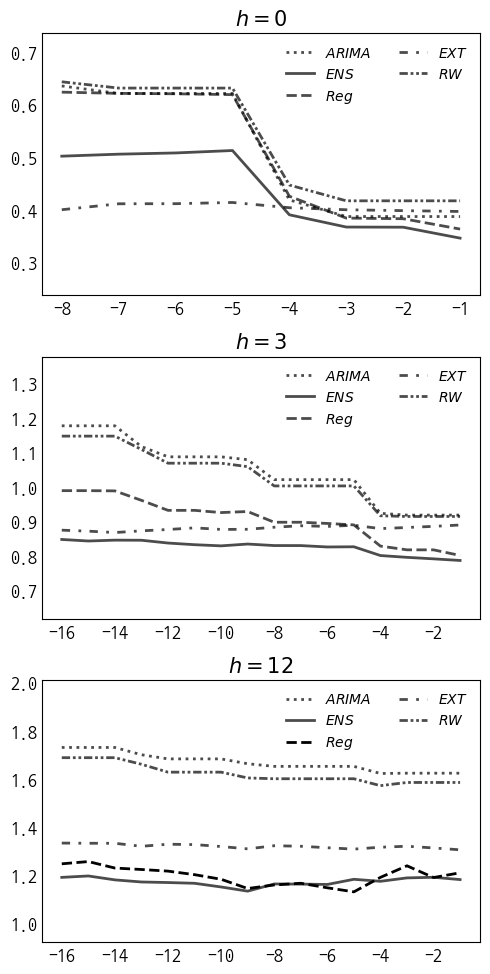

In [274]:
plot_rmse(arima_rmse, ens_rmsef, lm_rmsef, ext_rmse, rw_rmse, best=1, good=1, title='', ncol=2, loc='upper right', figsize=(5, 10), 
          bbox_to_anchor=(1, 1), fontsize=10)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


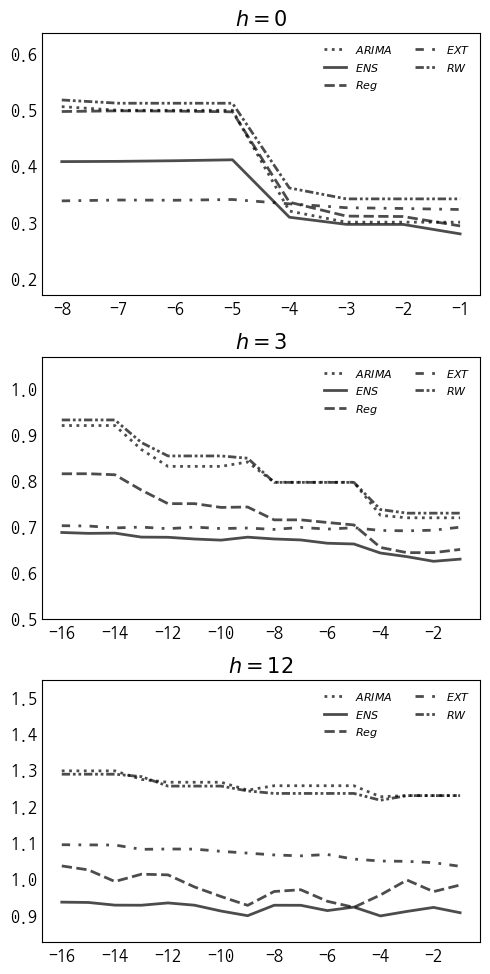

In [275]:
plot_mae(arima_mae, ens_maef, lm_maef, ext_mae, rw_mae, best=1, good=1, title='', ncol=2, loc='upper right', figsize=(5, 10), 
          bbox_to_anchor=(0.7, 0.8), fontsize=8)

# Plot MAE/RMSE

(MAE) arima_p3_q1_r3: 0.298 
(RMSE) arima_p3_q1_r3: 0.386 
rw: 0.340 

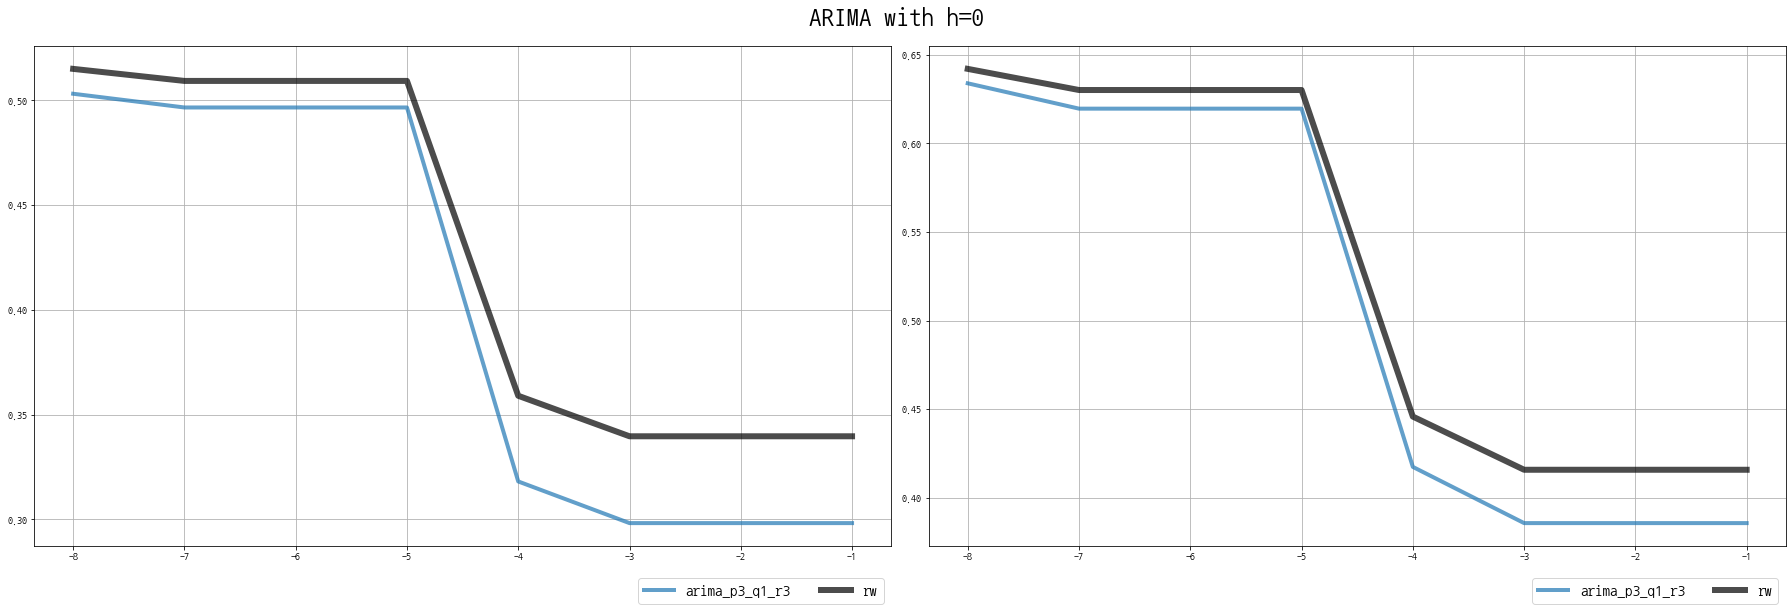

In [44]:
plot_mae_rmse(arima_mae, arima_rmse, rw_mae, rw_rmse, h=0, best=5, good=10, title='ARIMA',
              loc=1, ncol=4, figsize=(25, 8), fontsize=15, bbox_to_anchor=(1, -0.05))

(MAE) arima_p3_q1_r3: 0.718 arima_p2_q1_r3: 0.726 arima_p3_q1_r2: 0.740 arima_p3_q2_r3: 0.746 arima_p2_q2_r3: 0.746 
(RMSE) arima_p2_q1_r3: 0.901 arima_p3_q1_r2: 0.915 arima_p3_q1_r3: 0.917 arima_p3_q2_r3: 0.926 arima_p2_q2_r3: 0.927 
rw: 0.727 

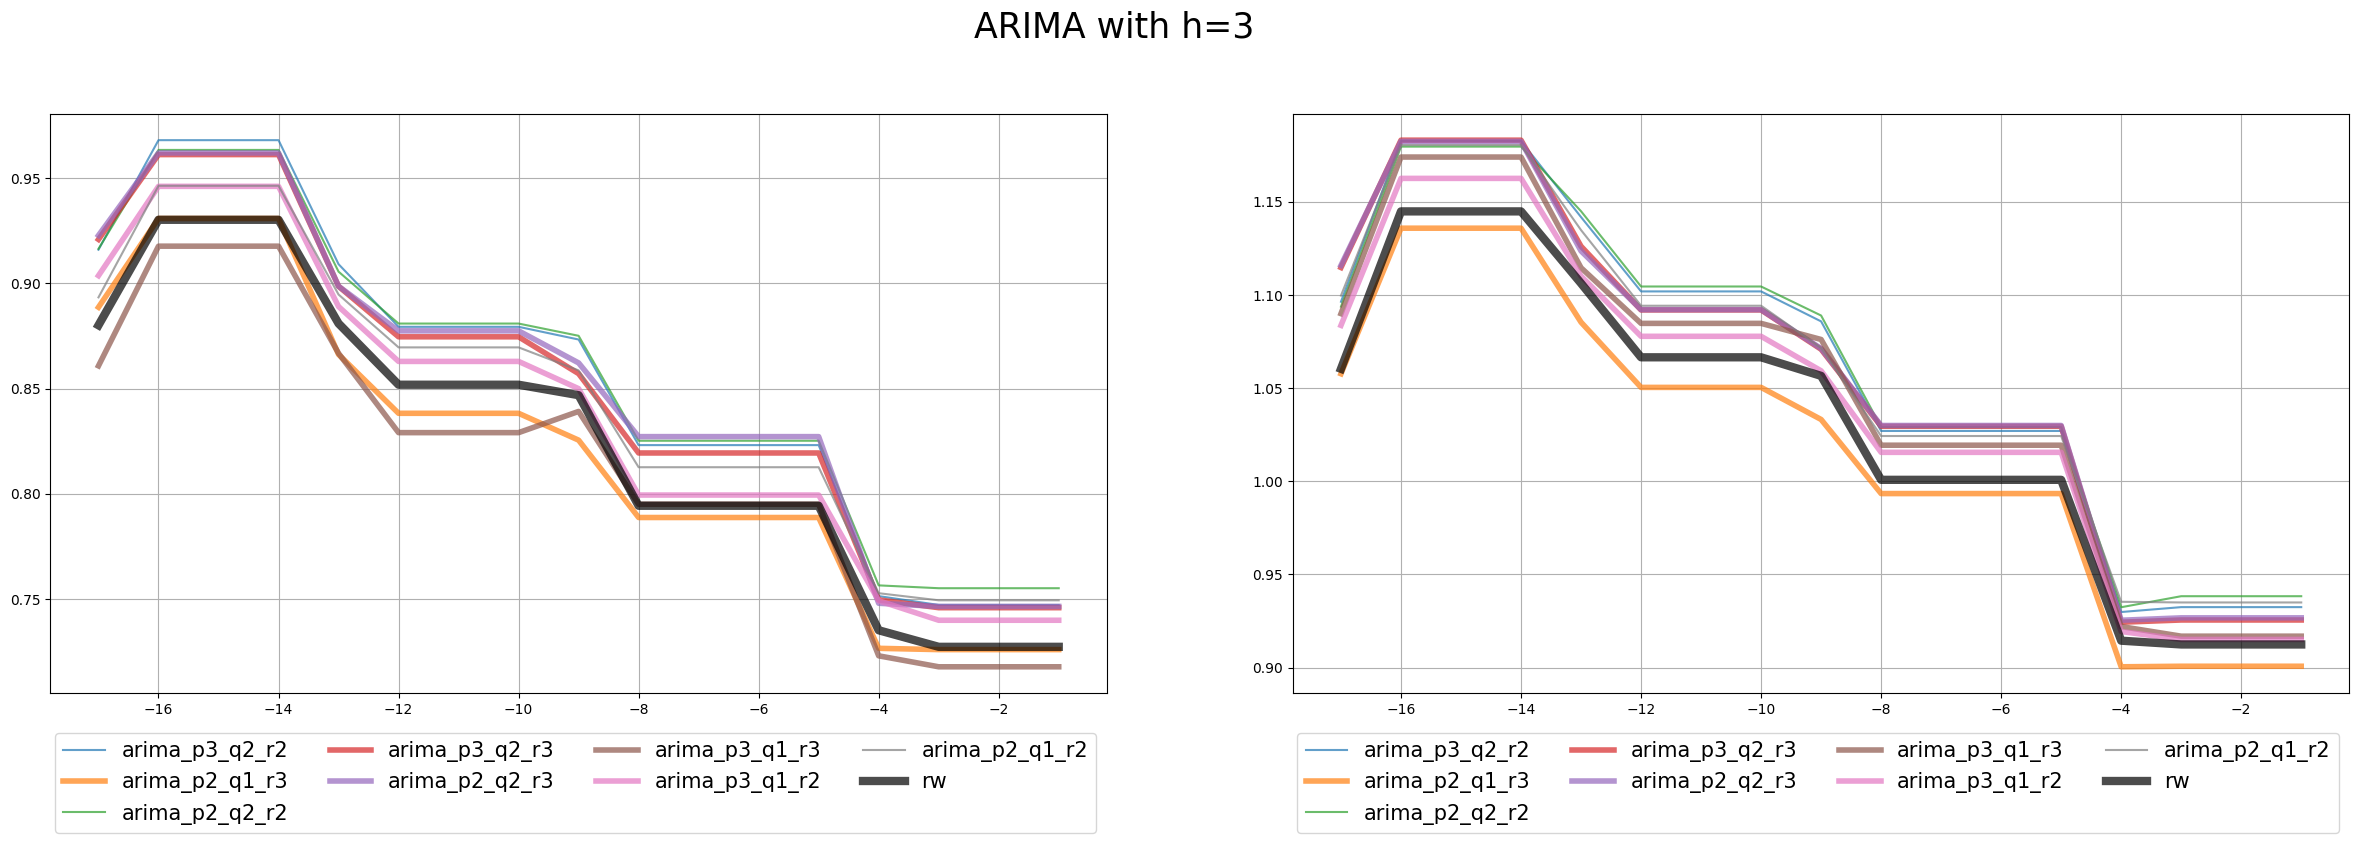

In [ ]:
plot_mae_rmse(arima_mae, arima_rmse, rw_mae, rw_rmse, h=3, best=5, good=10, title='ARIMA',
              loc=1, ncol=4, figsize=(25, 8), fontsize=15, bbox_to_anchor=(1, -0.05))

(MAE) arima_p2_q1_r3: 1.217 arima_p3_q1_r3: 1.226 arima_p2_q1_r2: 1.237 arima_p3_q1_r2: 1.241 arima_p2_q2_r3: 1.335 
(RMSE) arima_p2_q1_r3: 1.576 arima_p2_q1_r2: 1.599 arima_p3_q1_r2: 1.607 arima_p3_q1_r3: 1.622 arima_p2_q2_r3: 1.717 
rw: 1.226 

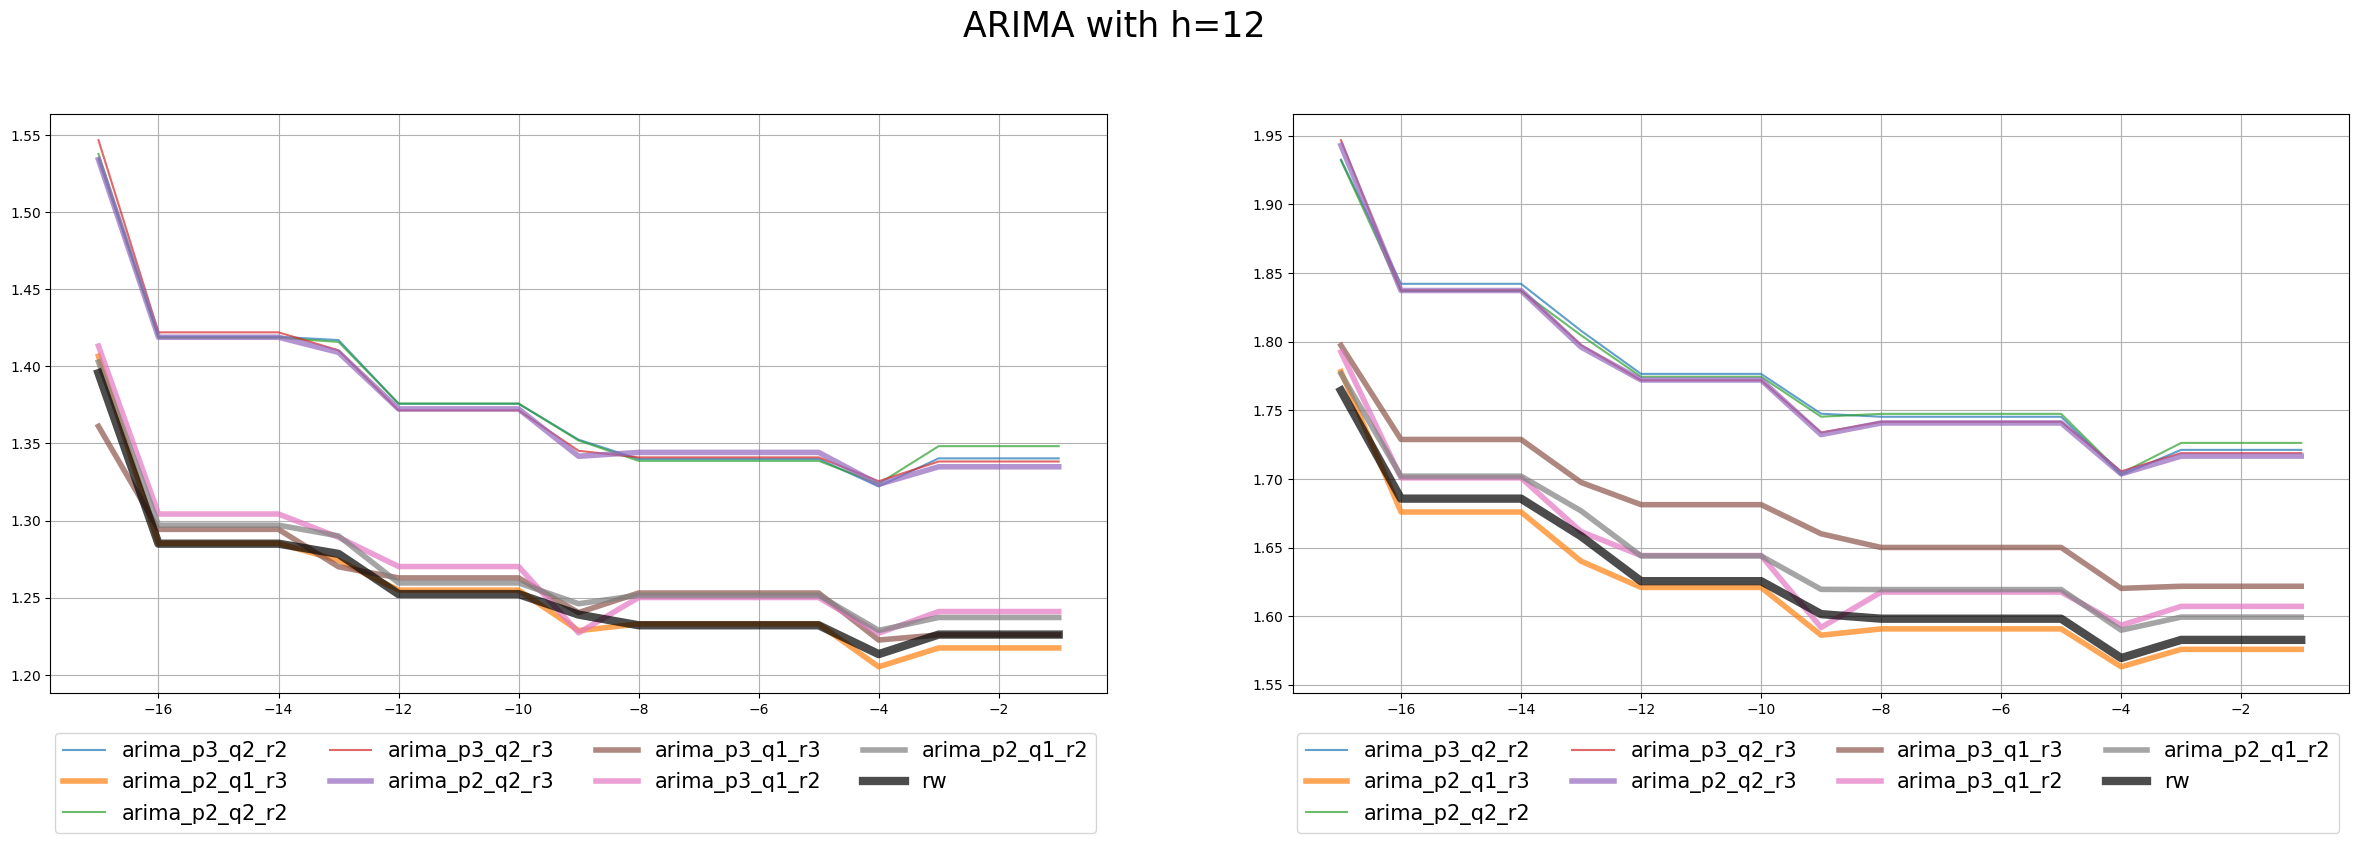

In [ ]:
plot_mae_rmse(arima_mae, arima_rmse, rw_mae, rw_rmse, h=12, best=5, good=10, title='ARIMA',
              loc=1, ncol=4, figsize=(25, 8), fontsize=15, bbox_to_anchor=(1, -0.05))

## LM

(MAE) lm_roll0_lag4_modelL_eap_10:P_adm:P_cpi_1:P_eir:GB_cp_3: 0.289 lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3: 0.291 lm_roll0_lag6_modelL_eap_10:P_adm:P_cpi_1:P_eir:GB_cp_3: 0.292 lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3: 0.292 lm_roll0_lag4_modelL_eap_10:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 0.294 
(RMSE) lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3: 0.362 lm_roll0_lag4_modelL_eap_10:P_adm:P_cpi_1:P_eir:GB_cp_3: 0.363 lm_roll0_lag4_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3: 0.371 lm_roll0_lag4_modelL_eap_10:P_cpi_1:P_eir:GB_cp_3: 0.372 lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3: 0.372 
rw: 0.340 

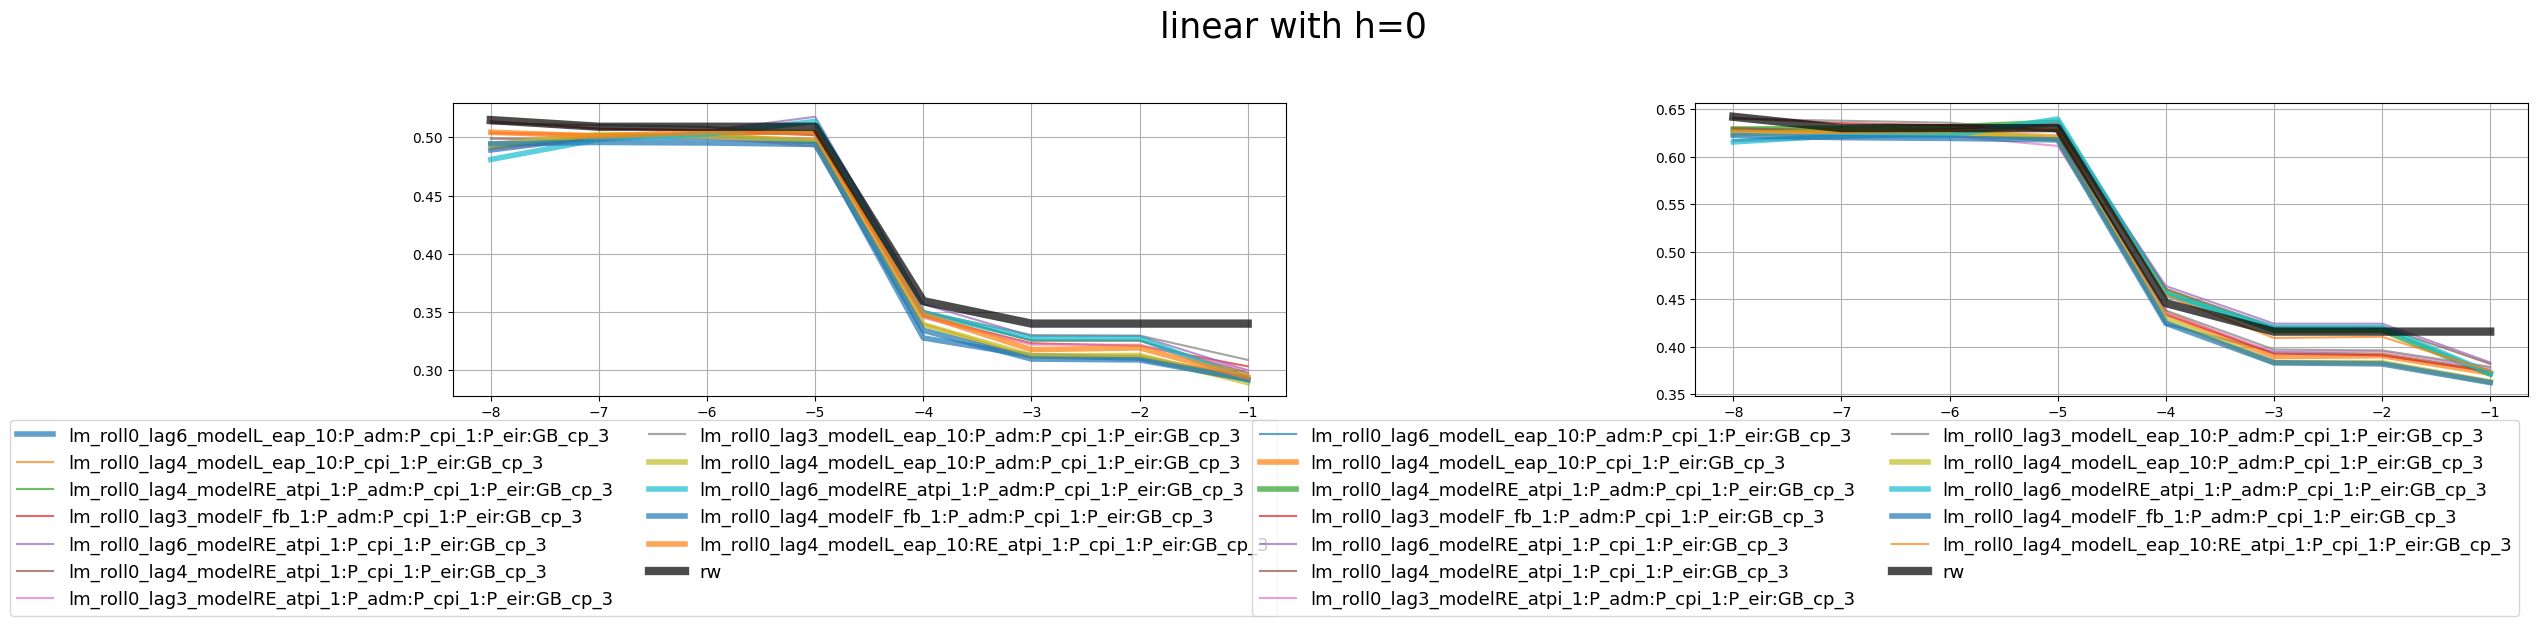

In [ ]:
plot_mae_rmse(lm_mae, lm_rmse, rw_mae, rw_rmse, h=0, best=5, good=10, title='linear',
              loc=1, ncol=2, figsize=(25, 6), fontsize=13, bbox_to_anchor=(1, -0.05))

(MAE) lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 0.648 lm_roll0_lag3_modelL_eap_10:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 0.656 lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 0.667 lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 0.671 lm_roll0_lag3_modelL_eap_10:P_cpi_1:P_eir:GB_cp_3: 0.672 
(RMSE) lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 0.800 lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 0.805 lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 0.810 lm_roll0_lag3_modelL_eap_10:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 0.815 lm_roll0_lag4_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 0.835 
rw: 0.727 

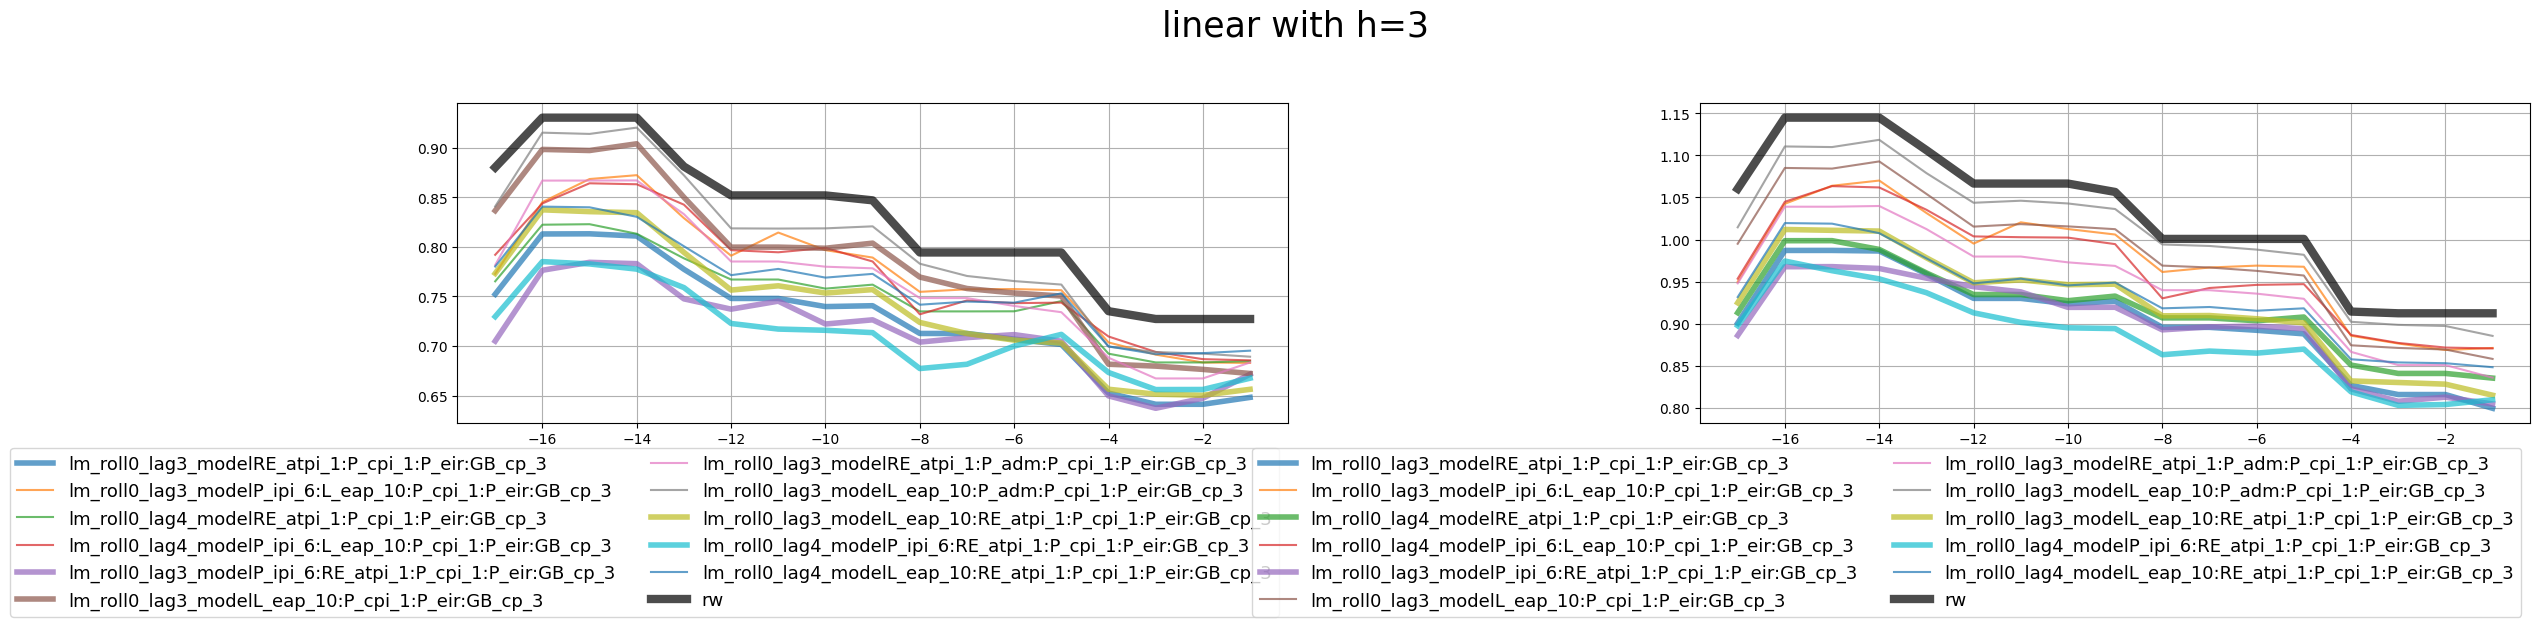

In [ ]:
plot_mae_rmse(lm_mae, lm_rmse, rw_mae, rw_rmse, h=3, best=5, good=10, title='linear',
              loc=1, ncol=2, figsize=(25, 6), fontsize=13, bbox_to_anchor=(1, -0.05))

(MAE) lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 1.274 lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 1.301 lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 1.334 lm_roll0_lag0_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 1.359 lm_roll0_lag0_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 1.377 
(RMSE) lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 1.504 lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 1.530 lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 1.575 lm_roll0_lag0_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 1.607 lm_roll0_lag0_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3: 1.621 
rw: 1.226 

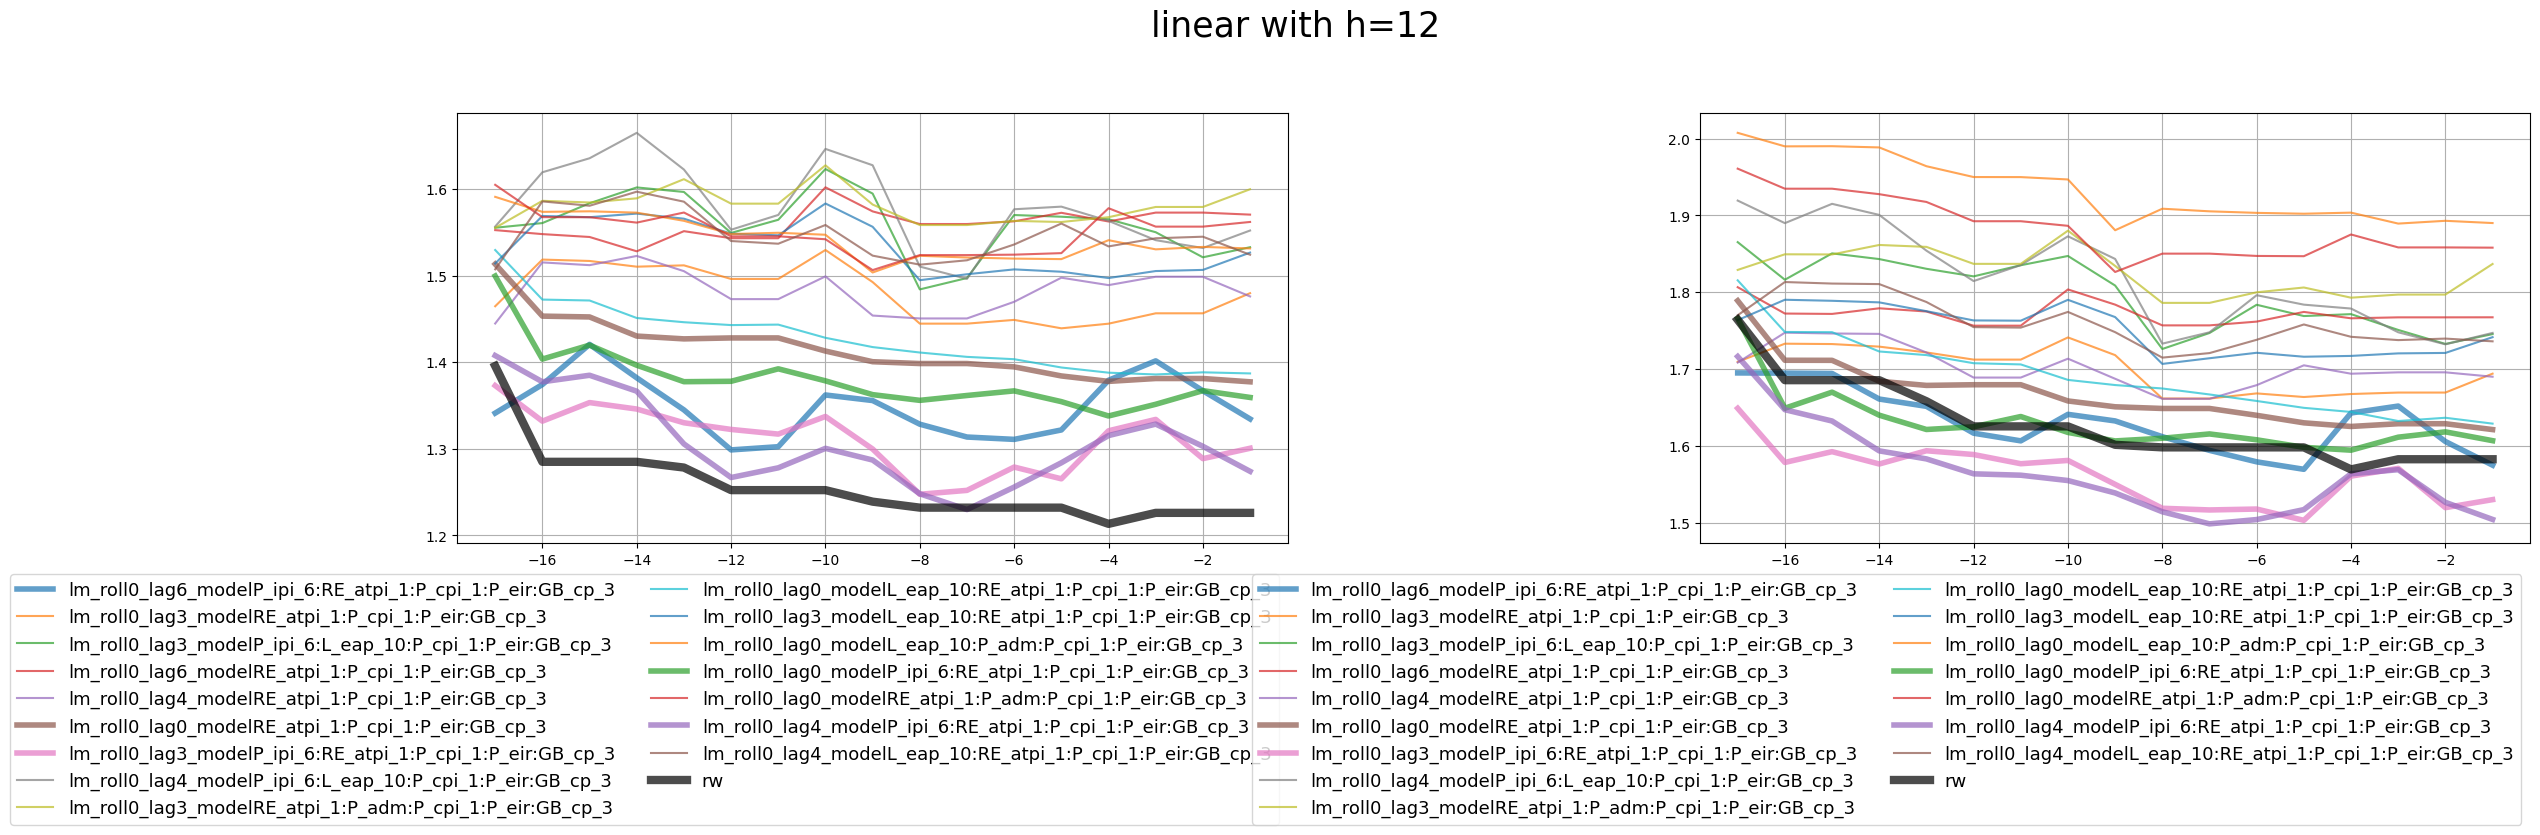

In [ ]:
plot_mae_rmse(lm_mae, lm_rmse, rw_mae, rw_rmse, h=12, best=5, good=15, title='linear',
              loc=1, ncol=2, figsize=(25, 8), fontsize=13, bbox_to_anchor=(1, -0.05))

## EXT

(MAE) ext_roll0_lag0_d8_g1: 0.320 ext_roll0_lag0_d10_g1: 0.322 ext_roll0_lag0_d6_g1: 0.323 ext_roll0_lag0_d8_g2: 0.334 
(RMSE) ext_roll0_lag0_d6_g1: 0.394 ext_roll0_lag0_d8_g1: 0.394 ext_roll0_lag0_d10_g1: 0.398 ext_roll0_lag0_d8_g2: 0.409 
rw: 0.340 

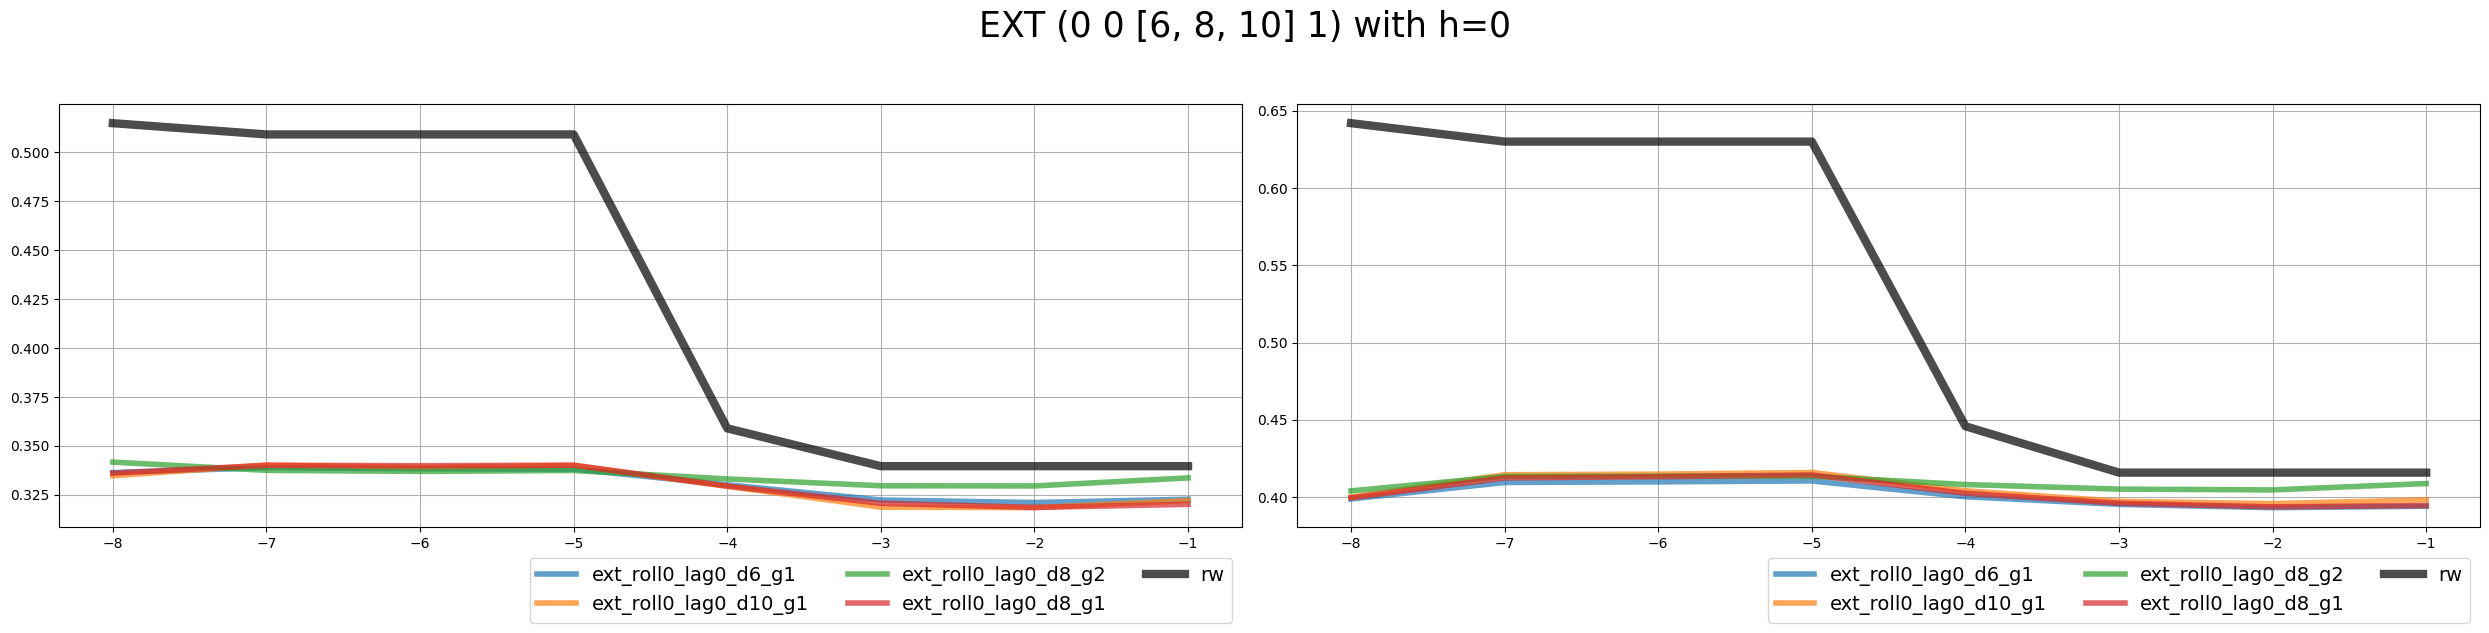

In [ ]:
plot_mae_rmse(ext_mae, ext_rmse, rw_mae, rw_rmse, h=0, best=5, good=10, title='EXT (0 0 [6, 8, 10] 1)',
              loc=1, ncol=3, figsize=(25, 6), fontsize=14, bbox_to_anchor=(1, -0.05))

(MAE) ext_roll0_lag0_d6_g1: 0.698 ext_roll0_lag0_d8_g2: 0.699 ext_roll0_lag0_d10_g1: 0.704 ext_roll0_lag0_d8_g1: 0.708 
(RMSE) ext_roll0_lag0_d6_g1: 0.892 ext_roll0_lag0_d8_g2: 0.894 ext_roll0_lag0_d10_g1: 0.895 ext_roll0_lag0_d8_g1: 0.902 
rw: 0.727 

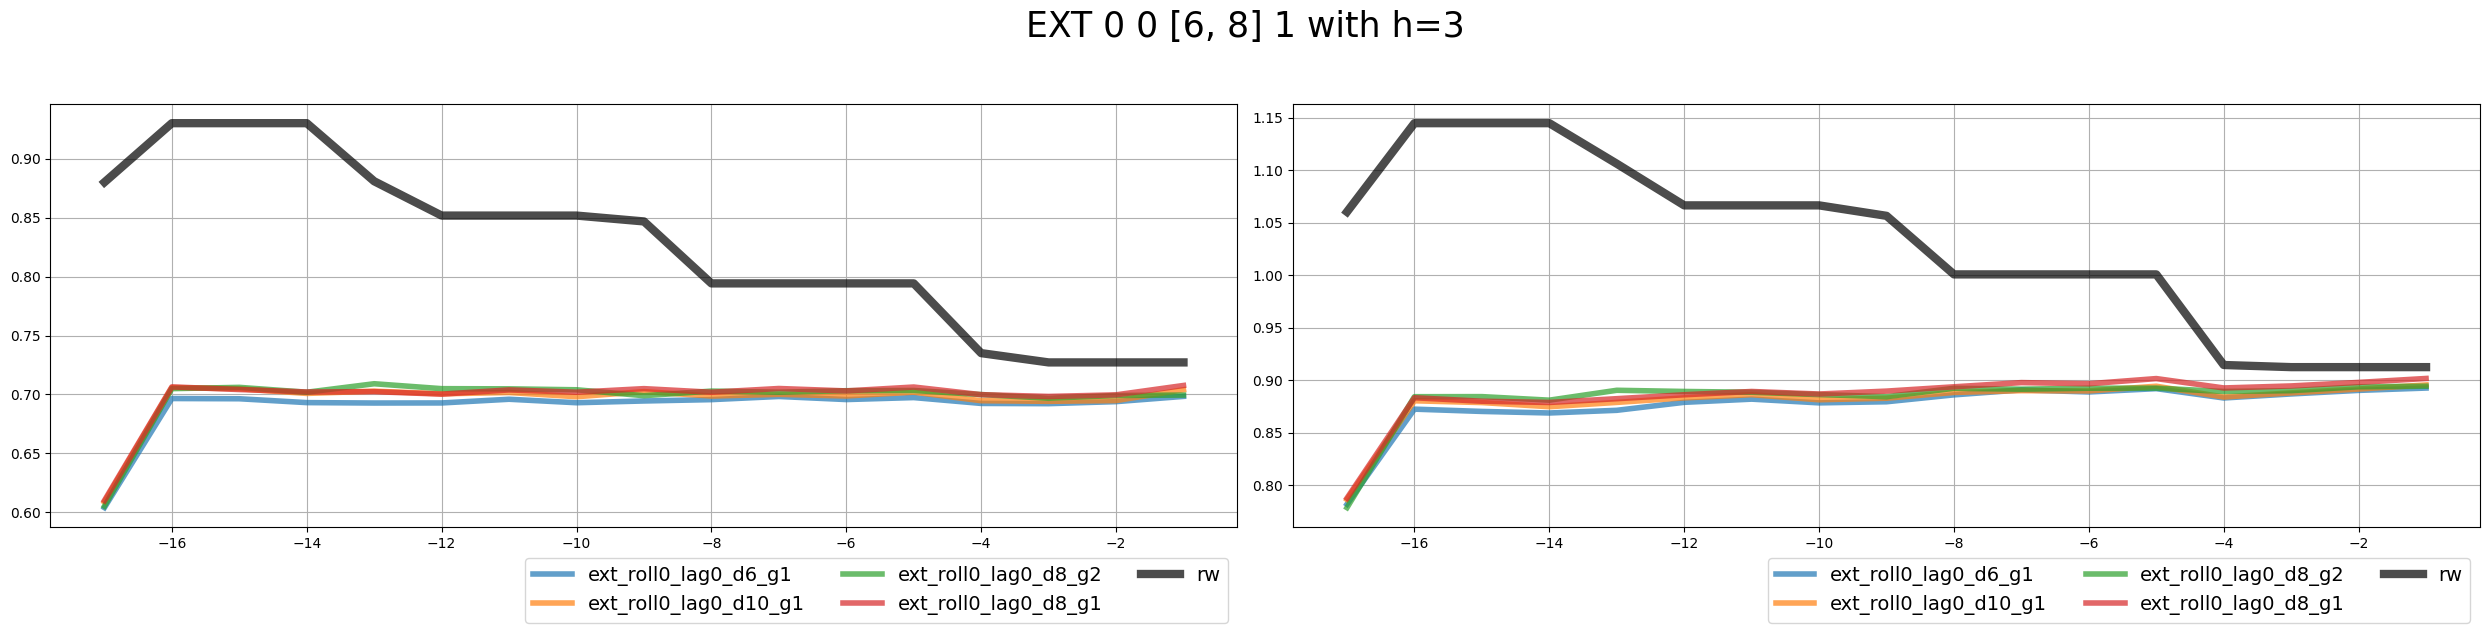

In [ ]:
plot_mae_rmse(ext_mae, ext_rmse, rw_mae, rw_rmse, h=3, best=5, good=10, title='EXT 0 0 [6, 8] 1',
              loc=1, ncol=3, figsize=(25, 6), fontsize=14, bbox_to_anchor=(1, -0.05))

(MAE) ext_roll0_lag0_d10_g1: 1.030 ext_roll0_lag0_d8_g2: 1.041 ext_roll0_lag0_d8_g1: 1.043 ext_roll0_lag0_d6_g1: 1.052 
(RMSE) ext_roll0_lag0_d8_g2: 1.284 ext_roll0_lag0_d10_g1: 1.313 ext_roll0_lag0_d8_g1: 1.334 ext_roll0_lag0_d6_g1: 1.339 
rw: 1.226 

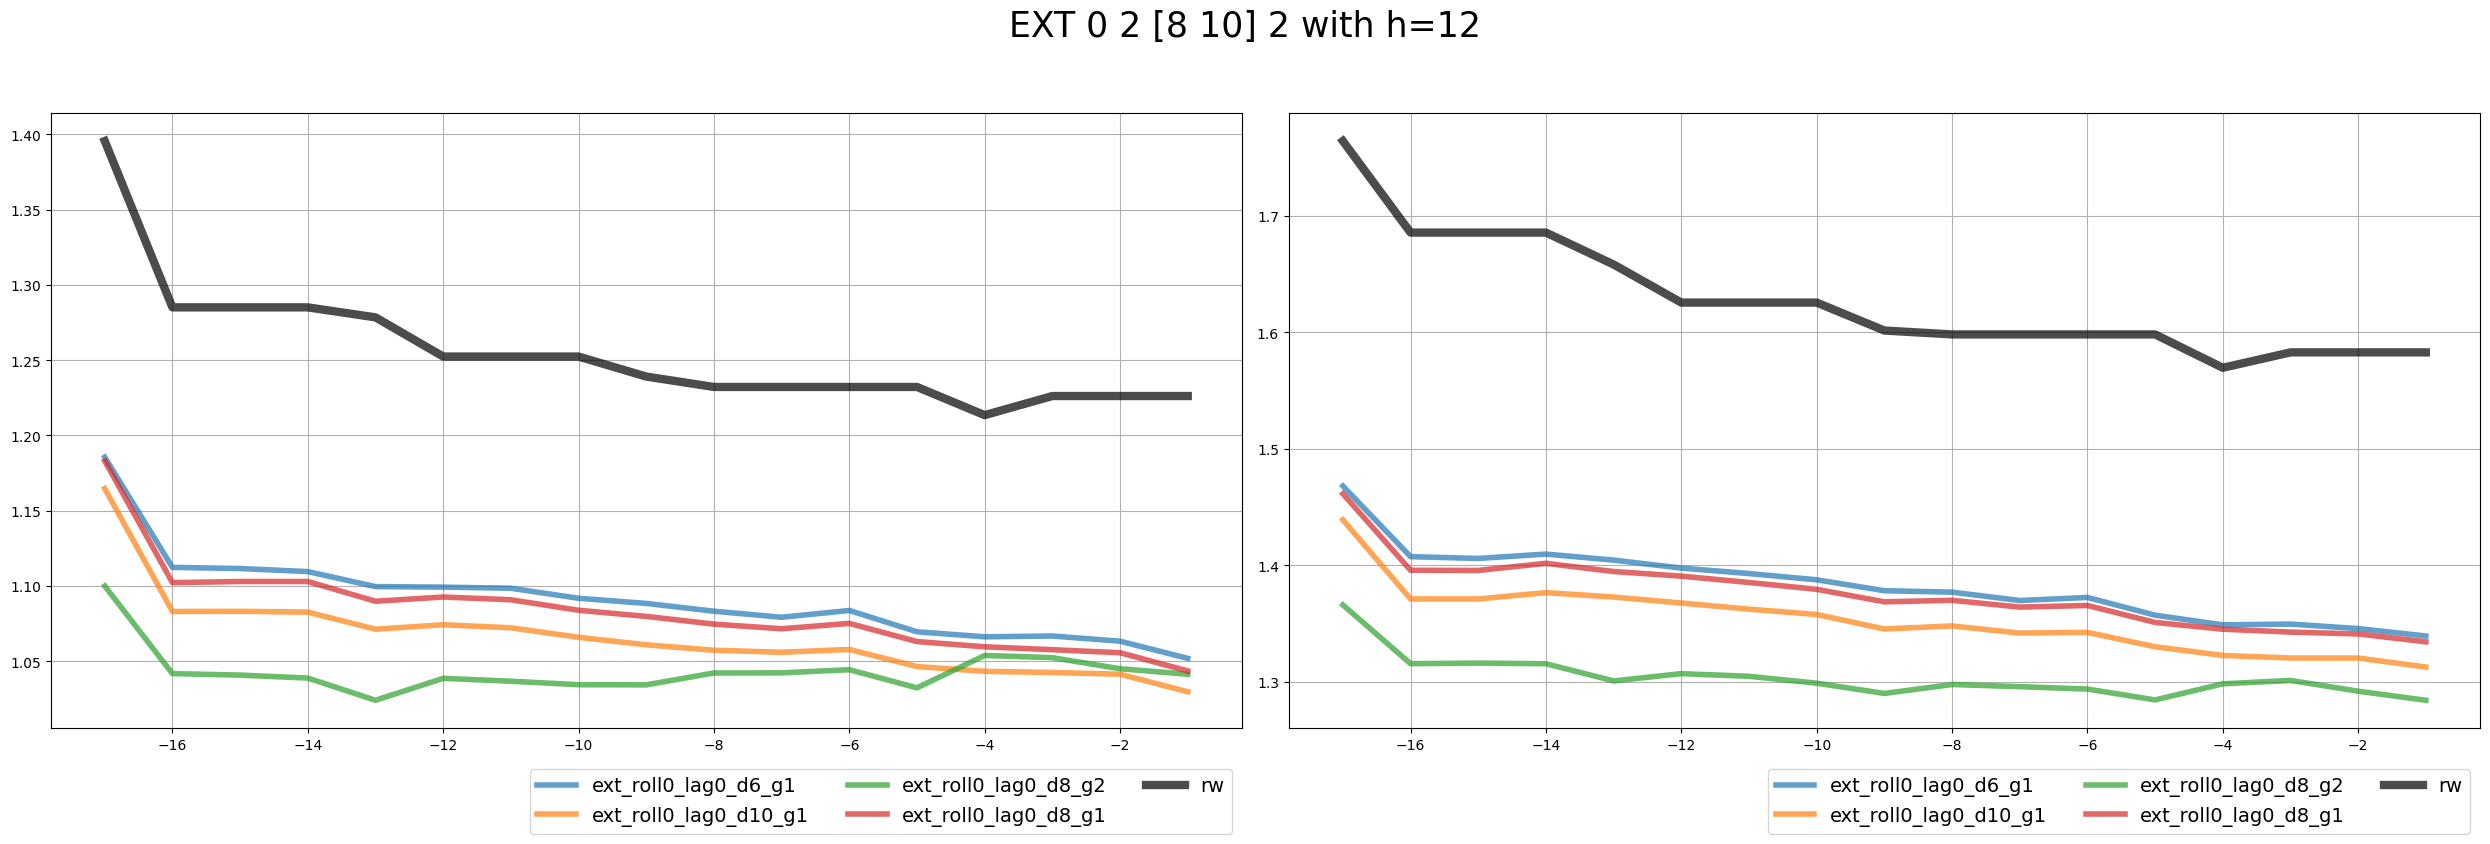

In [ ]:
 plot_mae_rmse(ext_mae, ext_rmse, rw_mae, rw_rmse, h=12, best=5, good=10, title='EXT 0 2 [8 10] 2',
              loc=1, ncol=3, figsize=(25, 8), fontsize=14, bbox_to_anchor=(1, -0.05))

## Ensemble

(MAE) ens697: 0.276 ens201: 0.276 ens685: 0.277 ens273: 0.277 ens541: 0.277 
(RMSE) ens693: 0.344 ens201: 0.344 ens695: 0.344 ens217: 0.345 ens203: 0.345 
rw: 0.340 

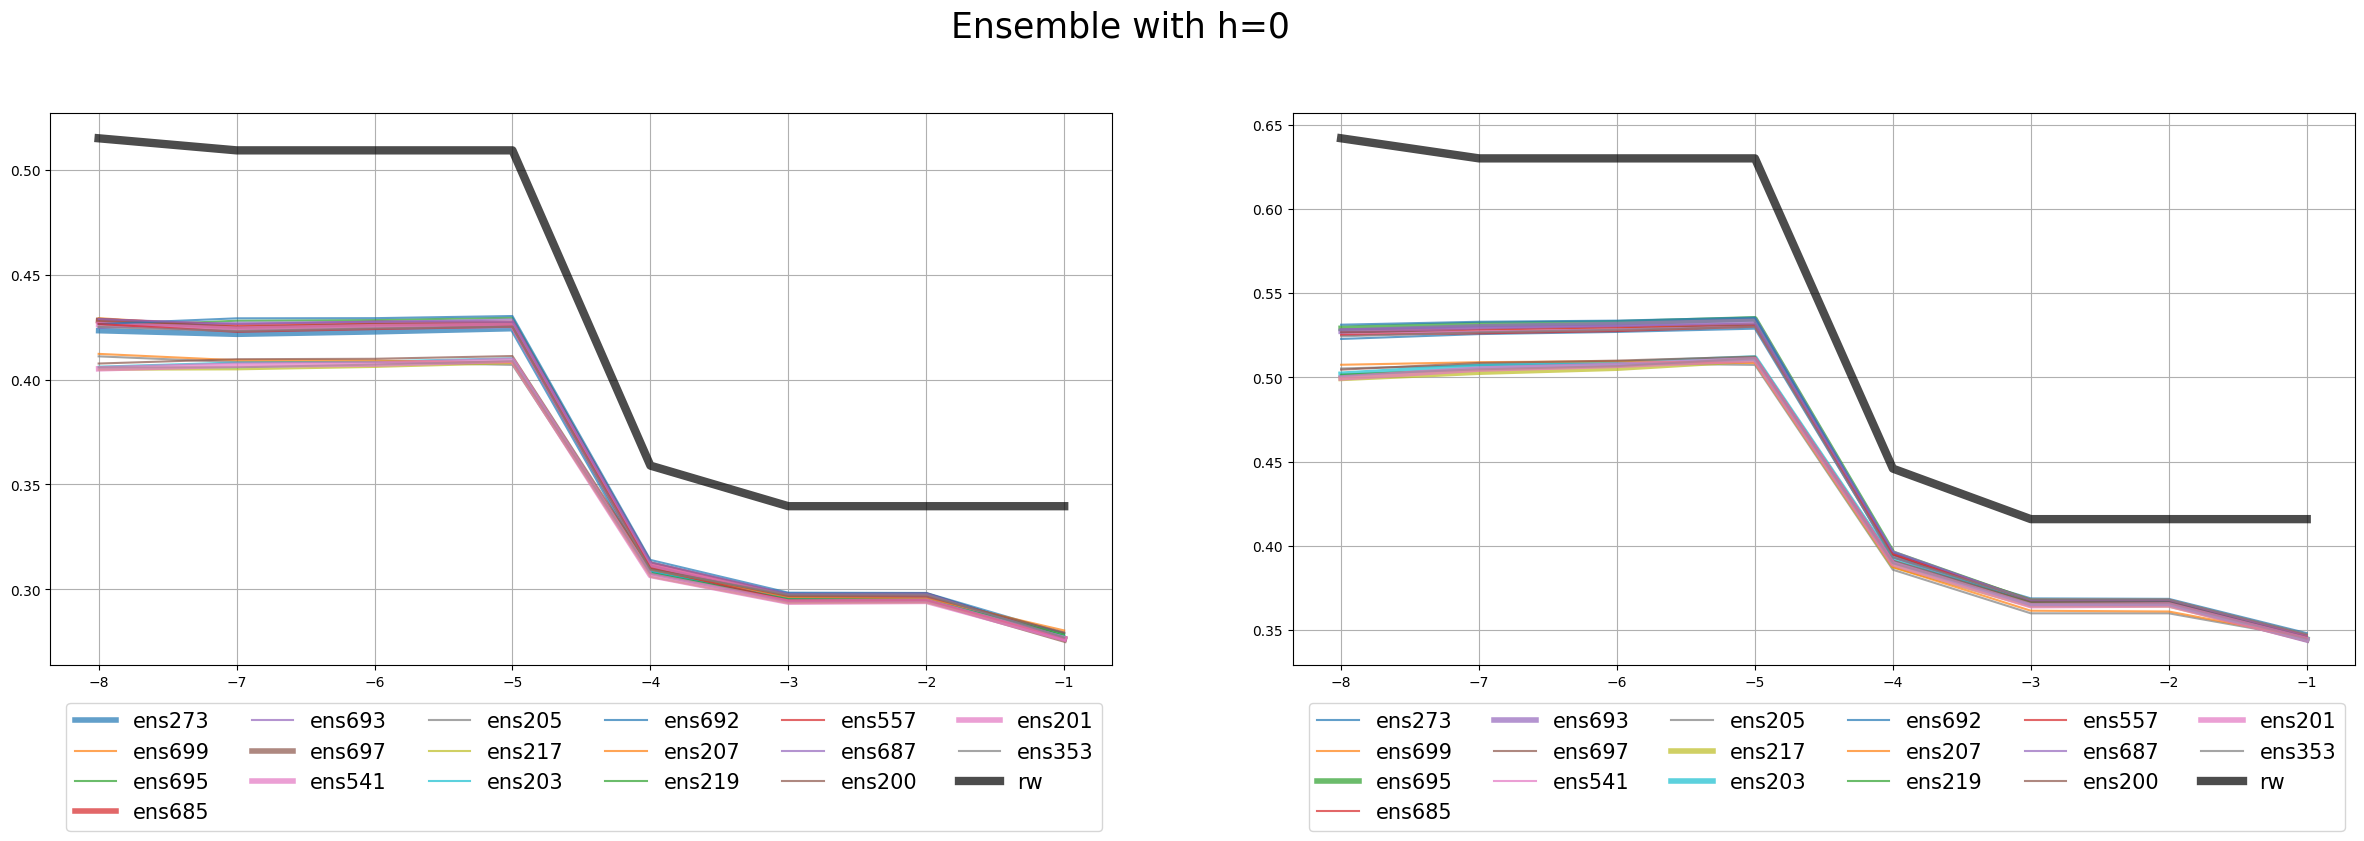

In [ ]:
plot_mae_rmse(ens_mae, ens_rmse, rw_mae, rw_rmse, h=0, best=5, good=10, title='Ensemble',
              loc=1, ncol=6, figsize=(25, 8), fontsize=15, bbox_to_anchor=(1, -0.05))

In [ ]:
for i in [273, 685, 697, 541, 201, 695, 693, 217, 203]:
    print(i, '    '.join(ens_models[i]))

273 lm_roll0_lag6_modelL_eap_10:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d10_g1
685 lm_roll0_lag4_modelL_eap_10:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag3_modelL_eap_10:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d10_g1
697 lm_roll0_lag3_modelL_eap_10:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d10_g1
541 lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag4_modelL_eap_10:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d10_g1
201 lm_roll0_lag4_modelL_eap_10:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d10_g1
695 lm_roll0_lag4_modelL_eap_10:P_adm:P_cpi

(MAE) ens169: 0.626 ens113: 0.627 ens168: 0.627 ens112: 0.628 ens17: 0.628 
(RMSE) ens77: 0.780 ens373: 0.780 ens374: 0.780 ens372: 0.780 ens78: 0.780 
rw: 0.727 

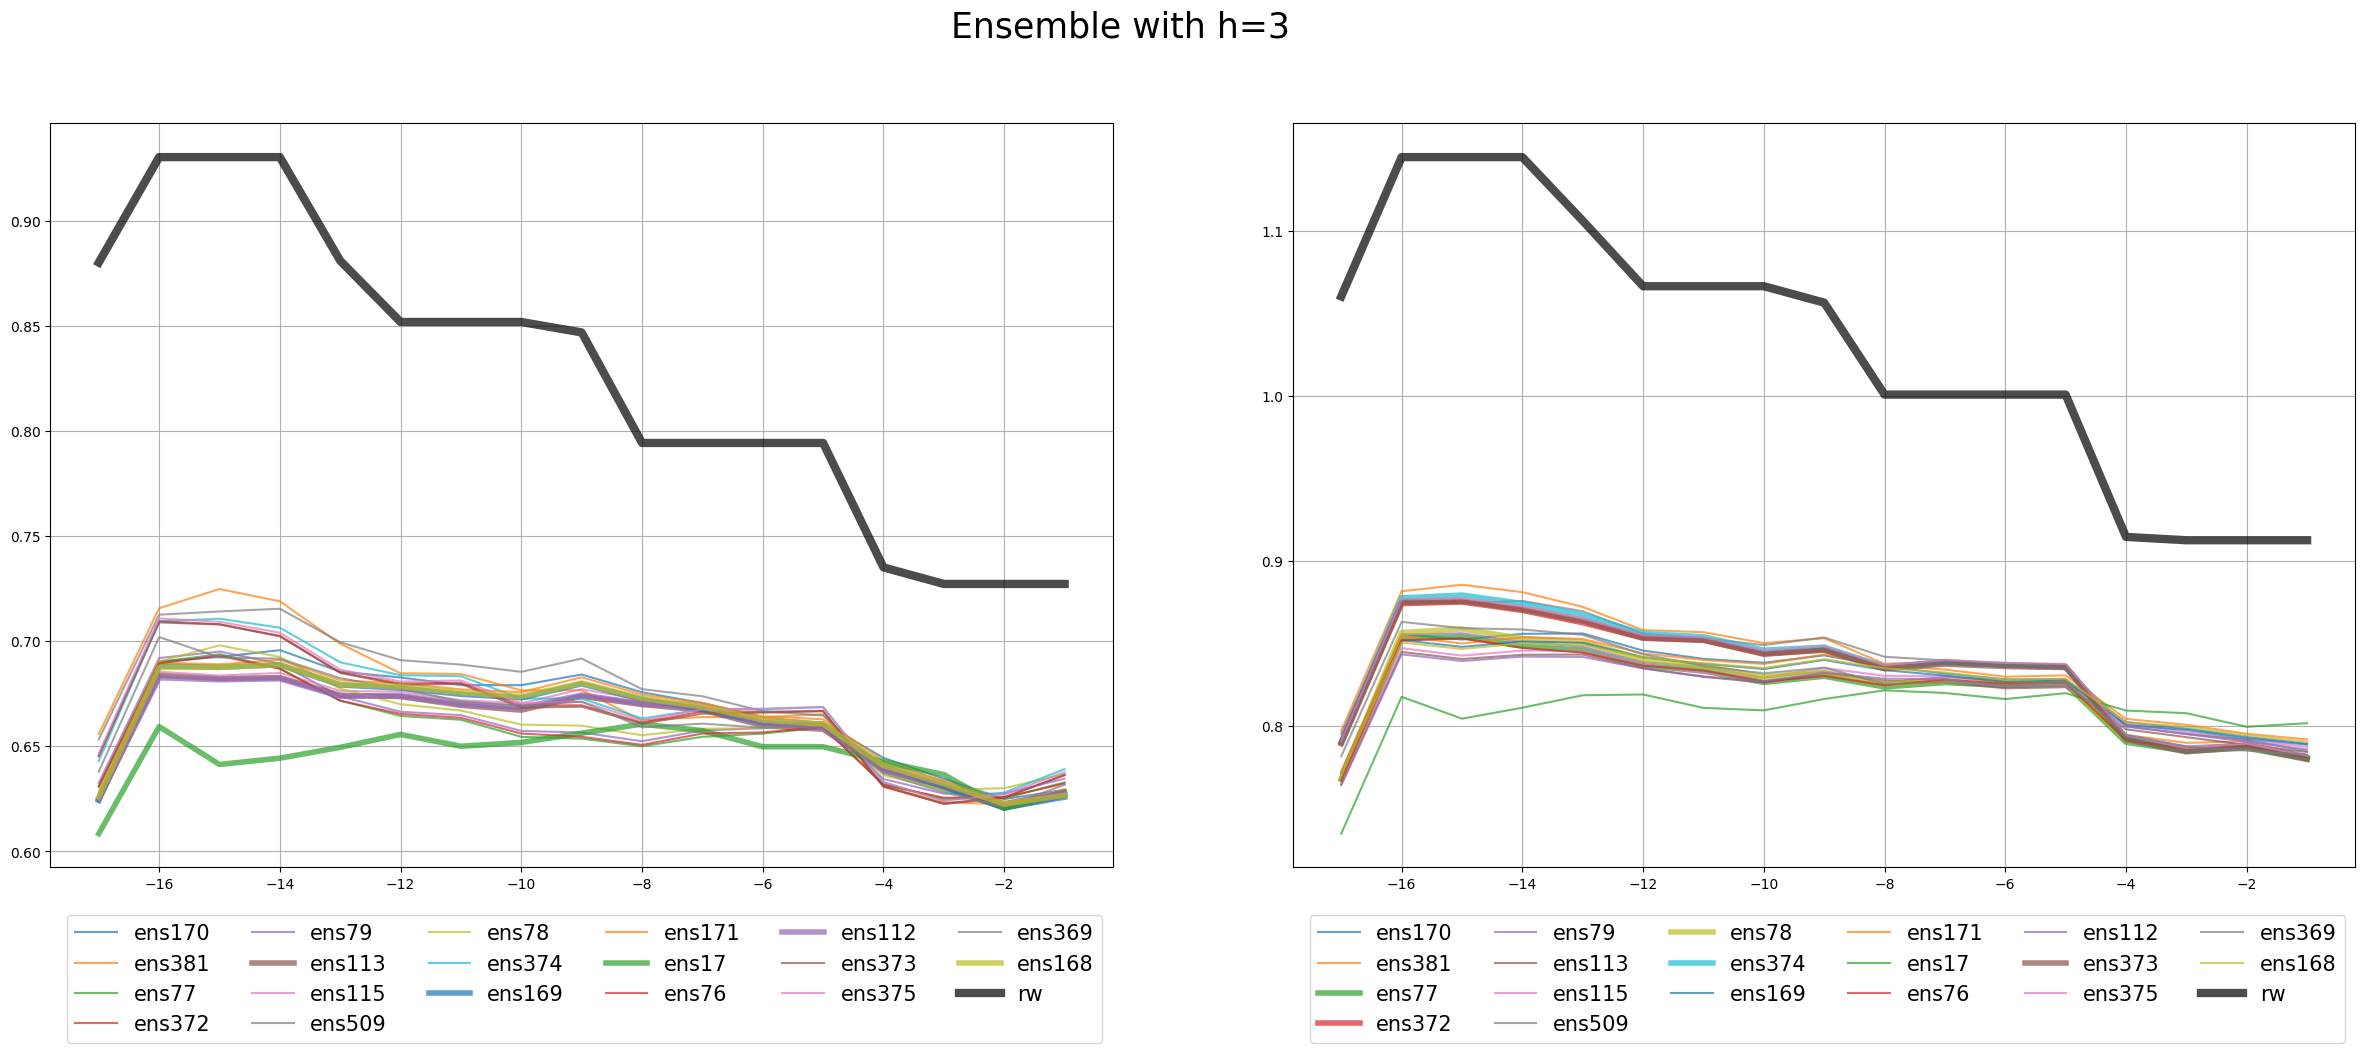

In [ ]:
plot_mae_rmse(ens_mae, ens_rmse, rw_mae, rw_rmse, h=3, best=5, good=10, title='Ensemble',
              loc=1, ncol=6, figsize=(25, 10), fontsize=15, bbox_to_anchor=(1, -0.05), rw=True)

In [ ]:
for i in [113, 169, 17, 112, 168, 77, 372, 78, 374, 373]: # 324, 327, 1005, 326
    print( i, '    '.join(ens_models[i]))

113 lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d10_g1
169 lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag3_modelL_eap_10:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d10_g1
17 lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d10_g1
112 lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d6_g1
168 lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag3_modelL_eap_10:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d6_g1
77 lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d10_g1
372 lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_ro

(MAE) ens5: 0.958 ens6: 0.961 ens7: 0.961 ens4: 0.962 ens21: 0.965 
(RMSE) ens6: 1.122 ens5: 1.125 ens4: 1.131 ens7: 1.131 ens22: 1.144 
rw: 1.226 

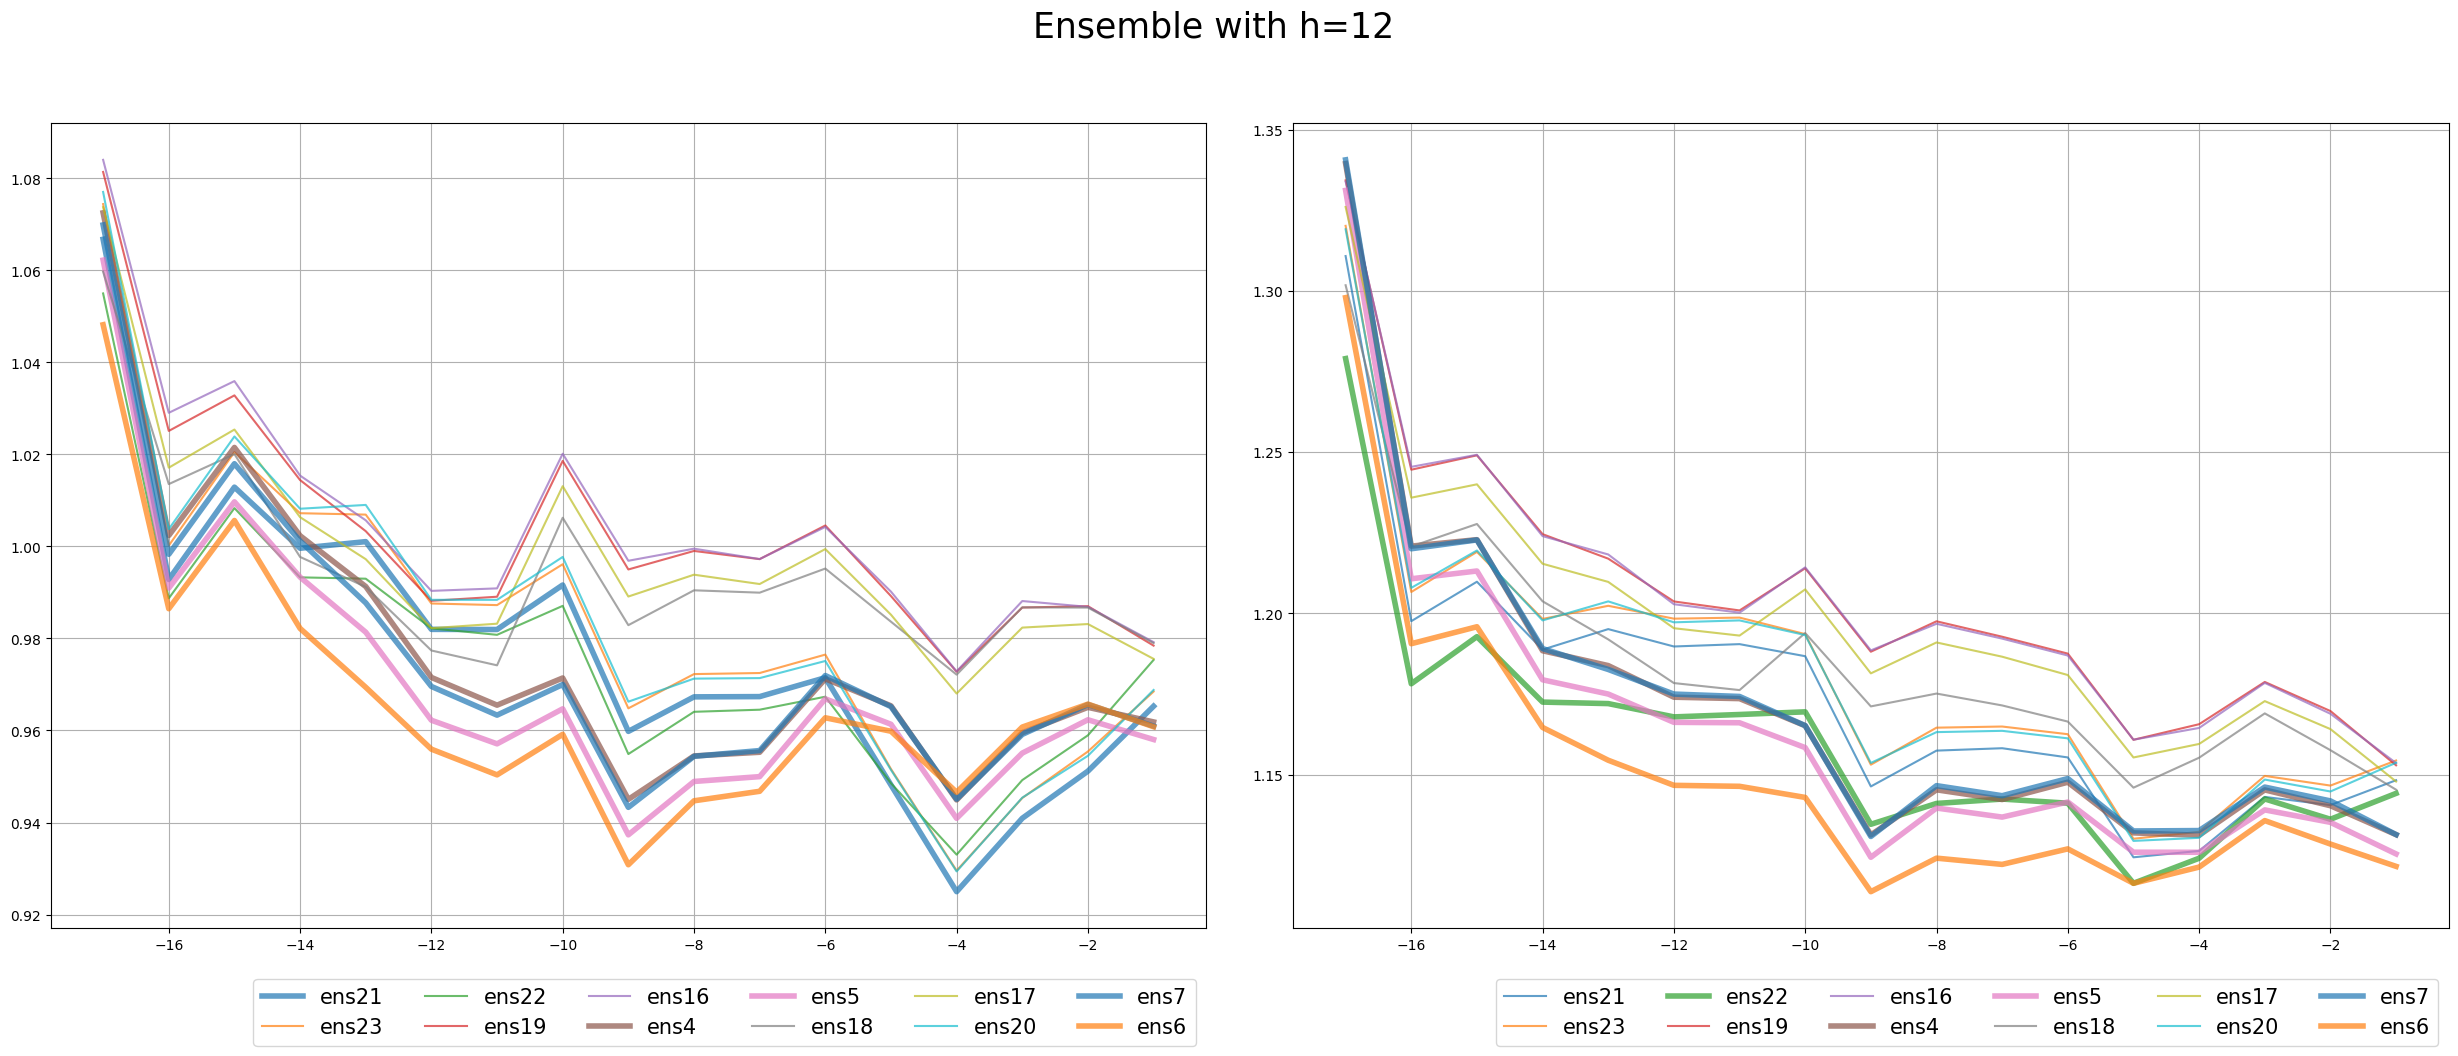

In [ ]:
plot_mae_rmse(ens_mae, ens_rmse, rw_mae, rw_rmse, h=12, best=5, good=10, title='Ensemble',
              loc=1, ncol=6, figsize=(25, 10), fontsize=15, bbox_to_anchor=(1, -0.05), rw=False)

In [ ]:
for i in [21, 4, 5, 6, 7, 22]: # 8, 11, 9, 10,
    print(i, '    '.join(ens_models[i]))

35 lm_r0_l3_mP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_di_r0_l0_d10_dn1
8 lm_r0_l4_mP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_di_r0_l0_d8_dn2
11 lm_r0_l4_mP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_di_r0_l0_d10_dn1
9 lm_r0_l4_mP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_di_r0_l0_d8_dn1
10 lm_r0_l4_mP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_di_r0_l0_d6_dn1
32 lm_r0_l3_mP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_di_r0_l0_d8_dn2


In [255]:
ens_rmsef.iloc[:,-1].mean()/rw_rmse.iloc[:,-1].mean() #rmse ratio

0.7232485912515226

# MDA

In [152]:
ens_pred = ens_pred.sort_index(axis=1)
lm_pred = lm_pred.sort_index(axis=1)
ext_pred = ext_pred.sort_index(axis=1)

In [169]:
tm16 = '2016-1-31'
tm19 = '2019-1-31'
tm20 = '2020-1-31'
tm21 = '2021-1-31'
tm22 = '2022-1-31'
tm99 = '2023-9-30'

In [154]:
for h in [0, 3, 12]:
    matched, mda, mda, p1, p2 = get_mda(rw_pred_last.loc[tm16:tm99, h], act, h, print_result=True)

mda: 0.00 (0/92), mda_big: 0.00 (0/33, 0.42) 
mda: 0.00 (0/89), mda_big: 0.00 (0/27, 0.93) 
mda: 0.00 (0/80), mda_big: 0.00 (0/27, 1.63) 


In [155]:
for h in [0, 3, 12]:
    matched, mda, mda, p1, p2 = get_mda(rw_pred_last.loc[tm21:tm99, h], act, h, print_result=True)

mda: 0.00 (0/32), mda_big: 0.00 (0/15, 0.46) 
mda: 0.00 (0/29), mda_big: 0.00 (0/9, 1.18) 
mda: 0.00 (0/20), mda_big: 0.00 (0/12, 2.33) 


In [ ]:
arima_models = ['arima_p2_q1_r3', 'arima_p3_q1_r3']
for h in [0, 3, 12]:
    mae, rmse, pred_last = get_eval_last_pred(arima_pred.loc[:, idx[arima_models, :, tm16:tm99]], arima_models, act)
    best = mae[h].loc[-1].sort_values().iloc[:1].index.tolist()
    best += rmse[h].loc[-1].sort_values().iloc[:1].index.tolist()
    best = list(set(best))
    for i in best:
        matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=True)

  0%|          | 0/2 [00:00<?, ?it/s]

2016-1-31 - 2023-10-31
mda: 0.75 (69/92), mda_big: 0.67 (22/33, 0.42) arima_p3_q1_r3


  0%|          | 0/2 [00:00<?, ?it/s]

2016-1-31 - 2023-10-31
mda: 0.57 (51/89), mda_big: 0.70 (19/27, 0.93) arima_p2_q1_r3
mda: 0.56 (50/89), mda_big: 0.70 (19/27, 0.93) arima_p3_q1_r3


  0%|          | 0/2 [00:00<?, ?it/s]

2016-1-31 - 2023-10-31
mda: 0.55 (44/80), mda_big: 0.56 (15/27, 1.63) arima_p2_q1_r3


In [ ]:
arima_models = ['arima_p2_q1_r3', 'arima_p3_q1_r3']
for h in [0, 3, 12]:
    mae, rmse, pred_last = get_eval_last_pred(arima_pred.loc[:, idx[arima_models, :, tm21:tm99]], arima_models, act)
    best = mae[h].loc[-1].sort_values().iloc[:1].index.tolist()
    best += rmse[h].loc[-1].sort_values().iloc[:1].index.tolist()
    best = list(set(best))
    for i in best:
        matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=True)

  0%|          | 0/2 [00:00<?, ?it/s]

mda: 0.69 (22/32), mda_big: 0.60 (9/15, 0.46) arima_p2_q1_r3


  0%|          | 0/2 [00:00<?, ?it/s]

mda: 0.72 (21/29), mda_big: 0.89 (8/9, 1.18) arima_p2_q1_r3


  0%|          | 0/2 [00:00<?, ?it/s]

mda: 0.65 (13/20), mda_big: 0.67 (8/12, 2.33) arima_p2_q1_r3
mda: 0.35 (7/20), mda_big: 0.33 (4/12, 2.33) arima_p3_q1_r3


## h = 0

In [156]:
ens_mae[0].loc[-1].sort_values().iloc[:10].index.tolist()

['ens67',
 'ens65',
 'ens23',
 'ens75',
 'ens63',
 'ens61',
 'ens73',
 'ens66',
 'ens31',
 'ens21']

In [170]:
ens_models[23]

['lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3',
 'lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3',
 'ext_roll0_lag0_d10_g1']

In [199]:
#models = ['ens' + str(i) for i in [275, 281, 53, 233, 230, 149, 65, 260, 257]]

#for i in [int(m[3:]) for m in models]:
#    print(i, '    '.join(ens_models[i]))

275 lm_roll0_lag4_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag6_modelL_eap_10:P_adm:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d6_g1
281 lm_roll0_lag4_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag6_modelL_eap_10:P_adm:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d8_g2
53 lm_roll0_lag4_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d8_g2
233 lm_roll0_lag4_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag4_modelL_eap_10:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d8_g2
230 lm_roll0_lag4_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d8_g1
149 lm_roll0_lag4_modelF_fb_1:P_adm:P_cp

In [171]:
models = ['ens' + str(i) for i in [23]]

for i in [int(m[3:]) for m in models]:
    print(i, '    '.join(ens_models[i]))

23 lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d10_g1


In [172]:
h=0
M0 = tm16
M1 = tm21
topN = 10

mae, rmse, pred_last = get_eval_last_pred(ens_pred.loc[:, idx[models, :, M0:M1]], models, act)
best = mae[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

mae, rmse, pred_last = get_eval_last_pred(lm_pred.loc[:, idx[lm_best_for_ensemble, :, M0:M1]], lm_best_for_ensemble, act)

best = mae[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

M0 = tm21
M1 = tm99
mae, rmse, pred_last = get_eval_last_pred(ens_pred.loc[:, idx[models, :, M0:M1]], models, act)
best = mae[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

mae, rmse, pred_last = get_eval_last_pred(lm_pred.loc[:, idx[lm_best_for_ensemble, :, M0:M1]], lm_best_for_ensemble, act)
best = mae[h].loc[-1].sort_values().iloc[:5].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:5].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")
M0 = tm16
M1 = tm99
mae, rmse, pred_last = get_eval_last_pred(ens_pred.loc[:, idx[models, :, M0:M1]], models, act)
best = mae[h].loc[-1].sort_values().iloc[:5].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:5].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

mae, rmse, pred_last = get_eval_last_pred(lm_pred.loc[:, idx[lm_best_for_ensemble, :, M0:M1]], lm_best_for_ensemble, act)
best = mae[h].loc[-1].sort_values().iloc[:5].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:5].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

  0%|          | 0/1 [00:00<?, ?it/s]

2016-1-31 - 2021-1-31
mae: 0.267, rmse: 0.338 mda: 0.68 (41/60) mda_big: 0.78 (14/18, 0.39) model: ens23


  0%|          | 0/5 [00:00<?, ?it/s]

2016-1-31 - 2021-1-31
mae: 0.309, rmse: 0.372 mda: 0.57 (34/60) mda_big: 0.83 (15/18, 0.39) model: lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.320, rmse: 0.389 mda: 0.62 (37/60) mda_big: 0.61 (11/18, 0.39) model: lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.275, rmse: 0.339 mda: 0.57 (34/60) mda_big: 0.72 (13/18, 0.39) model: lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3
mae: 0.308, rmse: 0.376 mda: 0.58 (35/60) mda_big: 0.67 (12/18, 0.39) model: lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3
mae: 0.295, rmse: 0.370 mda: 0.65 (39/60) mda_big: 0.72 (13/18, 0.39) model: lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3


  0%|          | 0/1 [00:00<?, ?it/s]

2021-1-31 - 2023-9-30
mae: 0.297, rmse: 0.357 mda: 0.75 (24/32) mda_big: 0.93 (14/15, 0.46) model: ens23


  0%|          | 0/5 [00:00<?, ?it/s]

2021-1-31 - 2023-9-30
mae: 0.307, rmse: 0.422 mda: 0.69 (22/32) mda_big: 0.80 (12/15, 0.46) model: lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.281, rmse: 0.392 mda: 0.72 (23/32) mda_big: 0.93 (14/15, 0.46) model: lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.322, rmse: 0.400 mda: 0.78 (25/32) mda_big: 0.87 (13/15, 0.46) model: lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3
mae: 0.323, rmse: 0.412 mda: 0.62 (20/32) mda_big: 0.73 (11/15, 0.46) model: lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3
mae: 0.286, rmse: 0.376 mda: 0.72 (23/32) mda_big: 0.87 (13/15, 0.46) model: lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3


  0%|          | 0/1 [00:00<?, ?it/s]

2016-1-31 - 2023-9-30
mae: 0.278, rmse: 0.345 mda: 0.71 (65/92) mda_big: 0.85 (28/33, 0.42) model: ens23


  0%|          | 0/5 [00:00<?, ?it/s]

2016-1-31 - 2023-9-30
mae: 0.308, rmse: 0.391 mda: 0.61 (56/92) mda_big: 0.82 (27/33, 0.42) model: lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.309, rmse: 0.392 mda: 0.65 (60/92) mda_big: 0.76 (25/33, 0.42) model: lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.292, rmse: 0.362 mda: 0.64 (59/92) mda_big: 0.79 (26/33, 0.42) model: lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3
mae: 0.315, rmse: 0.391 mda: 0.60 (55/92) mda_big: 0.70 (23/33, 0.42) model: lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3
mae: 0.291, rmse: 0.372 mda: 0.67 (62/92) mda_big: 0.79 (26/33, 0.42) model: lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3


## h = 3

In [171]:
ens_mae[3].loc[-1].sort_values().iloc[:10].index.tolist()

['ens113',
 'ens111',
 'ens12',
 'ens14',
 'ens112',
 'ens362',
 'ens120',
 'ens360',
 'ens13',
 'ens122']

In [173]:
ens_models[51]

['lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3',
 'lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3',
 'ext_roll0_lag0_d10_g1']

In [174]:
models = ['ens' + str(i) for i in [51]]

for i in [int(m[3:]) for m in models]:
    print(i, '    '.join(ens_models[i]))

51 lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3    lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3    ext_roll0_lag0_d10_g1


In [175]:
h=3
M0 = tm16
M1 = tm21
topN = 10

mae, rmse, pred_last = get_eval_last_pred(ens_pred.loc[:, idx[models, :, M0:M1]], models, act)
best = mae[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

mae, rmse, pred_last = get_eval_last_pred(lm_pred.loc[:, idx[lm_best_for_ensemble, :, M0:M1]], lm_best_for_ensemble, act)

best = mae[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

M0 = tm21
M1 = tm99
mae, rmse, pred_last = get_eval_last_pred(ens_pred.loc[:, idx[models, :, M0:M1]], models, act)
best = mae[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

mae, rmse, pred_last = get_eval_last_pred(lm_pred.loc[:, idx[lm_best_for_ensemble, :, M0:M1]], lm_best_for_ensemble, act)
best = mae[h].loc[-1].sort_values().iloc[:5].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:5].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

M0 = tm16
M1 = tm99
mae, rmse, pred_last = get_eval_last_pred(ens_pred.loc[:, idx[models, :, M0:M1]], models, act)
best = mae[h].loc[-1].sort_values().iloc[:5].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:5].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

mae, rmse, pred_last = get_eval_last_pred(lm_pred.loc[:, idx[lm_best_for_ensemble, :, M0:M1]], lm_best_for_ensemble, act)
best = mae[h].loc[-1].sort_values().iloc[:5].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:5].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

  0%|          | 0/1 [00:00<?, ?it/s]

2016-1-31 - 2021-1-31
mae: 0.565, rmse: 0.701 mda: 0.58 (33/57) mda_big: 0.67 (12/18, 0.74) model: ens51


  0%|          | 0/5 [00:00<?, ?it/s]

2016-1-31 - 2021-1-31
mae: 0.614, rmse: 0.776 mda: 0.49 (28/57) mda_big: 0.44 (8/18, 0.74) model: lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.711, rmse: 0.859 mda: 0.58 (33/57) mda_big: 0.61 (11/18, 0.74) model: lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.612, rmse: 0.792 mda: 0.51 (29/57) mda_big: 0.50 (9/18, 0.74) model: lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3
mae: 0.517, rmse: 0.633 mda: 0.65 (37/57) mda_big: 0.72 (13/18, 0.74) model: lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3
mae: 0.816, rmse: 0.991 mda: 0.56 (32/57) mda_big: 0.67 (12/18, 0.74) model: lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3


  0%|          | 0/1 [00:00<?, ?it/s]

2021-1-31 - 2023-9-30
mae: 0.730, rmse: 0.911 mda: 0.76 (22/29) mda_big: 1.00 (9/9, 1.18) model: ens51


  0%|          | 0/5 [00:00<?, ?it/s]

2021-1-31 - 2023-9-30
mae: 0.691, rmse: 0.830 mda: 0.79 (23/29) mda_big: 1.00 (9/9, 1.18) model: lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.818, rmse: 0.991 mda: 0.79 (23/29) mda_big: 1.00 (9/9, 1.18) model: lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.905, rmse: 1.123 mda: 0.72 (21/29) mda_big: 0.67 (6/9, 1.18) model: lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3
mae: 0.758, rmse: 0.888 mda: 0.79 (23/29) mda_big: 1.00 (9/9, 1.18) model: lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3
mae: 0.991, rmse: 1.120 mda: 0.59 (17/29) mda_big: 0.89 (8/9, 1.18) model: lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3


  0%|          | 0/1 [00:00<?, ?it/s]

2016-1-31 - 2023-9-30
mae: 0.627, rmse: 0.785 mda: 0.65 (58/89) mda_big: 0.85 (23/27, 0.93) model: ens51


  0%|          | 0/5 [00:00<?, ?it/s]

2016-1-31 - 2023-9-30
mae: 0.648, rmse: 0.800 mda: 0.61 (54/89) mda_big: 0.78 (21/27, 0.93) model: lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.752, rmse: 0.912 mda: 0.66 (59/89) mda_big: 0.78 (21/27, 0.93) model: lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.722, rmse: 0.927 mda: 0.58 (52/89) mda_big: 0.63 (17/27, 0.93) model: lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3
mae: 0.606, rmse: 0.737 mda: 0.71 (63/89) mda_big: 0.96 (26/27, 0.93) model: lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3
mae: 0.876, rmse: 1.038 mda: 0.57 (51/89) mda_big: 0.67 (18/27, 0.93) model: lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3


## h = 12

In [174]:
ens_mae[12].loc[-1].sort_values().iloc[:10].index.tolist()

['ens17',
 'ens15',
 'ens11',
 'ens16',
 'ens9',
 'ens12',
 'ens14',
 'ens10',
 'ens13',
 'ens105']

In [176]:
ens_models[18]

['lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3',
 'ext_roll0_lag0_d6_g1']

In [177]:
models = ['ens' + str(i) for i in [18]]

for i in [int(m[3:]) for m in models]:
    print(i, '    '.join(ens_models[i]))

18 lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3    ext_roll0_lag0_d6_g1


In [178]:
h=12
M0 = tm16
M1 = tm21
topN = 10

mae, rmse, pred_last = get_eval_last_pred(ens_pred.loc[:, idx[models, :, M0:M1]], models, act)
best = mae[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

mae, rmse, pred_last = get_eval_last_pred(lm_pred.loc[:, idx[lm_best_for_ensemble, :, M0:M1]], lm_best_for_ensemble, act)

best = mae[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

M0 = tm21
M1 = tm99
mae, rmse, pred_last = get_eval_last_pred(ens_pred.loc[:, idx[models, :, M0:M1]], models, act)
best = mae[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:topN].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

mae, rmse, pred_last = get_eval_last_pred(lm_pred.loc[:, idx[lm_best_for_ensemble, :, M0:M1]], lm_best_for_ensemble, act)
best = mae[h].loc[-1].sort_values().iloc[:5].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:5].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")
M0 = tm16
M1 = tm99
mae, rmse, pred_last = get_eval_last_pred(ens_pred.loc[:, idx[models, :, M0:M1]], models, act)
best = mae[h].loc[-1].sort_values().iloc[:5].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:5].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

mae, rmse, pred_last = get_eval_last_pred(lm_pred.loc[:, idx[lm_best_for_ensemble, :, M0:M1]], lm_best_for_ensemble, act)
best = mae[h].loc[-1].sort_values().iloc[:5].index.tolist()
best += rmse[h].loc[-1].sort_values().iloc[:5].index.tolist()
best = list(set(best))
print(f"{M0} - {M1}")
for i in best:
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][i], act, h, model=i, print_result=False)
    print(f"mae: {mae[h][i].iloc[-1]:.3f}, rmse: {rmse[h][i].iloc[-1]:.3f}", p1, p2, f"model: {i}")

  0%|          | 0/1 [00:00<?, ?it/s]

2016-1-31 - 2021-1-31
mae: 0.529, rmse: 0.655 mda: 0.73 (35/48) mda_big: 0.87 (13/15, 0.92) model: ens18


  0%|          | 0/5 [00:00<?, ?it/s]

2016-1-31 - 2021-1-31
mae: 1.679, rmse: 1.836 mda: 0.42 (20/48) mda_big: 0.60 (9/15, 0.92) model: lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 1.600, rmse: 1.794 mda: 0.50 (24/48) mda_big: 0.67 (10/15, 0.92) model: lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 1.814, rmse: 2.003 mda: 0.42 (20/48) mda_big: 0.60 (9/15, 0.92) model: lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3
mae: 0.856, rmse: 1.024 mda: 0.75 (36/48) mda_big: 0.93 (14/15, 0.92) model: lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3
mae: 1.951, rmse: 2.105 mda: 0.48 (23/48) mda_big: 0.67 (10/15, 0.92) model: lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3


  0%|          | 0/1 [00:00<?, ?it/s]

2021-1-31 - 2023-9-30
mae: 1.575, rmse: 1.769 mda: 0.75 (15/20) mda_big: 1.00 (12/12, 2.33) model: ens18


  0%|          | 0/5 [00:00<?, ?it/s]

2021-1-31 - 2023-9-30
mae: 1.087, rmse: 1.367 mda: 0.90 (18/20) mda_big: 0.92 (11/12, 2.33) model: lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 0.840, rmse: 1.044 mda: 0.90 (18/20) mda_big: 1.00 (12/12, 2.33) model: lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 1.678, rmse: 2.162 mda: 0.55 (11/20) mda_big: 0.42 (5/12, 2.33) model: lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3
mae: 1.352, rmse: 1.574 mda: 0.90 (18/20) mda_big: 1.00 (12/12, 2.33) model: lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3
mae: 1.574, rmse: 1.900 mda: 0.70 (14/20) mda_big: 0.75 (9/12, 2.33) model: lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3


  0%|          | 0/1 [00:00<?, ?it/s]

2016-1-31 - 2023-9-30
mae: 0.904, rmse: 1.180 mda: 0.72 (58/80) mda_big: 0.85 (23/27, 1.63) model: ens18


  0%|          | 0/5 [00:00<?, ?it/s]

2016-1-31 - 2023-9-30
mae: 1.480, rmse: 1.694 mda: 0.62 (50/80) mda_big: 0.85 (23/27, 1.63) model: lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 1.334, rmse: 1.575 mda: 0.68 (54/80) mda_big: 0.89 (24/27, 1.63) model: lm_roll0_lag6_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3
mae: 1.780, rmse: 2.071 mda: 0.54 (43/80) mda_big: 0.59 (16/27, 1.63) model: lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3
mae: 1.038, rmse: 1.252 mda: 0.78 (62/80) mda_big: 0.89 (24/27, 1.63) model: lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3
mae: 1.825, rmse: 2.042 mda: 0.61 (49/80) mda_big: 0.74 (20/27, 1.63) model: lm_roll0_lag6_modelRE_atpi_1:P_adm:P_cpi_1:P_eir:GB_cp_3


## MDA plot

In [ ]:
MATCHED = {}

M0 = tm16
M1 = tm99

for h, model in zip([0, 3, 12], ['ens695', 'ens113', 'ens7']):
    mae, rmse, pred_last = get_eval_last_pred(ens_pred.loc[:, idx[[model], :, M0:M1]], [model], act)
    matched, mda, mda, p1, p2 = get_mda(pred_last[h][model], act, h, model=model, print_result=False)

    df = matched.to_frame('m')
    df['i'] = 0
    df.loc[df.m.eq(False), 'i'] = 1
    df['c'] = df['i'].cumsum()
    df = df.loc[df.m == True]
    df['date'] = df.index
    df = pd.concat([df.groupby('c')['date'].first().to_frame('first'), df.groupby('c')['date'].last().to_frame('last')], axis=1)
    df.index.names = [None]
    MATCHED[h] = df

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

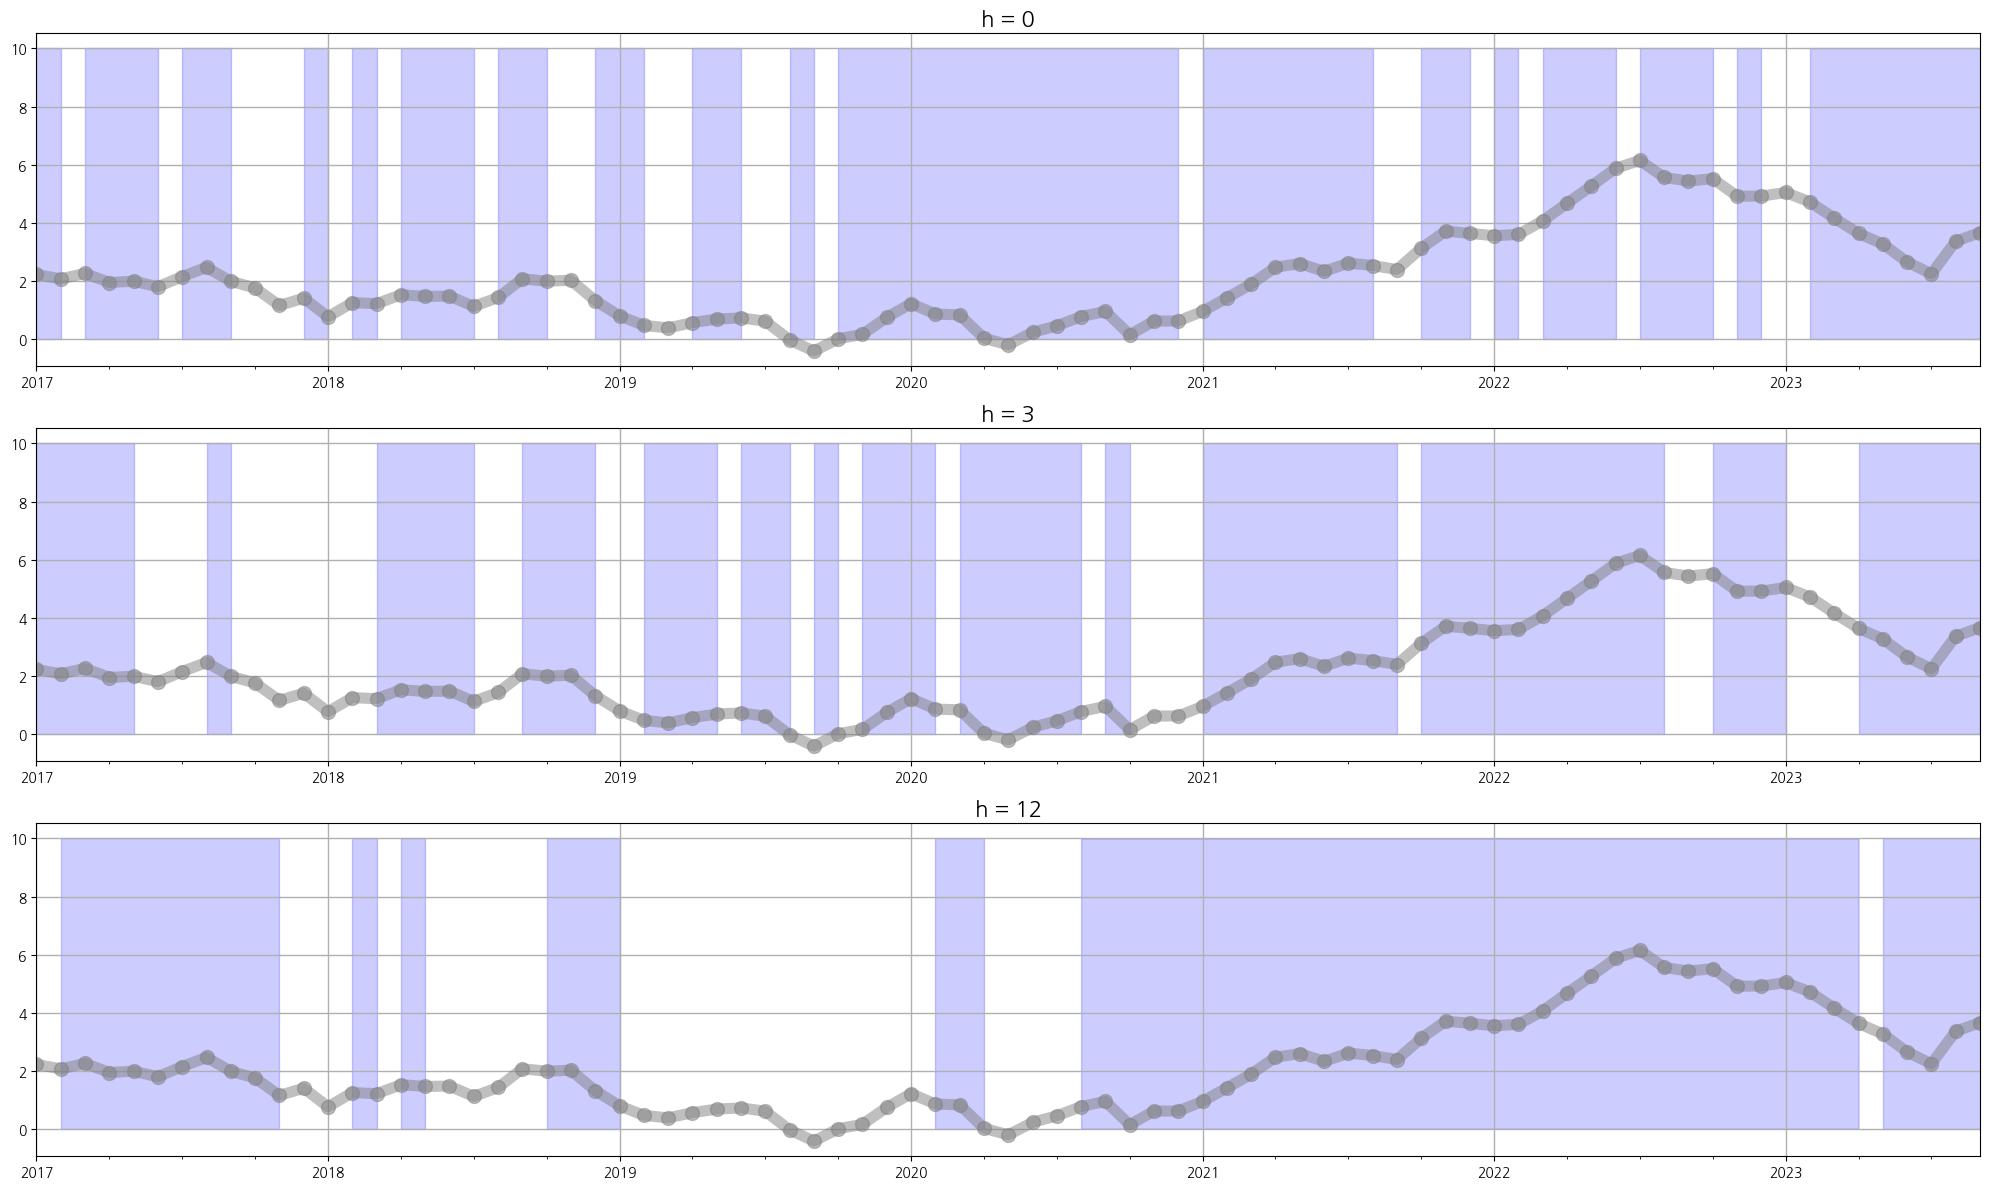

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12))
for ax, h in zip(axs, [0, 3, 12]):
    act[targets].loc['2017':].plot(ax=ax, lw=8, color='gray', marker='o', markersize=10, alpha=0.5)
    #ax.grid(which='minor', lw=1)
    ax.grid(which='major', lw=1)
    #ax.legend(fontsize=14)
    ax.set_title(f"h = {h}", fontsize=16)

    for ix, row in MATCHED[h].iterrows():
        m0 = row['first']
        m1 = row['last'] + MonthEnd(1)
        m0 = Nth_friday(m0.year, m0.month, -2)
        m1 = Nth_friday(m1.year, m1.month, 2)
        ax.fill_between(pd.date_range(m0, m1), 10, color='blue', alpha=.2)

fig.tight_layout()

# 실제치

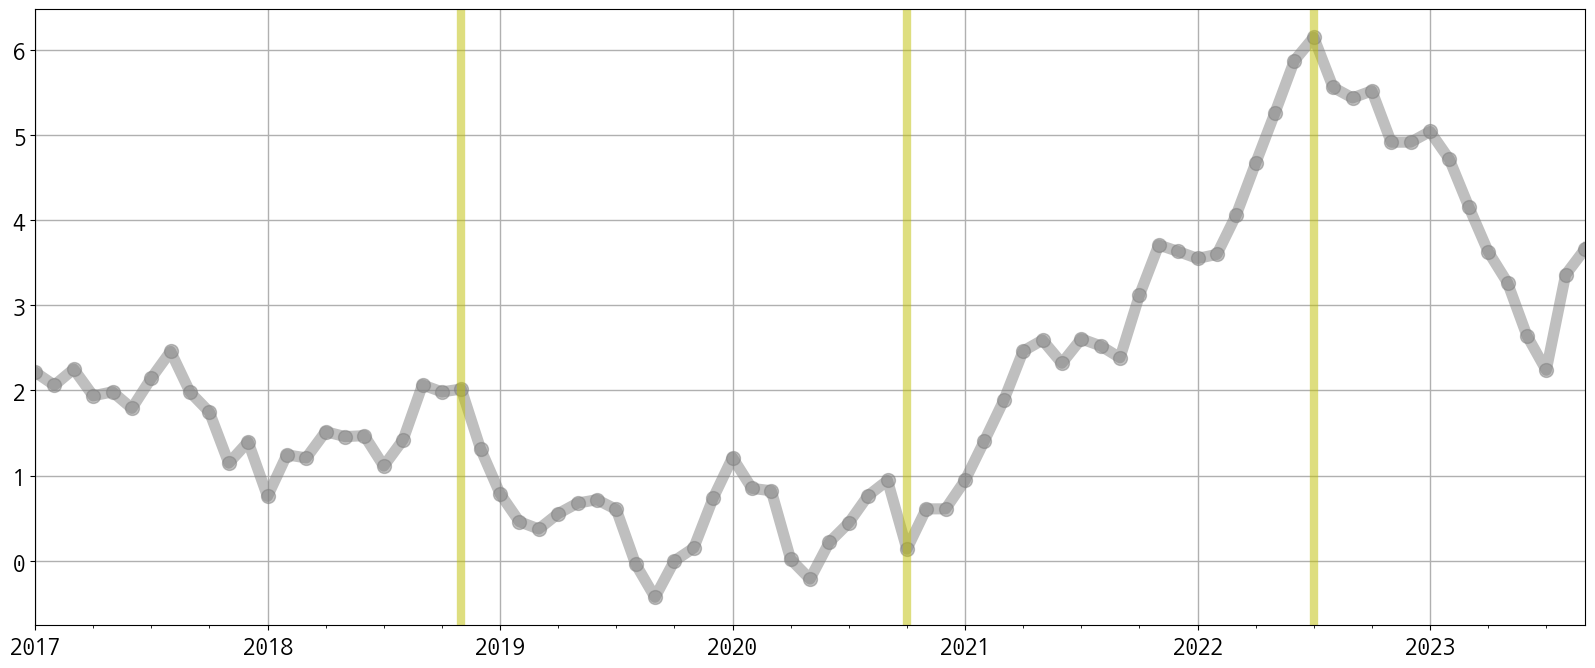

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8))
for ax, h in zip([axs], [0]):
    act[targets].loc['2017':].plot(ax=ax, lw=8, color='gray', marker='o', markersize=10, alpha=0.5)
    #ax.grid(which='minor', lw=1)
    ax.grid(which='major', lw=1)
    #ax.legend(fontsize=14)
    #ax.set_title(f"h = {h}", fontsize=16)
    ax.tick_params(axis="both", labelsize=18)
    for x in ['2018-11-30', '2020-10-31', '2022-07-31']:
        ax.axvline(x=x, lw=6, color='y', alpha=0.5)

# 전망시계별 전망모형

In [182]:
#ens_sel = {0:695, 3:113, 12:7}
ens_sel = {0:23, 3:51, 12:18}

In [227]:
indices = [index for index, value in enumerate(ens_models) if value == ['lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:P_eir:GB_cp_3', 'ext_roll0_lag0_d6_g1']]

In [228]:
indices

[27]

In [217]:
ens_models[18]

['lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3',
 'ext_roll0_lag0_d6_g1']

## 기여도분해

In [26]:
#fms = [pd.Timestamp(date+'-1') for date
#       in ['2020-10', '2020-12', '2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7', '2021-8', '2021-9', '2021-10', '2021-11', '2021-12',
#           '2022-1', '2022-2', '2022-3', '2022-7', '2022-8', '2022-9', '2022-10', '2022-11', '2022-12', '2022-1',
#           '2023-1', '2023-2', '2023-3', '2023-4', '2023-5', '2023-6', '2023-7', '2023-8', '2023-9']]

In [343]:
fms = [pd.Timestamp(date+'-1') for date
       #in ['2020-10', '2022-7', '2023-7', '2023-8', '2023-9', '2023-10', '2023-11']]
       in ['2024-1']]

In [347]:
#[month + MonthEnd(0) for month in pd.date_range('2023-8-1', '2023-9-1', freq='M')]
#for month in pd.date_range('2023-8-1', '2023-9-1', freq='M'):
for month in fms:

    fm = month + MonthEnd(0)

    today = Nth_friday(fm.year, fm.month, 1)
    _, act_vintage = get_train_data_v5(DF_vintages[today])
    last_inf_month = act_vintage.dropna().index[-1]
    last_inf = act_vintage.dropna().iloc[-1]
    #print(f"The latest inflation is {last_inf:.2f} for {last_inf_month:%Y-%m}")

    for h in [12]:

        tm = fm + MonthEnd(h)
        model_names = ens_models[ens_sel[h]] # h=0: ens103, h=3: ens1005, h=12: ens35}
        print(f"\nhor : {h} months, fm : {fm:%Y-%m}, tm : {tm:%Y-%m}")
        print(', '.join(model_names))

        PRED_DECOMP = pd.DataFrame()

        for mname in model_names:
            print(f"\ndecomposing {mname} ...")
            try:
                model = joblib.load(f"model_lee/{mname}_{tm.year}-01_h{h}.pkl")
            except:
                print(f"Model for {tm.year - 1} is loaded instead of {tm.year}, which does NOT exist.")
                model = joblib.load(f"model_lee/{mname}_{tm.year - 1}-01_h{h}.pkl")

            fm_vintages = [date for date in vintages if (date.month == fm.month) and (date.year == fm.year)]

            if h == 0:
                pm = fm - MonthEnd(1)
                pm_vintages = [Nth_friday(pm.year, pm.month, i) for i in [-3, -2, -1]]
            else:
                pm_vintages = [Nth_friday(m.year, m.month, -1) for m in [fm - MonthEnd(i) for i in [3, 2, 1]]]

            decomp_vintages = pm_vintages + fm_vintages
            pred = pd.DataFrame(index=decomp_vintages, columns=['forecast'])

            rolling = int(mname.split('_roll')[1].split('_')[0])
            lag = int(mname.split('_lag')[1].split('_')[0])

            if mname.split('_')[0] == 'lm':
                data_group = mname.split('_model')[1].split(':')
                excl_alt = False
            else:
                data_group = int(mname.split('_g')[1].split('_')[0])
                excl_alt = True

            df0 = DF_vintages[decomp_vintages[0]].copy()
            X0, _ = get_train_data_v5(df0, lag, data_group, excl_alt, fm, rolling=rolling)

            if mname.split('_')[0] == 'lm':
                pred0 = model.predict(X0.loc[[fm]])[0]
            else:
                if h == 12:
                    X0 = X0.drop(['P_eir'], axis = 1) # 12개월 전망 기대인플레 제외
                else:
                    pass
                pred0 = model.predict(X0.loc[[fm]])[0] + last_inf

            decomp = pd.DataFrame(index=decomp_vintages[1:], columns=df0.columns)
            pred.loc[decomp_vintages[0], 'forecast'] = pred0

            for v in decomp_vintages[1:]:
                print(f"{v:%m-%d}", end=' ')
                df1 = DF_vintages[v].copy()

                for col in df0.columns:
                    df0 = df0.reindex(df1.index)
                    df0.loc[:, col] = df1.loc[:, col].copy()
                    X1, _ = get_train_data_v5(df0, lag, data_group, excl_alt, fm, rolling=rolling)
                    if mname.split('_')[0] == 'lm':
                        pred1 = model.predict(X1.loc[[fm]])[0]
                    else:
                        if h == 12:
                            X1 = X1.drop(['P_eir'], axis = 1) # 12개월 전망 기대인플레 제외
                        else:
                            pass
                        pred1 = model.predict(X1.loc[[fm]])[0] + last_inf
                    diff = pred1 - pred0
                    if np.abs(diff) > 0.001:
                        print(f"({col}){diff:.3f}", end=' ')
                    decomp.loc[v, col] = diff
                    pred0 = pred1

                pred.loc[v, 'forecast'] = pred1
                print(f"({pred1:.3f})")

            decomp = decomp.applymap(lambda x: np.nan if np.abs(x) < 0.0001 else x)
            decomp = decomp.dropna(how='all', axis=1)
            pred_decomp = pd.concat([pred, decomp], axis=1)
            pred_decomp = pd.concat([pred_decomp], axis=1, keys=[mname])
            PRED_DECOMP = pd.concat([PRED_DECOMP, pred_decomp], axis=1)

        PRED_DECOMP.to_pickle(f"output_IssueNotes/decomp_{fm:%Y-%m-%d}_{h}.pkl")


hor : 12 months, fm : 2024-01, tm : 2025-01
lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3, ext_roll0_lag0_d6_g1

decomposing lm_roll0_lag4_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3 ...
Model for 2024 is loaded instead of 2025, which does NOT exist.
11-24 (P_cpi_1)0.038 (P_ipi_6)0.013 (RE_atpi_1)0.325 (GB_cp_3)-0.124 (2.512)
12-29 (P_cpi_1)-0.206 (P_ipi_6)-0.013 (RE_atpi_1)-0.395 (GB_cp_3)0.014 (1.911)
01-05 (GB_cp_3)-0.007 (1.905)
01-12 (1.905)
01-19 (P_ipi_6)-0.004 (RE_atpi_1)0.376 (GB_cp_3)0.001 (2.278)
01-26 (GB_cp_3)0.003 (2.280)

decomposing ext_roll0_lag0_d6_g1 ...
Model for 2024 is loaded instead of 2025, which does NOT exist.
11-24 (P_ppi_1)0.005 (P_eadm)-0.231 (PB_ipi_1)0.003 (PB_ioi_3)0.004 (PB_ioi_5)0.012 (L_eap_10)-0.010 (LM_m1_2)-0.011 (LM_cbl_1)-0.013 (IE_mir_1)-0.001 (IE_mir_5)0.019 (IE_mir_6)0.006 (IE_mir_9)0.010 (IE_mir_10)0.002 (EI_iai_1)0.002 (EI_tti_2)0.002 (S_spi_1)-0.050 (GB_us_1)0.007 (2.165)
12-29 (P_eadm)0.309 (PB_ioi_1)0.009 (PB_ioi_3)0.038 (PB_ioi_5)0.00

## 대시보드

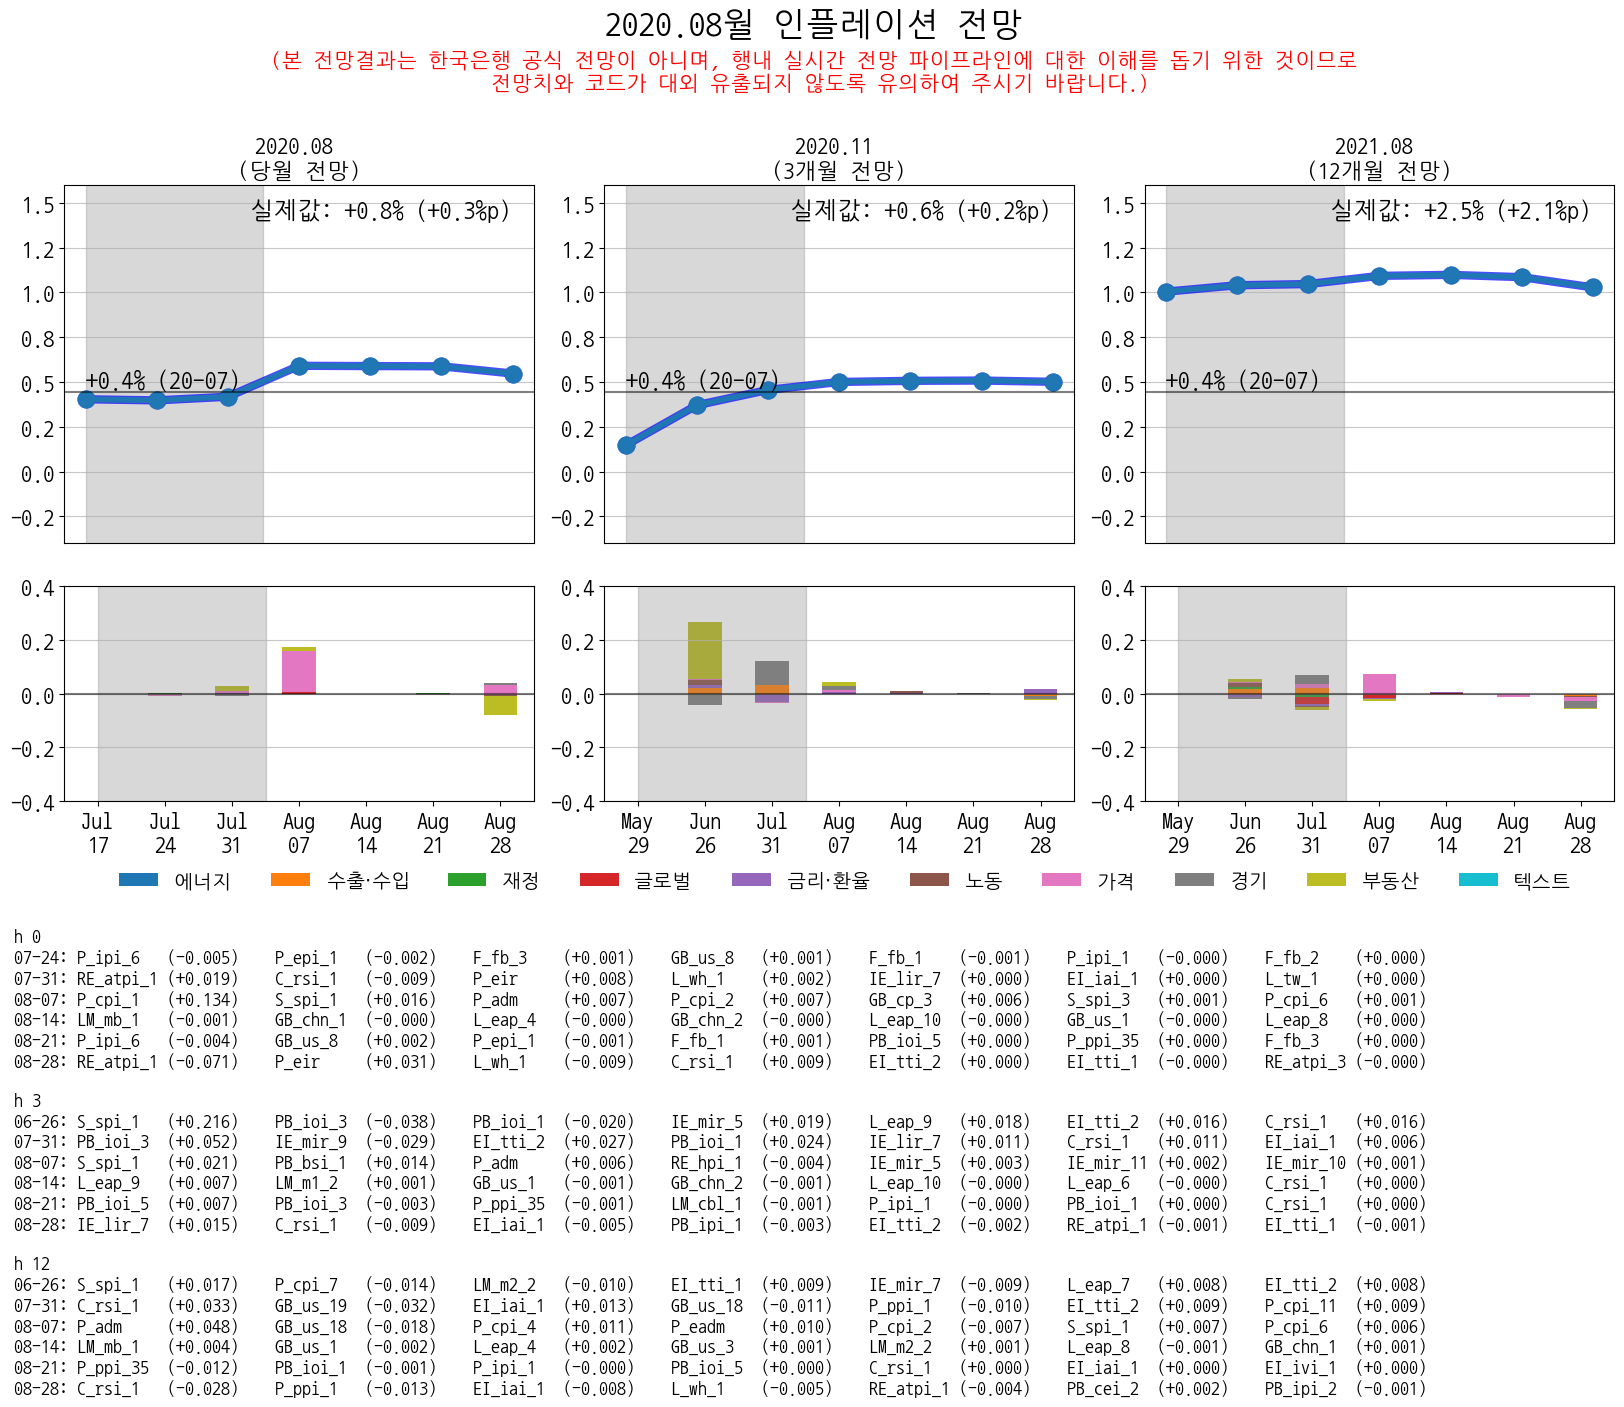

In [70]:
from IPython.display import Image, display
download_from_s3(f'{s3_repo_path}/plot/inf_2020.08.png', f"{local_path}/plot")
display(Image(filename = 'plot/inf_2020.08.png'))

In [1]:
import import_ipynb
from train_models import *

importing Jupyter notebook from train_models.ipynb


2023-11-09 15:46:12.892739: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 15:46:13.438206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 15:46:17.856282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DO_TRAIN = False
DO_HYPERPARAMETER_TUNE = False # if True, train models with all hyperparameter combinations. if False, only train best models
GET_EVALUATION_PLOT = False

In [224]:
local_path = set_local_path()

NameError: name 'set_local_path' is not defined

In [4]:
model_types = ['reg', 'ext'] #['arima', 'rw', 'reg', 'ext']

if DO_TRAIN:
    train_models(model_types, DO_HYPERPARAMETER_TUNE) 
    predict_and_plot(model_types, GET_EVALUATION_PLOT)

2023-12-15    3.145840
2023-12-22    3.270676
2023-12-29    3.175719
2024-01-05    3.173913
2024-01-12    3.175927
2024-01-19    3.065294
2024-01-26    2.980721
Freq: W-FRI, Name: forecast, dtype: float64
2023-10-27    3.188271
2023-11-24    3.193045
2023-12-29    2.903925
2024-01-05    2.894525
2024-01-12    2.888170
2024-01-19    2.713310
2024-01-26    2.669983
Name: forecast, dtype: float64
2023-10-27    2.333153
2023-11-24    2.338672
2023-12-29    2.174181
2024-01-05    2.178851
2024-01-12    2.180088
2024-01-19    2.350635
2024-01-26    2.348075
Name: forecast, dtype: float64


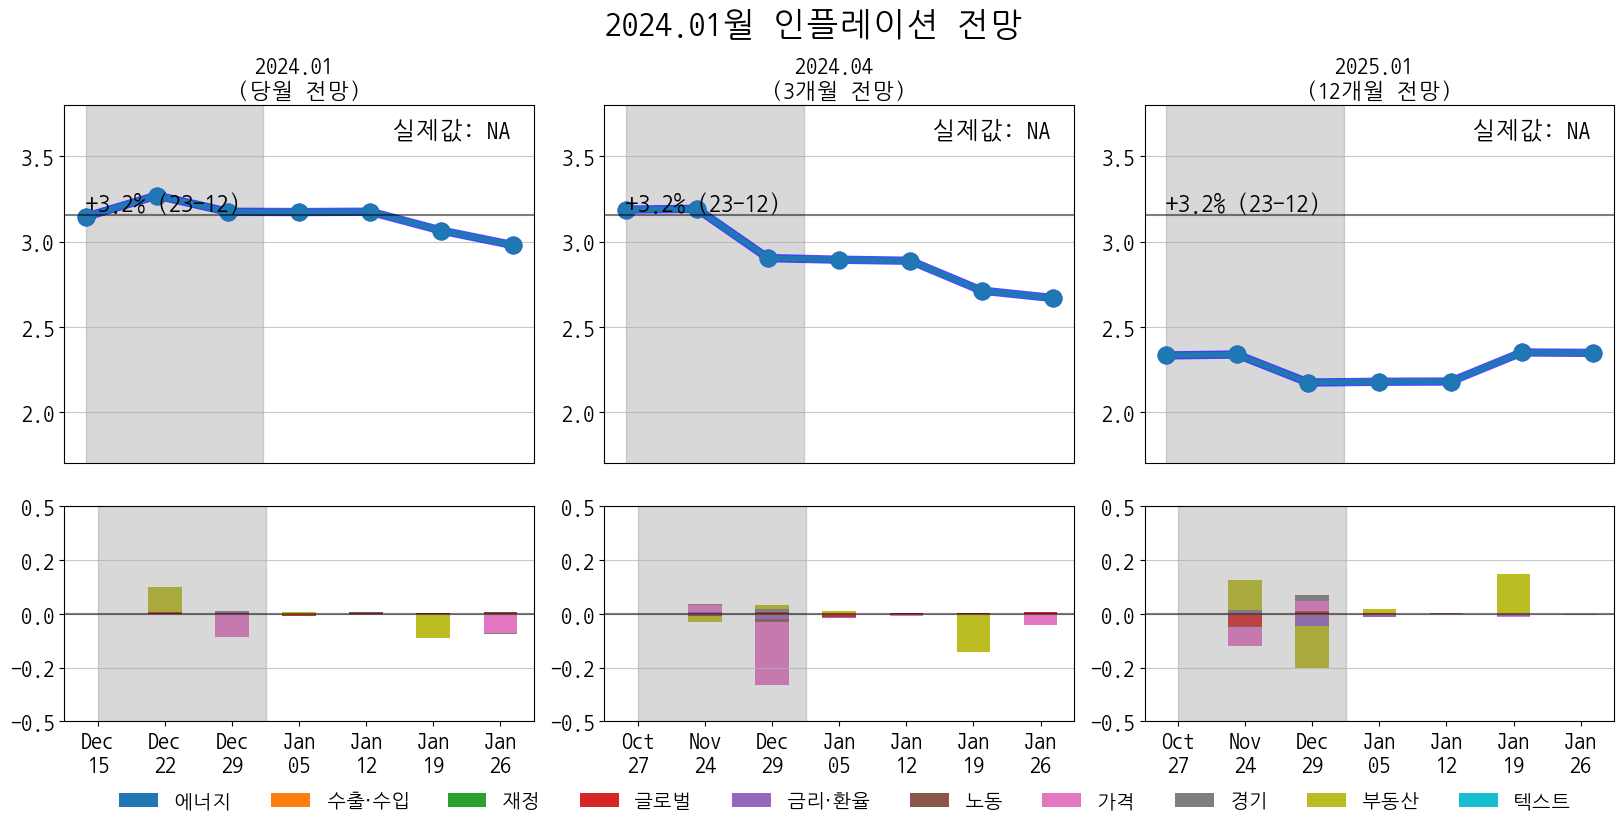

In [27]:
fm = pd.Timestamp('2024-1-1') + MonthEnd()

fig, axs = plt.subplots(2, 3, figsize=(20, 8),
                        gridspec_kw={'width_ratios': [3, 3, 3], 'height_ratios': [5, 3],
                                     'wspace': 0.15, 'hspace': 0.15})
margin = 0.5
margin0 = 0.1

DECOMP_VAR = {}

vspec = pd.read_excel('input/data_list_all_v3.xlsx', index_col = None)
vspec.index.names = [None]
vspec['group'] = vspec['My ID'].str.split('_', expand=True)[0]
id_group = vspec[['My ID', 'group']].set_index('My ID').to_dict()['group']

_, act = get_train_data_v5(DF_vintages[vintages[-1]])
act = act.dropna()

pm = fm - MonthEnd(1)

ymax = act.loc[pm]
ymin = act.loc[pm]
dymax = 0
dymin = 0

for i, h in enumerate([0, 3, 12]):
    tm = fm + MonthEnd(h)

    PRED_DECOMP = pd.read_pickle(f"output_IssueNotes/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    pred_decomp_mean = PRED_DECOMP.groupby(level=1, axis=1).sum()
    pred_decomp_mean = (pred_decomp_mean / len(PRED_DECOMP.columns.get_level_values(0).unique()))
    DECOMP_VAR[h] = pred_decomp_mean
    decomp = pred_decomp_mean.rename(columns=id_group)
    decomp = decomp.groupby(decomp.columns, axis=1).sum()

    today = decomp.index[-1]
    _, act_vintage = get_train_data_v5(DF_vintages[today])
    last_inf = act_vintage.dropna().iloc[-1]

    forecast = decomp.pop('forecast') # decomp => forecast + decomp
    print(forecast)
    decomp = decomp.reindex(columns=vspec.group.unique())
    decomp = decomp.rename(columns={'LM':'IE', 'S':'RE', 'C':'PB'})
    decomp = decomp.groupby(decomp.columns, axis=1).sum()
    decomp = decomp.rename(columns={'EG':'에너지', 'EI':r'수출$\cdot$수입', 'F':'재정', 'GB':'글로벌',
                                    'IE':r'금리$\cdot$환율', 'L':'노동', 'P':'가격', 'PB':'경기', 'RE':'부동산','T':'텍스트'})

    #diff = forecast - last_inf
    #diff = diff.to_frame('change w.r.t. last infl.')
    df = pd.concat([forecast, decomp], axis=1)
    df = df.reindex(sorted(list(set(df.index.tolist() + [Nth_friday(fm.year, fm.month, i) for i in [-4, -3, -2, -1]]))))
    ticklabels = [t.strftime("%b\n%d") for t in df.index]
    df.index = np.arange(len(df.index))

    df['forecast'].plot(ax=axs[0, i], lw=6, marker="o", color='b', markersize=12, alpha=0.7)
    axs[0, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[0, i].plot(ticklabels, df.iloc[:, 0], lw=4, marker="o", markersize=12)
    df.iloc[:, 1:].plot.bar(stacked=True, ax=axs[1, i])
    axs[1, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[1, i].set_xticklabels(ticklabels, rotation=0)
    
    axs[0, i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    axs[1, i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
    axs[0, i].axhline(y=last_inf, lw=1.5, color='k', alpha=0.5)
    axs[1, i].axhline(y=0, lw=1.5, color='k', alpha=0.5)
    ymin = min(df.iloc[:, 0].min().min(), ymin)
    ymax = max(df.iloc[:, 0].max().max(), ymax)
    dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max().max(), dymax)
    #axs[0, i].set_ylim(round(df.iloc[:, 0].min().min() - margin, 1), round(df.iloc[:, 0].max().max() + margin, 1))
    #axs[1, i].set_ylim(round(-np.abs(df.iloc[:, 1:]).sum(axis=1).max() - margin0, 1), round(np.abs(df.iloc[:, 1:]).sum(axis=1).max() + margin0, 1))
    axs[1, i].legend(ncol=14, loc=3, frameon=False, bbox_to_anchor=(0.08, -0.5), fontsize=14)
    axs[0, i].grid(alpha=0.7, axis='y')
    axs[1, i].grid(alpha=0.7, axis='y')
    if h == 0:
        axs[0, i].set_title(f"{tm:%Y.%m} \n(당월 전망)", fontsize=16)
    else:
        axs[0, i].set_title(f"{tm:%Y.%m} \n({h}개월 전망)", fontsize=16)
    axs[0, i].tick_params(axis="both", labelsize=16)
    axs[1, i].tick_params(axis="both", labelsize=16)
    axs[0, i].get_xaxis().set_visible(False)
    axs[0, i].text(0.0, last_inf, f"{act.loc[pm]:+.1f}% ({pm:%y-%m})", fontsize=17,
                       horizontalalignment='left', verticalalignment='bottom')
    if i > 0:
        axs[1, i].get_legend().remove()
    try:
        axs[0, i].text(0.95, 0.93, f"실제값: {act.loc[tm]:+.1f}% ({act.loc[tm]-act.loc[pm]:+.1f}%p)", fontsize=17,
                       horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)
    except:
        axs[0, i].text(0.95, 0.93, f"실제값: NA", fontsize=17,
                       horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)

    axs[0, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)
    axs[1, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)

for i, h in enumerate([0, 3, 12]):
    axs[0, i].set_ylim(round(ymin - margin, 1), round(ymax + margin, 1))
    axs[1, i].set_ylim(round(-dymax - margin0, 1), round(dymax + margin0, 1))

#warning = "본 전망결과는 한국은행 공식 전망이 아니며, 행내 실시간 전망 파이프라인에 대한 이해를 돕기 위한 것이므로\n \\textcolor{red}{전망치와 코드가 대외 유출되지 않도록 유의}하여 주시기 바랍니다."
#warning1 = "본 전망결과는 한국은행 공식 전망이 아니며, 행내 실시간 전망 파이프라인에 대한 이해를 돕기 위한 것이므로" + "\n"
#warning2 = "전망치와 코드가 대외 유출되지 않도록 유의"
#warning3 = "하여 주시기 바랍니다."
fig.suptitle(f"{fm:%Y.%m}월 인플레이션 전망", fontsize=24, y=1.0)
#fig.text(.5, 1, warning1, transform=fig.transFigure, horizontalalignment='center', fontsize=15)
#fig.text(.413, 1, warning2, transform=fig.transFigure, horizontalalignment='center', fontsize=16, color='red')
#fig.text(.582, 1, warning3, transform=fig.transFigure, horizontalalignment='center', fontsize=15)
#fig.savefig('inf_2020_9.png', bbox_inches='tight', dpi=300)    
    
text = ''
for h in [0, 3, 12]:
    text += f"\n\nh {h} "
    #print(f"\n\nforecasting horizon: {h}", end='')
    df = DECOMP_VAR[h].drop('forecast', axis=1)
    for i in df.index[1:]:
        vars = np.abs(df).loc[i].nlargest(7).index
        text += f"\n{i:%m-%d}:\t"
        #print(f"\n{i:%m-%d}:", end='\t')
        for v in vars:
            text += f"{v:<10}({df.loc[i, v]:+.3f})    "
            #print(f"{v:<10}({df.loc[i, v]:+.3f})", end='   ')

#if True: # print_decomp_var = True
#    fig.text(0.1, 0.0, text, fontsize=13, horizontalalignment='left', verticalalignment='top')
#fig.suptitle(f"Inflation nowcasting - {fm:%Y.%m} (change w.r.t. {act.loc[pm]:.1f}% in {pm:%y.%m})", fontsize=20, y=1.01);

#fig.savefig(f"{local_path}/plot/inf_{fm:%Y.%m}.png", dpi='figure', bbox_inches='tight')
#upload_to_s3(f"{local_path}/plot/inf_{fm:%Y.%m}.png", f'{s3_repo_path}/plot/') #inf_{fm:%Y.%m}.png
fig.patch.set_alpha(0.0)

In [23]:
forecast

2023-10-27    2.333153
2023-11-24    2.338672
2023-12-29    2.174181
2024-01-05    2.178851
2024-01-12    2.180088
2024-01-19    2.350635
2024-01-26    2.348075
Name: forecast, dtype: float64

In [428]:
#fig.savefig(f"./IssueNotes/inf_{fm:%Y.%m}_new.png", dpi='figure', bbox_inches='tight')
fig.savefig(f"./IssueNotes/부록13_그림.eps", dpi=300, bbox_inches='tight')

#fig.savefig(f"{local_path}/plot/inf_latest.png", dpi='figure', bbox_inches='tight')
#upload_to_s3(f"{local_path}/plot/inf_latest.png", f'{s3_repo_path}/plot/')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [3]:
fm = pd.Timestamp('2024-1-1') + MonthEnd()

fig, axs = plt.subplots(2, 3, figsize=(20, 8),
                        gridspec_kw={'width_ratios': [3, 3, 3], 'height_ratios': [5, 3],
                                     'wspace': 0.15, 'hspace': 0.15})
margin = 0.5
margin0 = 0.1

DECOMP_VAR = {}

vspec = pd.read_excel('input/data_list_all_v3.xlsx', index_col = None)
vspec.index.names = [None]
vspec['group'] = vspec['My ID'].str.split('_', expand=True)[0]
id_group = vspec[['My ID', 'group']].set_index('My ID').to_dict()['group']

_, act = get_train_data_v5(DF_vintages[vintages[-1]])
act = act.dropna()

pm = fm - MonthEnd(1)

ymax = act.loc[pm]
ymin = act.loc[pm]
dymax = 0
dymin = 0

for i, h in enumerate([0, 3, 12]):
    tm = fm + MonthEnd(h)

    PRED_DECOMP = pd.read_pickle(f"output_IssueNotes/decomp_{fm:%Y-%m-%d}_{h}.pkl")
    pred_decomp_mean = PRED_DECOMP.groupby(level=1, axis=1).sum()
    pred_decomp_mean = (pred_decomp_mean / len(PRED_DECOMP.columns.get_level_values(0).unique()))
    DECOMP_VAR[h] = pred_decomp_mean
    decomp = pred_decomp_mean.rename(columns=id_group)
    decomp = decomp.groupby(decomp.columns, axis=1).sum()

    today = decomp.index[-1]
    _, act_vintage = get_train_data_v5(DF_vintages[today])
    last_inf = act_vintage.dropna().iloc[-1]

    forecast = decomp.pop('forecast') # decomp => forecast + decomp
    decomp = decomp.reindex(columns=vspec.group.unique())
    decomp = decomp.rename(columns={'LM':'IE', 'S':'RE', 'C':'PB'})
    decomp = decomp.groupby(decomp.columns, axis=1).sum()
    decomp = decomp.rename(columns={'EG':'에너지', 'EI':r'수출$\cdot$수입', 'F':'재정', 'GB':'글로벌',
                                    'IE':r'금리$\cdot$환율', 'L':'노동', 'P':'가격', 'PB':'경기', 'RE':'부동산','T':'텍스트'})

    #diff = forecast - last_inf
    #diff = diff.to_frame('change w.r.t. last infl.')
    df = pd.concat([forecast, decomp], axis=1)
    df = df.reindex(sorted(list(set(df.index.tolist() + [Nth_friday(fm.year, fm.month, i) for i in [-4, -3, -2, -1]]))))
    ticklabels = [t.strftime("%b\n%d") for t in df.index]
    df.index = np.arange(len(df.index))

    df['forecast'].plot(ax=axs[0, i], lw=6, marker="o", color='b', markersize=12, alpha=0.7)
    axs[0, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[0, i].plot(ticklabels, df.iloc[:, 0], lw=4, marker="o", markersize=12)
    df.iloc[:, 1:].plot.bar(stacked=True, ax=axs[1, i])
    axs[1, i].plot(df.index, df.fillna(df.mean())['forecast'], alpha=0, color='b')
    axs[1, i].set_xticklabels(ticklabels, rotation=0)
    axs[0, i].axhline(y=last_inf, lw=1.5, color='k', alpha=0.5)
    axs[1, i].axhline(y=0, lw=1.5, color='k', alpha=0.5)
    ymin = min(df.iloc[:, 0].min().min(), ymin)
    ymax = max(df.iloc[:, 0].max().max(), ymax)
    dymax = max(np.abs(df.iloc[:, 1:]).sum(axis=1).max().max(), dymax)
    #axs[0, i].set_ylim(round(df.iloc[:, 0].min().min() - margin, 1), round(df.iloc[:, 0].max().max() + margin, 1))
    #axs[1, i].set_ylim(round(-np.abs(df.iloc[:, 1:]).sum(axis=1).max() - margin0, 1), round(np.abs(df.iloc[:, 1:]).sum(axis=1).max() + margin0, 1))
    axs[1, i].legend(ncol=14, loc=3, frameon=False, bbox_to_anchor=(0.08, -0.5), fontsize=14)
    axs[0, i].grid(alpha=0.7, axis='y')
    axs[1, i].grid(alpha=0.7, axis='y')
    if h == 0:
        axs[0, i].set_title(f"{tm:%Y.%m} \n(당월 전망)", fontsize=16)
    else:
        axs[0, i].set_title(f"{tm:%Y.%m} \n({h}개월 전망)", fontsize=16)
    axs[0, i].tick_params(axis="both", labelsize=16)
    axs[1, i].tick_params(axis="both", labelsize=16)
    axs[0, i].get_xaxis().set_visible(False)
    axs[0, i].text(0.0, last_inf, f"{act.loc[pm]:+.1f}% ({pm:%y-%m})", fontsize=15,
                       horizontalalignment='left', verticalalignment='bottom')
    if i > 0:
        axs[1, i].get_legend().remove()
    try:
        axs[0, i].text(0.95, 0.93, f"실제값: {act.loc[tm]:+.1f}% ({act.loc[tm]-act.loc[pm]:+.1f}%p)", fontsize=13,
                       horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)
    except:
        axs[0, i].text(0.95, 0.93, f"실제값: NA", fontsize=13,
                       horizontalalignment='right', verticalalignment='center', transform=axs[0, i].transAxes)

    axs[0, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)
    axs[1, i].fill_between((0, 2.5), -10, 10, color='gray', alpha=.3)

for i, h in enumerate([0, 3, 12]):
    axs[0, i].set_ylim(round(ymin - margin, 1), round(ymax + margin, 1))
    axs[1, i].set_ylim(round(-dymax - margin0, 1), round(dymax + margin0, 1))

fig.suptitle(f"{fm:%Y.%m}월 인플레이션 전망", fontsize=24, y=1.01);
fig.savefig('inf_2023-9.png', bbox_inches='tight', dpi=300)    
    
text = ''
for h in [0, 3, 12]:
    text += f"\n\nh {h} "
    #print(f"\n\nforecasting horizon: {h}", end='')
    df = DECOMP_VAR[h].drop('forecast', axis=1)
    for i in df.index[1:]:
        vars = np.abs(df).loc[i].nlargest(7).index
        text += f"\n{i:%m-%d}:\t"
        #print(f"\n{i:%m-%d}:", end='\t')
        for v in vars:
            text += f"{v:<10}({df.loc[i, v]:+.3f})    "
            #print(f"{v:<10}({df.loc[i, v]:+.3f})", end='   ')

if True: # print_decomp_var = True
    fig.text(0.1, 0.0, text, fontsize=13, horizontalalignment='left', verticalalignment='top')
#fig.suptitle(f"Inflation nowcasting - {fm:%Y.%m} (change w.r.t. {act.loc[pm]:.1f}% in {pm:%y.%m})", fontsize=20, y=1.01);

NameError: name 'pd' is not defined

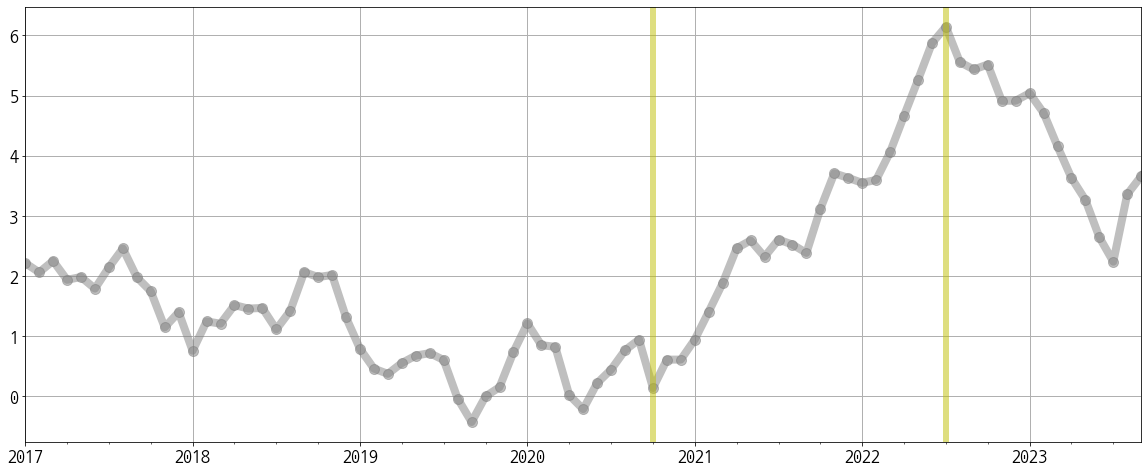

In [44]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8))
for ax, h in zip([axs], [0]):
    act[targets].loc['2017':].plot(ax=ax, lw=8, color='gray', marker='o', markersize=10, alpha=0.5, fontsize=20)
    #ax.grid(which='minor', lw=1)
    ax.grid(which='major', lw=1)
    #ax.legend(fontsize=14)
    #ax.set_title(f"h = {h}", fontsize=16)
    ax.tick_params(axis="both", labelsize=18)
    for x in ['2020-10-31', '2022-07-31']:
        ax.axvline(x=x, lw=6, color='y', alpha=0.5)

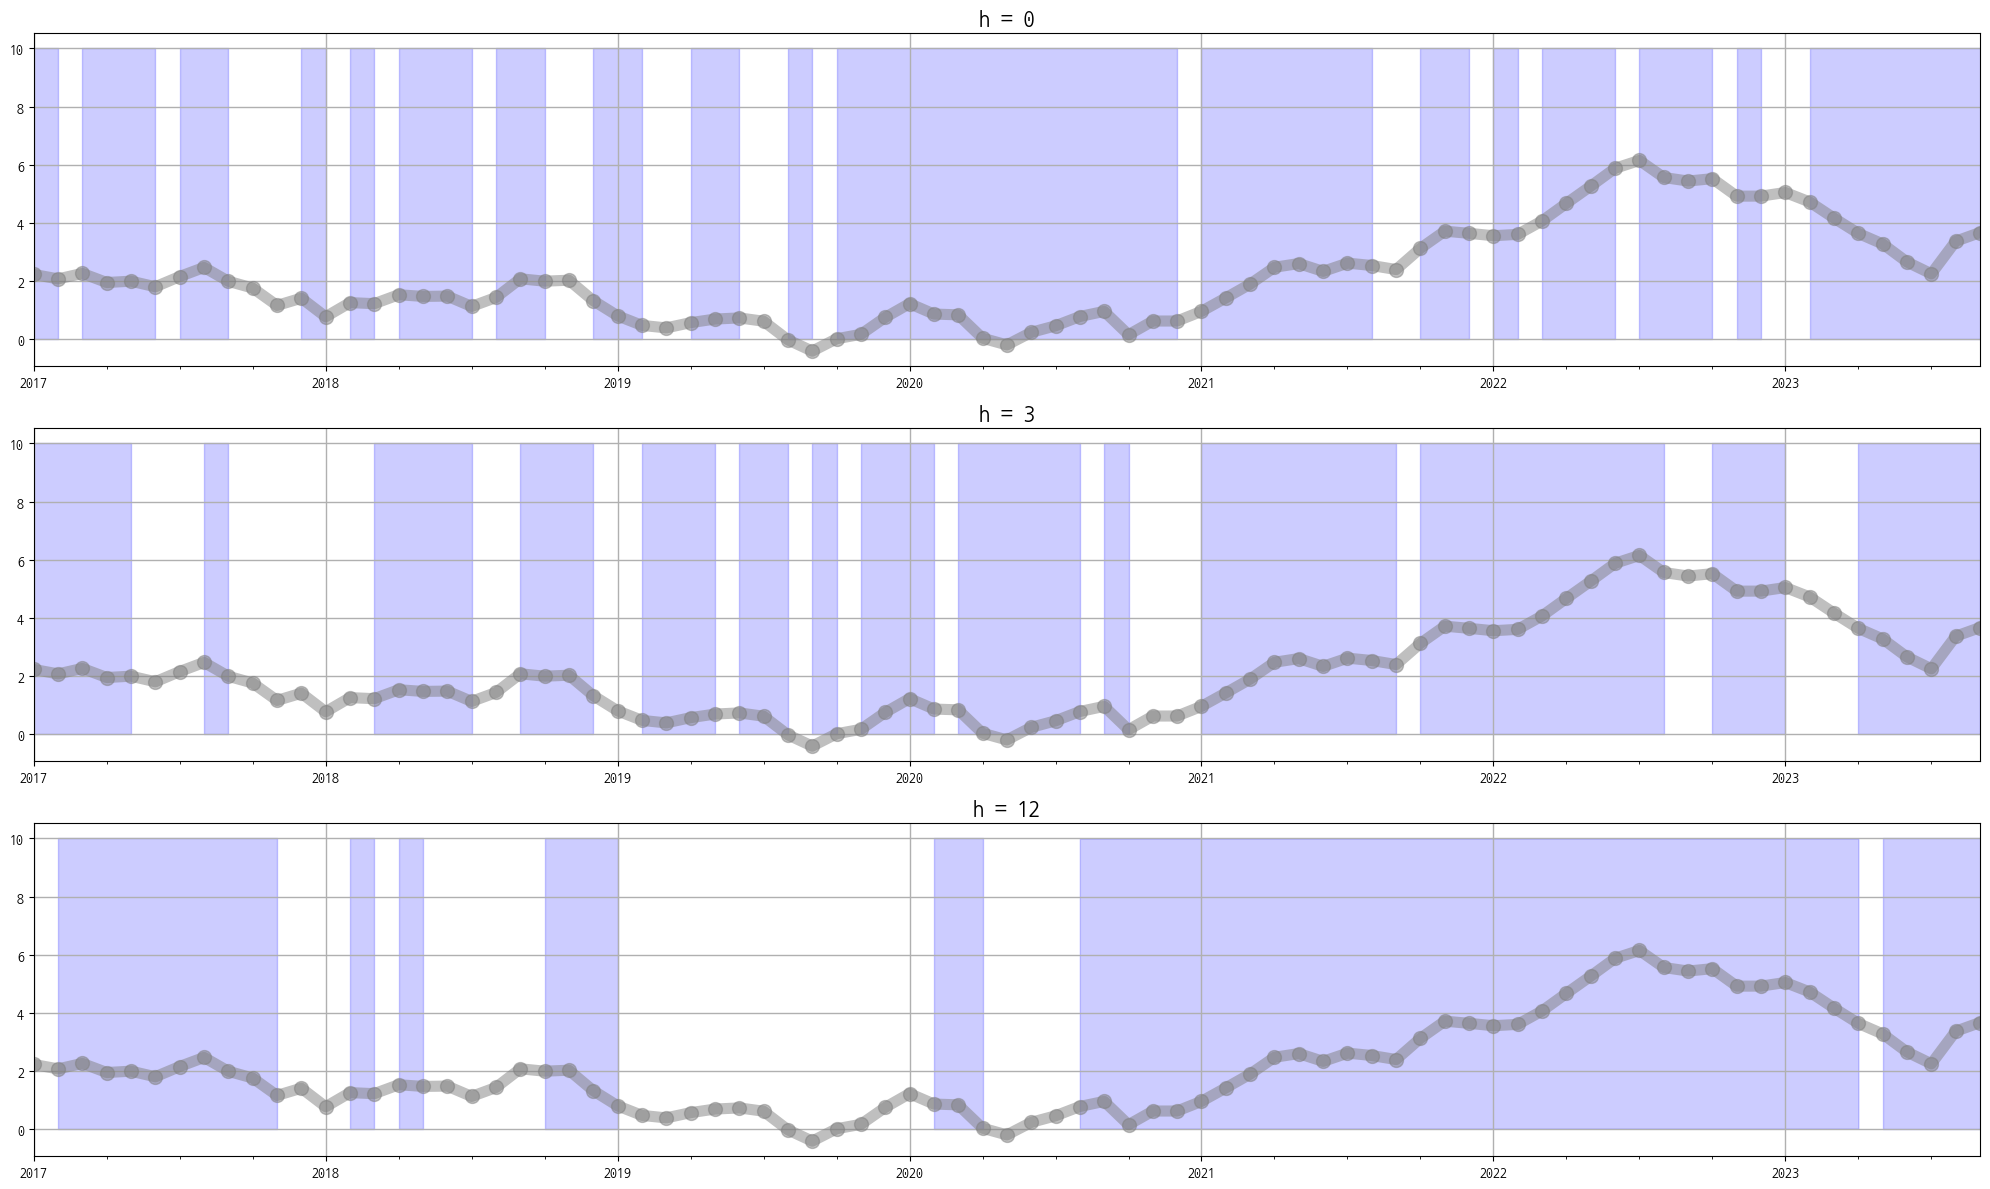

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12))
for ax, h in zip(axs, [0, 3, 12]):
    act[targets].loc['2017':].plot(ax=ax, lw=8, color='gray', marker='o', markersize=10, alpha=0.5)
    #ax.grid(which='minor', lw=1)
    ax.grid(which='major', lw=1)
    #ax.legend(fontsize=14)
    ax.set_title(f"h = {h}", fontsize=16)

    for ix, row in MATCHED[h].iterrows():
        m0 = row['first']
        m1 = row['last'] + MonthEnd(1)
        m0 = Nth_friday(m0.year, m0.month, -2)
        m1 = Nth_friday(m1.year, m1.month, 2)
        ax.fill_between(pd.date_range(m0, m1), 10, color='blue', alpha=.2)

fig.tight_layout()

# 조사국 물가전망

In [381]:
targets2 = pd.date_range('2016-06-30', '2023-06-30', freq='6M')

In [410]:
forecasts = pd.read_excel('output_IssueNotes/bok_forecasts_1y.xlsx', sheet_name = 'Sheet2', index_col = 0)
forecasts.index = pd.to_datetime(forecasts.index)

In [429]:
rmse_1y = np.sqrt(MSE(act[targets2], forecasts['Forecasts'][targets2]))
mae_1y = MAE(act[targets2], forecasts['Forecasts'][targets2])

In [430]:
print(f"RMSE: {rmse_1y:.2f}")
print(f"MAE: {mae_1y:.2f}")

RMSE: 1.74
MAE: 1.34


# DM test

In [397]:
from scipy.stats import t

In [400]:
import collections

In [398]:
def DM_test(actual_values, predm1, predm2, h, harvey_adj=True):
    
    e1_lst = []
    e2_lst = []
    d_lst = []
    
    actual_values = pd.Series(actual_values).apply(lambda x: float(x)).tolist()
    predm1 = pd.Series(predm1).apply(lambda x: float(x)).tolist()
    predm2 = pd.Series(predm2).apply(lambda x: float(x)).tolist()
    
    # Length of forecasts
    T = float(len(actual_values))
    
    # Construct loss differential according to error criterion (RMSE)
    for actual, p1, p2 in zip(actual_values, predm1, predm2):
        e1_lst.append((actual - p1)**2)
        e2_lst.append((actual - p2)**2)
    for e1, e2 in zip(e1_lst, e2_lst):
        d_lst.append(e1 - e2)
        
    e1_lst = np.sqrt(e1_lst)
    e2_lst = np.sqrt(e2_lst)
        
    # Mean of loss differential
    mean_d = pd.Series(d_lst).mean()
    
    # Calculate autocovariance
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
            autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    
    # Calculate the denominator of DM stat
    gamma = []
    for lag in range(0, h):
        gamma.append(autocovariance(d_lst, len(d_lst), lag, mean_d))
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    
    # Calculate DM stat
    DM_stat = V_d**(-0.5)*mean_d
    
    # It applies a correction for small sample
    if harvey_adj is True:
        harvey_adj = ((T+1-2*h+h*(h-1)/T)/T)**(0.5)
        DM_stat = harvey_adj*DM_stat
        
    # Calculate p-value
    p_value = 2*t.cdf(-abs(DM_stat), df=T - 1)
    
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    result = dm_return(DM=DM_stat, p_value=p_value)
    
    return result

In [375]:
ens_pred_last_f = ens_pred_last.loc[:, (slice(None), ['ens23', 'ens51', 'ens18'])]

In [404]:
ens_pred_last_f

0         3         12        0         3         12  \
               ens23     ens23     ens23     ens51     ens51     ens51   
2016-01-31  1.081366  0.607576  2.396295   1.18758   0.49661   2.30925   
2016-02-29  0.590399  0.898695  2.471928  0.566396  0.820688  2.408446   
2016-03-31  1.129523  0.720385  2.495343  1.216503  0.714388  2.791028   
2016-04-30  0.872665  1.093615  2.636644  0.796051  1.154438  2.938547   
2016-05-31  0.935107  0.683155  2.824465   1.14156  0.864798  3.002584   
...              ...       ...       ...       ...       ...       ...   
2023-05-31  3.574375    4.8066  3.964259  3.418621  4.507599  4.465677   
2023-06-30  3.118038  4.663502  4.315795  2.955965  4.294947  4.758082   
2023-07-31  2.467882  4.022288   2.38752  2.310117  3.538003  3.046254   
2023-08-31  2.405283  3.664135  2.775385  2.202747    3.1675  3.187409   
2023-09-30  3.365917  3.244537  3.086431  3.106356  2.774576  3.473632   

                  0         3         12  
               ens18     ens18     ens18  
2016-01-31  1.080902  0.368418  1.425508  
2016-02-29   0.50899  0.673182  1.500207  
2016-03-31  1.090559  0.492751  1.642098  
2016-04-30  0.737585  0.901307  1.431513  
2016-05-31  1.031667  0.624058  1.770705  
...              ...       ...       ...  
2023-05-31  3.437877  4.570633  3.380704  
2023-06-30  2.992646  4.184108  3.638664  
2023-07-31   2.46246  3.542275  3.797042  
2023-08-31   2.16214  3.028744  3.971514  
2023-09-30  3.212503  2.681565  3.601598  

[93 rows x 9 columns]

In [391]:
np.asarray(rw_pred_last.iloc[:,0])

array([1.1254852350734978, 0.6204101532684803, 1.107109669419959,
       0.8390008634318491, 0.996864163154676, 0.7768252375783824,
       0.7369338410302184, 0.3684830767312519, 0.4861448099274135,
       1.3398871046874206, 1.4769402757671024, 1.5192180080322082,
       1.3290898424664022, 2.21610539613577, 2.061416594413501,
       2.2513622046871795, 1.936697581334368, 1.983748325393808,
       1.7901581456666094, 2.143864828164155, 2.458120514326722,
       1.9803238468594664, 1.7464548882644593, 1.1468015591641567,
       1.3976727214535245, 0.7571453048575094, 1.2448821492584194,
       1.2082707765274314, 1.5165308238824338, 1.458364480619334,
       1.4695573898136691, 1.1127715046002962, 1.4216521331808174,
       2.0656705210530646, 1.9827217516650288, 2.016572552488416,
       1.3117542656456926, 0.7898919185105768, 0.4602210317134592,
       0.3739795739034157, 0.5544033715166208, 0.6776410281676526,
       0.7182156257734995, 0.6037120729189382, -0.0372070577030037,
     

In [383]:
act.loc['2016-01-31':'2023-09-30']

2016-01-31    0.622339
2016-02-29    1.113261
2016-03-31    0.842530
2016-04-30    1.001849
2016-05-31    0.779850
                ...   
2023-05-31    3.376744
2023-06-30    2.726181
2023-07-31    2.354456
2023-08-31    3.360029
2023-09-30    3.684984
Name: P_cpi_1, Length: 93, dtype: float64

In [401]:
DM_test(act.loc['2016-01-31':'2023-09-30'], ens_pred_last_f.iloc[:,0], rw_pred_last.iloc[:,0], 1, harvey_adj=True)

dm_return(DM=-3.363429375823181, p_value=0.0011235035724335646)

In [414]:
DM_test(act.loc['2016-01-31':'2023-09-30'], ens_pred_last_f.iloc[:,4], rw_pred_last.iloc[:,1], 3, harvey_adj=True)

dm_return(DM=-2.17305511778501, p_value=0.032344981382747835)

In [415]:
DM_test(act.loc['2016-01-31':'2023-09-30'], ens_pred_last_f.iloc[:,-1], rw_pred_last.iloc[:,-1], 12, harvey_adj=True)

dm_return(DM=-1.8881415215820399, p_value=0.06215828369596095)

In [409]:
lm_pred_lastf = lm_pred_last.loc[:, (slice(None), ['lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3', 'lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3', 'lm_roll0_lag3_modelP_ipi_6:RE_atpi_1:P_cpi_1:GB_cp_3'])]

In [410]:
lm_pred_lastf

0   \
           lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3   
2016-01-31                                           1.050398      
2016-02-29                                           0.603401      
2016-03-31                                           1.226502      
2016-04-30                                           0.979467      
2016-05-31                                           1.105915      
...                                                       ...      
2023-05-31                                           3.704434      
2023-06-30                                           3.190534      
2023-07-31                                           2.576134      
2023-08-31                                            2.58856      
2023-09-30                                           3.611471      

                                                              3   \
           lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3   
2016-01-31                                           0.626777      
2016-02-29                                           0.854107      
2016-03-31                                           0.803055      
2016-04-30                                           1.036973      
2016-05-31                                           0.541963      
...                                                       ...      
2023-05-31                                           4.873444      
2023-06-30                                           4.901394      
2023-07-31                                           4.344956      
2023-08-31                                           4.116519      
2023-09-30                                           3.554895      

                                                              12  \
           lm_roll0_lag4_modelF_fb_1:P_adm:P_cpi_1:P_eir:GB_cp_3   
2016-01-31                                           2.907003      
2016-02-29                                           3.236959      
2016-03-31                                            3.26843      
2016-04-30                                           3.404233      
2016-05-31                                           4.358881      
...                                                       ...      
2023-05-31                                           3.357855      
2023-06-30                                           3.871601      
2023-07-31                                           0.839759      
2023-08-31                                           1.916525      
2023-09-30                                           3.061906      

                                                           0   \
           lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3   
2016-01-31                                           1.253623   
2016-02-29                                           0.608982   
2016-03-31                                           1.433336   
2016-04-30                                           0.838615   
2016-05-31                                           1.316359   
...                                                       ...   
2023-05-31                                           3.260932   
2023-06-30                                           2.744383   
2023-07-31                                           2.081344   
2023-08-31                                           2.159774   
2023-09-30                                           3.014608   

                                                           3   \
           lm_roll0_lag3_modelRE_atpi_1:P_cpi_1:P_eir:GB_cp_3   
2016-01-31                                           0.455586   
2016-02-29                                           0.783172   
2016-03-31                                           0.616901   
2016-04-30                                           1.208566   
2016-05-31                                           0.805523   
...                                                       ...   
2023-05-31                               

In [411]:
DM_test(act.loc['2016-01-31':'2023-09-30'], ens_pred_last_f.iloc[:,0], lm_pred_lastf.iloc[:,0], 1, harvey_adj=True)

dm_return(DM=-1.7543027753798628, p_value=0.08270837691055809)

In [416]:
DM_test(act.loc['2016-01-31':'2023-09-30'], ens_pred_last_f.iloc[:,4], lm_pred_lastf.iloc[:,4], 3, harvey_adj=True)

dm_return(DM=-0.28287242770255233, p_value=0.7779101126794793)

In [417]:
DM_test(act.loc['2016-01-31':'2023-09-30'], ens_pred_last_f.iloc[:,-1], lm_pred_lastf.iloc[:,-1], 12, harvey_adj=True)

dm_return(DM=-0.13878985676671438, p_value=0.8899195615930291)

In [420]:
ext_pred_last

0                                             \
           ext_roll0_lag0_d10_g1 ext_roll0_lag0_d6_g1 ext_roll0_lag0_d8_g1   
2016-01-31              1.109868             1.098558             1.102229   
2016-02-29                0.5263             0.546045             0.533715   
2016-03-31              1.002837             0.990524             1.000738   
2016-04-30              0.770486              0.77819             0.772157   
2016-05-31              0.859726             0.877287             0.866473   
...                          ...                  ...                  ...   
2023-05-31               3.40358             3.372602             3.422893   
2023-06-30              3.143456             3.098691             3.150372   
2023-07-31              2.586457             2.560312             2.595312   
2023-08-31               2.16653             2.142098             2.178165   
2023-09-30              3.341556             3.279562             3.343104   

                                                   3                        \
           ext_roll0_lag0_d8_g2 ext_roll0_lag0_d10_g1 ext_roll0_lag0_d6_g1   
2016-01-31             1.113193              0.543884             0.425196   
2016-02-29             0.533255              0.895743             0.804174   
2016-03-31             1.013939              0.757604             0.698876   
2016-04-30             0.766659              1.073429             0.994439   
2016-05-31             0.932213              0.462695             0.397993   
...                         ...                   ...                  ...   
2023-05-31             3.366945              4.825748             4.918855   
2023-06-30             3.070474              4.554101             4.651031   
2023-07-31             2.582256              4.011667             4.054004   
2023-08-31             2.129795              3.472779             3.465433   
2023-09-30             3.320113              3.222154              3.17684   

                                                                        12  \
           ext_roll0_lag0_d8_g1 ext_roll0_lag0_d8_g2 ext_roll0_lag0_d10_g1   
2016-01-31              0.51862             0.470683              1.118898   
2016-02-29             0.856948             0.836377              1.242004   
2016-03-31              0.74392             0.770693              0.962727   
2016-04-30              1.04761             0.980994              0.772106   
2016-05-31             0.465135             0.413855              0.782003   
...                         ...                  ...                   ...   
2023-05-31             4.790864             4.690097              3.897941   
2023-06-30             4.462808             4.353977               4.45164   
2023-07-31             3.947678             3.806449              3.803071   
2023-08-31              3.46111             3.368579              3.765809   
2023-09-30             3.208934             3.101717              3.394544   

                                                                           
           ext_roll0_lag0_d6_g1 ext_roll0_lag0_d8_g1 ext_roll0_lag0_d8_g2  
2016-01-31             0.925161             1.114521             1.056082  
2016-02-29             1.112879             1.245439             1.153929  
2016-03-31             0.814286             0.925066             0.845779  
2016-04-30             0.590439             0.744863             0.692566  
2016-05-31             0.585779             0.750918             0.754627  
...                         ...                  ...                  ...  
2023-05-31             3.007921             3.916652             3.410225  
2023-06-30             3.601146             4.507115             3.935366  
2023-07-31              3.99452             3.777316             3.783358  
2023-08-31             3.971526             3.803942             3.931749  
2023-09-30             3.579153              3.40356             3.449711

In [421]:
#ext_pred_last.iloc[:,1]
#ext_pred_last.iloc[:,5]
#ext_pred_last.iloc[:,-1]
DM_test(act.loc['2016-01-31':'2023-09-30'], ens_pred_last_f.iloc[:,0], ext_pred_last.iloc[:,1], 1, harvey_adj=True)

dm_return(DM=-2.197005662211501, p_value=0.03053200471217191)

In [422]:
DM_test(act.loc['2016-01-31':'2023-09-30'], ens_pred_last_f.iloc[:,4], ext_pred_last.iloc[:,5], 3, harvey_adj=True)

dm_return(DM=-1.721262176261446, p_value=0.08856444294302633)

In [423]:
DM_test(act.loc['2016-01-31':'2023-09-30'], ens_pred_last_f.iloc[:,-1], ext_pred_last.iloc[:,-1], 12, harvey_adj=True)

dm_return(DM=-1.1290518413026105, p_value=0.26181139180168317)